# Batting Stance

### Upload

Downloads the today's batting stance CSV from MLB Savant using the direct download link. Saves the file locally in a /downloads folder, then loads it into a pandas DataFrame (stance_df) for analysis.

##### Process:

- Pulls CSV directly from baseballsavant.mlb.com
- Creates local /downloads folder if missing
- Saves raw data as batting-stance.csv
- Loads into DataFrame and shows preview

In [1]:
import os
import pandas as pd
import requests

# Direct CSV download URL
csv_url = "https://baseballsavant.mlb.com/visuals/batting-stance?csv=true"

# Setup output directory and file path
download_dir = os.path.join(os.getcwd(), "downloads")
os.makedirs(download_dir, exist_ok=True)
csv_path = os.path.join(download_dir, "batting-stance.csv")

# Download the CSV file
response = requests.get(csv_url)
response.raise_for_status()  # Raise error if request fails

# Save the file
with open(csv_path, "wb") as f:
    f.write(response.content)

# Load into DataFrame
stance_df = pd.read_csv(csv_path)
print(stance_df.head())

/Users/adamchow/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


       id                  name bat_side side  avg_batter_y_position  \
0  646240        Devers, Rafael        L    L              22.267334   
1  691718  Crow-Armstrong, Pete        L    L              30.864907   
2  677594      Rodríguez, Julio        R    R              20.568158   
3  682985         Greene, Riley        L    L              29.436888   
4  621566           Olson, Matt        L    L              31.009940   

   avg_batter_x_position  avg_foot_sep  avg_stance_angle  \
0              26.096938     31.035497        -62.799237   
1              26.700693     33.491122         -1.923022   
2              29.679670     30.621024          1.338008   
3              25.259286     28.550438         -7.544577   
4              30.227663     31.554282         -9.922527   

   avg_intercept_y_vs_batter  avg_intercept_y_vs_plate  
0                  28.118002                  5.850668  
1                  35.859407                  5.081128  
2                  32.316761       

## Batting Stance Clustering Analysis

Groups players into distinct batting stance profiles using their position (x/y), stance angle, and foot separation. Uses Gaussian Mixture Models (GMM) to find optimal clusters, then visualizes and interprets the groupings.

**Key Steps:**
1. Prepares data (removes missing values, standardizes features)
2. Tests 2-15 clusters using 3 evaluation metrics (silhouette_score, calinski_harabasz_score, davies_bouldin_score)
3. Selects optimal cluster count (default: 6) # Found to be the best cluster for (7/30/25 data)
4. Visualizes results with PCA, box plots, and position maps
5. Describes each cluster's stance characteristics

**Output:**  
- `stance_df_clustered` - Original data + cluster assignments  
- Interactive plots showing cluster distributions  
- Printed interpretation of each group's stance

BATTING STANCE CLUSTERING ANALYSIS
Clustering Data Summary:
Original dataset size: 245
Clustering dataset size (after removing NaN): 245
Variables used: ['avg_stance_angle', 'avg_foot_sep']

Descriptive Statistics:
       avg_stance_angle  avg_foot_sep
count        245.000000    245.000000
mean         -12.186883     29.496285
std           12.029080      5.833035
min          -62.799237      7.848745
25%          -18.273654     25.754373
50%           -9.482775     29.370938
75%           -3.259176     33.014160
max            6.142629     44.385717
Evaluating different numbers of clusters (GMM)...


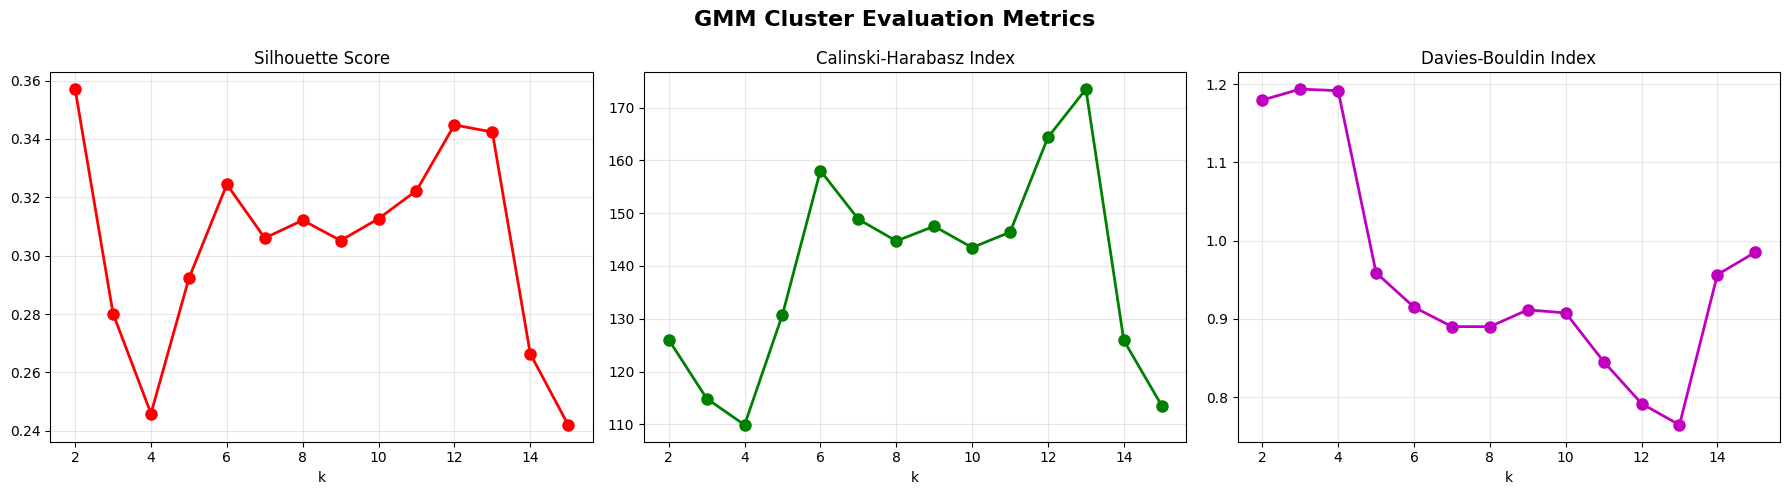


Optimal Number of Clusters by Different Methods:
Silhouette Score: 2 (score: 0.357)
Calinski-Harabasz: 13 (score: 173.5)
Davies-Bouldin: 13 (score: 0.765)

Based on the analysis above, consider these recommendations:
- Silhouette score suggests 2 clusters
- Calinski-Harabasz suggests 13 clusters
- Davies-Bouldin suggests 13 clusters

Proceeding with 6 clusters based on silhouette score...

Final GMM Clustering Results (k=6):
Silhouette Score: 0.353
Calinski-Harabasz Score: 170.6
Davies-Bouldin Score: 0.851


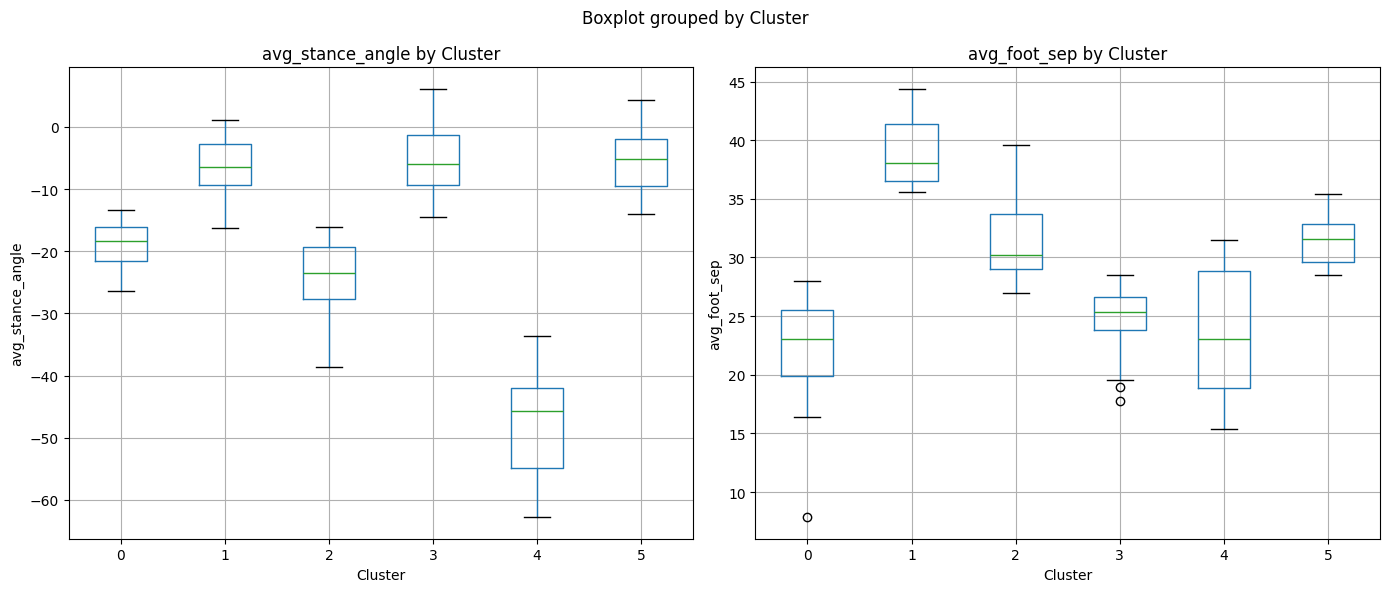


CLUSTER CHARACTERISTICS ANALYSIS

Cluster 0 (28 players):
----------------------------------------
avg_stance_angle: -19.183 ± 3.771
avg_foot_sep: 22.196 ± 4.257
avg_foot_sep: 22.196 ± 4.257
Interpretation: open stance

Cluster 1 (30 players):
----------------------------------------
avg_stance_angle: -6.230 ± 4.852
avg_foot_sep: 39.033 ± 2.688
avg_foot_sep: 39.033 ± 2.688
Interpretation: neutral stance

Cluster 2 (44 players):
----------------------------------------
avg_stance_angle: -23.772 ± 5.800
avg_foot_sep: 31.411 ± 3.281
avg_foot_sep: 31.411 ± 3.281
Interpretation: open stance

Cluster 3 (55 players):
----------------------------------------
avg_stance_angle: -5.169 ± 5.416
avg_foot_sep: 24.856 ± 2.280
avg_foot_sep: 24.856 ± 2.280
Interpretation: neutral stance

Cluster 4 (11 players):
----------------------------------------
avg_stance_angle: -47.861 ± 8.817
avg_foot_sep: 23.867 ± 5.938
avg_foot_sep: 23.867 ± 5.938
Interpretation: open stance

Cluster 5 (77 players):
-------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

def prepare_clustering_data(stance_df):
    clustering_vars = ['avg_stance_angle', 'avg_foot_sep']
    cluster_data = stance_df[clustering_vars].dropna()
    print(f"Clustering Data Summary:")
    print(f"Original dataset size: {len(stance_df)}")
    print(f"Clustering dataset size (after removing NaN): {len(cluster_data)}")
    print(f"Variables used: {clustering_vars}")
    print(f"\nDescriptive Statistics:")
    print(cluster_data.describe())
    return cluster_data, clustering_vars

def find_optimal_clusters(data, max_clusters=15):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    k_range = range(2, max_clusters + 1)
    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []

    print("Evaluating different numbers of clusters (GMM)...")
    for k in k_range:
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        labels = gmm.fit_predict(data_scaled)
        silhouette_scores.append(silhouette_score(data_scaled, labels))
        calinski_scores.append(calinski_harabasz_score(data_scaled, labels))
        davies_bouldin_scores.append(davies_bouldin_score(data_scaled, labels))

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('GMM Cluster Evaluation Metrics', fontsize=16, fontweight='bold')

    axes[0].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[0].set_title('Silhouette Score')
    axes[0].set_xlabel('k')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(k_range, calinski_scores, 'go-', linewidth=2, markersize=8)
    axes[1].set_title('Calinski-Harabasz Index')
    axes[1].set_xlabel('k')
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=8)
    axes[2].set_title('Davies-Bouldin Index')
    axes[2].set_xlabel('k')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
    optimal_k_calinski = k_range[np.argmax(calinski_scores)]
    optimal_k_davies = k_range[np.argmin(davies_bouldin_scores)]

    print(f"\nOptimal Number of Clusters by Different Methods:")
    print(f"Silhouette Score: {optimal_k_silhouette} (score: {max(silhouette_scores):.3f})")
    print(f"Calinski-Harabasz: {optimal_k_calinski} (score: {max(calinski_scores):.1f})")
    print(f"Davies-Bouldin: {optimal_k_davies} (score: {min(davies_bouldin_scores):.3f})")

    return {
        'k_range': list(k_range),
        'silhouette_scores': silhouette_scores,
        'calinski_scores': calinski_scores,
        'davies_bouldin_scores': davies_bouldin_scores,
        'optimal_k_silhouette': optimal_k_silhouette,
        'optimal_k_calinski': optimal_k_calinski,
        'optimal_k_davies': optimal_k_davies,
        'scaler': scaler
    }

def perform_clustering(data, n_clusters, scaler):
    data_scaled = scaler.transform(data)
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag', random_state=42)
    cluster_labels = gmm.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    calinski_score = calinski_harabasz_score(data_scaled, cluster_labels)
    davies_bouldin = davies_bouldin_score(data_scaled, cluster_labels)

    print(f"\nFinal GMM Clustering Results (k={n_clusters}):")
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    print(f"Calinski-Harabasz Score: {calinski_score:.1f}")
    print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")

    return cluster_labels, gmm, data_scaled

def visualize_clusters(data, cluster_labels, clustering_vars, n_clusters):
    data_with_clusters = data.copy()
    data_with_clusters['Cluster'] = cluster_labels

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Distribution of Stance Variables by Cluster', fontsize=16, fontweight='bold')

    for i, var in enumerate(clustering_vars):
        data_with_clusters.boxplot(column=var, by='Cluster', ax=ax[i])
        ax[i].set_title(f'{var} by Cluster')
        ax[i].set_xlabel('Cluster')
        ax[i].set_ylabel(var)

    plt.tight_layout()
    plt.show()

    return data_with_clusters

def analyze_cluster_characteristics(data_with_clusters, clustering_vars):
    print("\n" + "="*60)
    print("CLUSTER CHARACTERISTICS ANALYSIS")
    print("="*60)

    cluster_summary = data_with_clusters.groupby('Cluster')[clustering_vars].agg(['mean', 'std', 'count'])
    for cluster in sorted(data_with_clusters['Cluster'].unique()):
        cluster_data = data_with_clusters[data_with_clusters['Cluster'] == cluster]
        n_players = len(cluster_data)
        print(f"\nCluster {cluster} ({n_players} players):")
        print("-" * 40)
        for var in clustering_vars:
            mean_val = cluster_data[var].mean()
            std_val = cluster_data[var].std()
            print(f"{var}: {mean_val:.3f} ± {std_val:.3f}")

        if 'avg_foot_sep' in cluster_data.columns:
            foot_sep_mean = cluster_data['avg_foot_sep'].mean()
            foot_sep_std = cluster_data['avg_foot_sep'].std()
            print(f"avg_foot_sep: {foot_sep_mean:.3f} ± {foot_sep_std:.3f}")

        avg_angle = cluster_data['avg_stance_angle'].mean()
        angle_desc = "open stance" if avg_angle < -10 else "closed stance" if avg_angle > 10 else "neutral stance"
        print(f"Interpretation: {angle_desc}")
    return cluster_summary

def main_clustering_analysis(stance_df, select_k=3):
    print("BATTING STANCE CLUSTERING ANALYSIS")
    print("=" * 50)
    cluster_data, clustering_vars = prepare_clustering_data(stance_df)
    cluster_metrics = find_optimal_clusters(cluster_data)
    print(f"\nBased on the analysis above, consider these recommendations:")
    print(f"- Silhouette score suggests {cluster_metrics['optimal_k_silhouette']} clusters")
    print(f"- Calinski-Harabasz suggests {cluster_metrics['optimal_k_calinski']} clusters")
    print(f"- Davies-Bouldin suggests {cluster_metrics['optimal_k_davies']} clusters")
    recommended_k = select_k
    print(f"\nProceeding with {recommended_k} clusters based on silhouette score...")
    cluster_labels, gmm_model, scaled_data = perform_clustering(
        cluster_data, recommended_k, cluster_metrics['scaler']
    )
    data_with_clusters = visualize_clusters(cluster_data, cluster_labels, clustering_vars, recommended_k)
    cluster_summary = analyze_cluster_characteristics(data_with_clusters, clustering_vars)
    return {
        'cluster_data': cluster_data,
        'data_with_clusters': data_with_clusters,
        'cluster_labels': cluster_labels,
        'gmm_model': gmm_model,
        'cluster_metrics': cluster_metrics,
        'cluster_summary': cluster_summary,
        'n_clusters': recommended_k
    }


# Usage
results = main_clustering_analysis(stance_df, 6)
stance_df_clustered = results['data_with_clusters']

| Cluster | Archetype               | Simple Summary                                                                 |
| :-----: | :---------------------- | :------------------------------------------------------------------------------ |
| **0**   | **Narrow Open**| Open stance, narrow base (~22.2): genereally leaning towards a leg kick/hover. |
| **1**   | **Balanced Wide** | Neutral stance, wide base (~39.0), square and stable lower half and very minimal head movement.       |
| **2**   | **Standard Open** | Moderate open stance, medium base (~31.4); balance of vision,  stability, and timing queues. |
| **3**   | **Balanced Narrow** | Neutral stance, narrow base (~24.9); early to start swing, likely hover movement to get back to neutral.  |
| **4**   | **Extreme Open**| Very open stance (-47.9°), narrow base (~23.9); max vision, big leg kick, generating rotational power. |
| **5**   | **Default**| Neutral stance, medium base (~31.5); versatile, leveraging stability and raw strength. |

#### Merge Clusters into stance_df

In [3]:

# Add Cluster Classifications to original DF
stance_df = stance_df.merge(
    stance_df_clustered[['avg_stance_angle', 'Cluster']], 
    on='avg_stance_angle', 
    how='left'
)

# Create is_switch column and keep only unique id+side combinations
stance_df['is_switch'] = stance_df['id'].astype(str) + stance_df['side'].astype(str)
stance_df = stance_df.drop_duplicates(subset=['is_switch'], keep='first')

# Ensure id is numueric
stance_df['id'] = stance_df['id'].astype(int)
stance_df['stance_archetype'] = stance_df['Cluster']

# Drop unwanted columns if they exist
cols_to_drop = ['avg_intercept_y_vs_batter', 'avg_intercept_y_vs_plate', 'avg_batter_y_position', 'avg_batter_x_position', 'is_switch', 'Cluster']
stance_df = stance_df.drop(columns=[col for col in cols_to_drop if col in stance_df.columns])

# Swing Path and Attack Angle

### Upload

Automatically pulls the latest swing metrics from MLB Savant (attack angles and swing paths) and loads them into a pandas DataFrame (`swing_df`).

**Process:**
1. Downloads raw CSV from MLB's bat-tracking leaderboard
2. Saves locally to `/downloads/swing_path_attack_angle.csv`
3. Loads into DataFrame for analysis

In [4]:
import os
import pandas as pd
import requests

# Direct CSV download URL
csv_url = "https://baseballsavant.mlb.com/leaderboard/bat-tracking/swing-path-attack-angle?csv=true"

# Setup output directory and file path
download_dir = os.path.join(os.getcwd(), "downloads")
os.makedirs(download_dir, exist_ok=True)
csv_path = os.path.join(download_dir, "swing_path_attack_angle.csv")

# Download the CSV file
response = requests.get(csv_url)
response.raise_for_status()  # Raise error if request fails

# Save the file
with open(csv_path, "wb") as f:
    f.write(response.content)

# Load into DataFrame
swing_df = pd.read_csv(csv_path)
print(swing_df.head())

       id              name side  avg_bat_speed  swing_tilt  attack_angle  \
0  665833       Cruz, Oneil    L      78.659180   33.436250      9.633400   
1  691406  Caminero, Junior    R      78.333298   26.431156      7.849249   
2  691023    Walker, Jordan    R      78.008791   31.719083      5.846101   
3  666176         Adell, Jo    R      77.615062   33.400693      7.335235   
4  656941   Schwarber, Kyle    L      77.215161   30.361612     14.465589   

   attack_direction  ideal_attack_angle_rate  avg_intercept_y_vs_plate  \
0         -7.958050                 0.492308                  8.068878   
1         -4.869126                 0.586207                  7.434822   
2         -6.015607                 0.458333                  6.565364   
3         -5.172420                 0.497914                 -0.068527   
4         -6.116548                 0.650834                 11.743137   

   avg_intercept_y_vs_batter  avg_batter_y_position  avg_batter_x_position  \
0             

#### Merge Clusters into swing_df

In [5]:
# Truncate Decimals
for col in swing_df.select_dtypes(include='float'):
    swing_df[col] = swing_df[col].round(3)
    
# Drop unwanted columns if they exist
cols_to_drop = ['side', 'name', 'competitive_swings']
swing_df = swing_df.drop(columns=[col for col in cols_to_drop if col in swing_df.columns])

# Aggreagte Value Statistics

### Pitch Arsenal Scraper

Extracts pitch performance metrics (run values, whiff rates, etc.) for each batter from Baseball Savant. Creates `arsenal_df` containing each player's pitch-by-pitch breakdown.

**Process:**
1. Scrapes Savant player pages using batter IDs from `stance_df`
2. Collects 2025 pitch metrics (RV/100, whiff%, xwOBA, etc.)
3. Handles data alignment issues (skips bad RV/100 column)
4. Converts all metrics to numeric format

**Output:**  
- `arsenal_df` with pitch arsenal stats for each batter  
- First 5 rows displayed for verification

In [6]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Step 1: Create arsenal_df from scraped run value stats
output_rows = []

columns_correct = [
    "Year", "Pitch Type", "RV/100", "Run Value", "Pitches", "%",
    "PA", "BA", "SLG", "wOBA", "Whiff%", "K%", "PutAway %",
    "xBA", "xSLG", "xwOBA", "Hard Hit %"
]

for _, row in stance_df.iterrows():
    try:
        player_id = str(row["id"])
        last, first = row["name"].split(", ")
        url = f"https://baseballsavant.mlb.com/savant-player/{first}-{last}-{player_id}?stats=statcast-r-hitting-mlb"

        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")

        table = soup.find("table", id="runValues")
        if not table:
            continue

        for tr in table.find("tbody").find_all("tr"):
            cells = tr.find_all("td")
            if not cells or cells[0].text.strip() != "2025":
                continue

            row_data = {
                "id": player_id,
                "name": row["name"]
            }

            aligned_cells = cells[:2] + cells[3:]  # SHIFT LEFT: skip index 2 (bad RV/100)
            for idx, col in enumerate(columns_correct):
                val = aligned_cells[idx].text.strip() if idx < len(aligned_cells) else None
                row_data[col] = val

            output_rows.append(row_data)

    except Exception as e:
        print(f"Error processing {row['name']} ({player_id}): {e}")

# Create arsenal_df from scraped data
arsenal_df = pd.DataFrame(output_rows)

# Convert numeric columns
for col in columns_correct[2:]:
    arsenal_df[col] = pd.to_numeric(arsenal_df[col], errors='coerce')

arsenal_df.reset_index(drop=True, inplace=True)

print(arsenal_df.head())

       id            name  Year       Pitch Type  RV/100  Run Value  Pitches  \
0  646240  Devers, Rafael  2025  4-Seam Fastball     1.1         10      880   
1  646240  Devers, Rafael  2025           Sinker    -2.2         -7      334   
2  646240  Devers, Rafael  2025           Slider     2.4          6      238   
3  646240  Devers, Rafael  2025           Cutter     1.9          4      203   
4  646240  Devers, Rafael  2025         Changeup    -0.7         -1      202   

      %     PA     BA    SLG   wOBA  Whiff%    K%  PutAway %    xBA   xSLG  \
0  40.0  172.0  0.273  0.517  0.392    35.0  26.7       16.2  0.283  0.597   
1  15.2   94.0  0.171  0.197  0.259    18.5  22.3       22.3  0.220  0.297   
2  10.8   64.0  0.245  0.566  0.410    31.5  28.1       17.1  0.240  0.504   
3   9.2   44.0  0.278  0.583  0.443    27.0  15.9       17.5  0.286  0.564   
4   9.2   54.0  0.208  0.271  0.264    43.2  27.8       23.8  0.225  0.385   

   xwOBA  Hard Hit %  
0  0.422        65.3  
1  0

In [7]:
# More Specific Run Value Column

import pandas as pd
import numpy as np

# Replace all values in 'Run Value' with NaN
arsenal_df['Run Value'] = np.nan

# Calculate the new 'Run Value'
arsenal_df['Run Value'] = (arsenal_df['RV/100'] * arsenal_df['Pitches'] * 0.01)

### Batting Run Value Scraper  

Fetches MLB's 2025 swing/take leaderboard data (batting approach metrics) and loads it as `brv_df`.  

**Key Features:**  
- Bypasses download restrictions with custom headers  
- Saves raw CSV to `/downloads/swing_take_2025.csv`  
- Preserves all original Savant metrics  
- Adds hardcoded team mapping for later df `value_df` to merge easily without an id column

**Output:** First 5 rows previewed  

In [8]:
import os
import pandas as pd
import requests

# Define URL for 2025 Swing/Take Leaderboard
csv_url = "https://baseballsavant.mlb.com/leaderboard/swing-take?year=2025&csv=true"

# Define headers to bypass 403 Forbidden error
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

# Setup download directory
download_dir = os.path.join(os.getcwd(), "downloads")
os.makedirs(download_dir, exist_ok=True)
csv_path = os.path.join(download_dir, "swing_take_2025.csv")

# Send request with headers
response = requests.get(csv_url, headers=headers)
response.raise_for_status()  # Raise an error if request fails

# Write CSV content to file
with open(csv_path, "wb") as f:
    f.write(response.content)

# Read into DataFrame
brv_df = pd.read_csv(csv_path)
print(brv_df.head())

   year last_name, first_name  player_id  team_id   pa  pitches   runs_all  \
0  2025            Neto, Zach     687263      108  414     1636   4.033576   
1  2025            Muncy, Max     691777      133  213      798  -8.268261   
2  2025        Busch, Michael     683737      112  406     1608  19.087011   
3  2025         Trevino, Jose     624431      113  213      725  -0.897447   
4  2025       Santana, Carlos     467793      114  424     1754  -4.118938   

   runs_heart  runs_shadow  runs_chase  runs_waste  
0   -0.638838   -11.495720    7.590912    8.577223  
1    0.124276   -13.558113    3.227144    1.938432  
2    8.712677   -11.802168   13.915174    8.261329  
3   -2.129285    -4.336693    4.002253    1.566278  
4  -15.959526    -8.769528   12.248438    8.361679  


In [9]:
# Team Name Mapping

# Create team mapping dictionary
team_mapping = {
    108:'LAA',
    109:'ARI',
    110:'BAL',
    111:'BOS',
    112:'CHC',
    113:'CIN',
    114:'CLE',
    115:'COL',
    116:'DET',
    117:'HOU',
    118:'KCR',
    119:'LAD',
    120:'WSN',
    121:'NYM',
    133:'ATH',
    134:'PIT',
    135:'SDP',
    136:'SEA',
    137:'SFG',
    138:'STL',
    139:'TBR',
    140:'TEX',
    141:'TOR',
    142:'MIN',
    143:'PHI',
    144:'ATL',
    145:'CHW',
    146:'MIA',
    147:'NYY',
    158:'MIL'
}

In [10]:
# Change id
brv_df['id'] = brv_df['player_id'].astype(str)

# Create Team Name
brv_df['Team'] = brv_df['team_id'].map(team_mapping)

# Drop unwanted columns if they exist
cols_to_drop = ['year', 'player_id', 'team_id', 'last_name, first_name', 'pa']
brv_df = brv_df.drop(columns=[col for col in cols_to_drop if col in brv_df.columns])

# Truncate Decimals
for col in brv_df.select_dtypes(include='float'):
    brv_df[col] = brv_df[col].round(3)
    
# Ensure id is numueric
brv_df['id'] = brv_df['id'].astype(int)

### Expected Statistics Scraper  

Pulls MLB's expected batting metrics (xBA, xSLG, xwOBA) from Savant and loads into `expected_df`.  

**Process:**  
- Uses browser headers to access protected data  
- Saves raw CSV to `/downloads/expected_statistics.csv`  
- Preserves all expected vs. actual stat comparisons  

**Output:**  
First 5 rows of `expected_df` displayed  

In [11]:
import os
import pandas as pd
import requests

# Expected Statistics CSV URL
csv_url = "https://baseballsavant.mlb.com/leaderboard/expected_statistics?csv=true"

# Headers to spoof browser
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

# Set up directory and file path
download_dir = os.path.join(os.getcwd(), "downloads")
os.makedirs(download_dir, exist_ok=True)
csv_path = os.path.join(download_dir, "expected_statistics.csv")

# Request the CSV file
response = requests.get(csv_url, headers=headers)
response.raise_for_status()

# Save the CSV file
with open(csv_path, "wb") as f:
    f.write(response.content)

# Load into DataFrame
expected_df = pd.read_csv(csv_path)
print(expected_df.head())

  last_name, first_name  player_id  year   pa  bip     ba  est_ba  \
0        Devers, Rafael     646240  2025  525  301  0.255   0.258   
1        Ohtani, Shohei     660271  2025  521  304  0.276   0.279   
2          Bichette, Bo     666182  2025  514  408  0.301   0.308   
3      Rodríguez, Julio     677594  2025  513  358  0.254   0.268   
4     Lindor, Francisco     596019  2025  512  366  0.249   0.254   

   est_ba_minus_ba_diff    slg  est_slg  est_slg_minus_slg_diff   woba  \
0                -0.003  0.456    0.489                  -0.033  0.361   
1                -0.003  0.606    0.638                  -0.032  0.409   
2                -0.007  0.475    0.501                  -0.026  0.351   
3                -0.014  0.441    0.472                  -0.031  0.325   
4                -0.005  0.434    0.438                  -0.004  0.325   

   est_woba  est_woba_minus_woba_diff  
0     0.377                    -0.016  
1     0.422                    -0.013  
2     0.365         

In [12]:
# Change id
expected_df['id'] = expected_df['player_id'].astype(str)

# Drop unwanted columns if they exist
cols_to_drop = ['year', 'player_id', 'pa', 'last_name, first_name']
expected_df = expected_df.drop(columns=[col for col in cols_to_drop if col in expected_df.columns])

# Truncate Decimals
for col in expected_df.select_dtypes(include='float'):
    expected_df[col] = expected_df[col].round(3)
    
# Ensure id is numueric
expected_df['id'] = expected_df['id'].astype(int)

### Batted Ball Data Scraper

Fetches MLB's batted ball metrics (exit velocity, launch angle, spray direction) and loads into `batted_ball_df`.

**Process:**
- Downloads CSV from Savant's batted ball leaderboard
- Bypasses access restrictions with browser headers
- Saves raw data to `/downloads/batted_ball.csv`

**Output:**
First 5 rows of `batted_ball_df` displayed

In [13]:
import os
import pandas as pd
import requests

# Batted Ball leaderboard CSV URL
csv_url = "https://baseballsavant.mlb.com/leaderboard/batted-ball?csv=true"

# Headers to avoid 403 errors
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

# Set up directory and file path
download_dir = os.path.join(os.getcwd(), "downloads")
os.makedirs(download_dir, exist_ok=True)
csv_path = os.path.join(download_dir, "batted_ball.csv")

# Send GET request with headers
response = requests.get(csv_url, headers=headers)
response.raise_for_status()

# Write CSV content to file
with open(csv_path, "wb") as f:
    f.write(response.content)

# Load into DataFrame
batted_ball_df = pd.read_csv(csv_path)
print(batted_ball_df.head())

       id              name  bbe   gb_rate  air_rate   fb_rate   ld_rate  \
0  660688     Ruiz, Keibert  230  0.486957  0.513043  0.204348  0.234783   
1  605137        Bell, Josh  266  0.473684  0.526316  0.270677  0.191729   
2  671277  García Jr., Luis  306  0.447712  0.552288  0.245098  0.251634   
3  663993   Lowe, Nathaniel  297  0.454545  0.545455  0.239057  0.255892   
4  696285      Young, Jacob  209  0.598086  0.401914  0.143541  0.210526   

    pu_rate  pull_rate  straight_rate  oppo_rate  pull_gb_rate  \
0  0.073913   0.439130       0.382609   0.178261      0.273913   
1  0.063910   0.424812       0.323308   0.251880      0.248120   
2  0.055556   0.349673       0.444444   0.205882      0.209150   
3  0.050505   0.316498       0.373737   0.309764      0.191919   
4  0.047847   0.291866       0.406699   0.301435      0.234450   

   straight_gb_rate  oppo_gb_rate  pull_air_rate  straight_air_rate  \
0          0.182609      0.030435       0.165217           0.200000   
1   

In [14]:
# Drop unwanted columns if they exist
cols_to_drop = ['name', 'bbe']
batted_ball_df = batted_ball_df.drop(columns=[col for col in cols_to_drop if col in batted_ball_df.columns])

# Truncate Decimals
for col in batted_ball_df.select_dtypes(include='float'):
    batted_ball_df[col] = batted_ball_df[col].round(3)
    
# Ensure id is numueric
batted_ball_df['id'] = batted_ball_df['id'].astype(int)

### Percent Ranks Scraper

Downloads MLB's 2025 batter percentile rankings (exit velo, xwOBA, etc.) into `percentile_df`, filtering out players with missing data.

**Process:**
- Pulls percentile data from Savant's leaderboard
- Uses browser headers to avoid blocking
- Saves to `/downloads/percentile_rankings_2025.csv`
- Filters out players with no xwOBA data

**Output:**
First 5 rows of cleaned `percentile_df` shown

In [15]:
import os
import pandas as pd
import requests

# Define URL for 2025 Percentile Rankings Leaderboard
csv_url = "https://baseballsavant.mlb.com/leaderboard/percentile-rankings?type=batter&csv=true"

# Headers to bypass 403 errors
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

# Setup output directory
download_dir = os.path.join(os.getcwd(), "downloads")
os.makedirs(download_dir, exist_ok=True)
csv_path = os.path.join(download_dir, "percentile_rankings_2025.csv")

# Download file
response = requests.get(csv_url, headers=headers)
response.raise_for_status()

# Save content to file
with open(csv_path, "wb") as f:
    f.write(response.content)

# Load into DataFrame
percentile_df = pd.read_csv(csv_path)
percentile_df = percentile_df[~percentile_df['xwoba'].isna()]
print(percentile_df.head())

       player_name  player_id  year  xwoba   xba  xslg  xiso  xobp   brl  \
1   Manzardo, Kyle     700932  2025   39.0  10.0  58.0  80.0  19.0  63.0   
9     Farmer, Kyle     571657  2025    4.0   8.0   8.0  17.0   3.0  12.0   
10   Rengifo, Luis     650859  2025   31.0  80.0  31.0  16.0  41.0  22.0   
12  Walker, Jordan     691023  2025    6.0   5.0  18.0  33.0   2.0  22.0   
17  Volpe, Anthony     683011  2025   36.0  18.0  45.0  57.0  22.0  75.0   

    brl_percent  ...  k_percent  bb_percent  whiff_percent  chase_percent  \
1          75.0  ...       23.0        59.0           27.0           55.0   
9          23.0  ...       50.0         8.0           67.0           24.0   
10         16.0  ...       67.0        17.0           60.0           27.0   
12         48.0  ...        3.0        27.0            2.0           18.0   
17         62.0  ...       38.0        43.0           47.0           83.0   

    arm_strength  sprint_speed   oaa  bat_speed  squared_up_rate  swing_length  

In [16]:
cols_to_keep = ['player_id', 'xwoba', 'xiso', 'xobp', 'brl_percent', 'swing_length']
percentile_df = percentile_df[[col for col in cols_to_keep if col in percentile_df.columns]]

# Ensure id is numueric
percentile_df['id'] = percentile_df['player_id'].astype(int)

# Drop unwanted columns if they exist
cols_to_drop = ['player_id']
percentile_df = percentile_df.drop(columns=[col for col in cols_to_drop if col in percentile_df.columns])

### Value Metric Scraper  

Pulls Baseball Reference's 2025 batting value metrics (WAR, oWAR, etc.) into `value_df` and standardizes player name formatting.  

**Key Steps:**  
1. Scrapes the value batting table directly  
2. Cleans data by:  
   - Dropping redundant 'Rk' column  
   - Removing special characters (*, #) from names  
   - Converting names to 'Last, First' format  
3. Stores cleaned data with new `name` column  

**Output:** First 5 rows previewed  

In [17]:
import pandas as pd

# URL of the shared Baseball Reference table
url = "https://www.baseball-reference.com/leagues/majors/2025-value-batting.shtml#players_value_batting::15"

# Read the player HTML table from the page
value_df = pd.read_html(url)[1]

# Drop the 'Rk' column
if 'Rk' in value_df.columns:
    value_df = value_df.drop(columns=['Rk'])

# Remove '*' from names in the 'Player' column
value_df['Player'] = value_df['Player'].str.replace('*', '', regex=False)
value_df['Player'] = value_df['Player'].str.replace('#', '', regex=False)

# Convert 'Player' column in value_df from 'First Last' → 'Last, First'
value_df['name'] = value_df['Player'].apply(
    lambda name: f"{name.split(' ', 1)[1]}, {name.split(' ', 1)[0]}" if isinstance(name, str) and ' ' in name else name
)

# Optional: preview and inspect
print(value_df.head())

                Player  Age Team  Lg   PA  Rbat  Rbaser  Rdp  Rfield  Rpos  \
0          Aaron Judge   33  NYY  AL  466    55      -3   -1       2    -5   
1  Pete Crow-Armstrong   23  CHC  NL  469    20       4    1      18     3   
2          Cal Raleigh   28  SEA  AL  496    35       0   -1      -3     4   
3         José Ramírez   32  CLE  AL  477    21       3    2       4     1   
4      Julio Rodríguez   24  SEA  AL  513    12       2    1      11     4   

   ...  RAR  WAR  waaWL%  162WL%  oWAR  dWAR  oRAR    Pos  Awards  \
0  ...   64  6.5   0.547   0.531   6.3  -0.3    62  *9D/H      AS   
1  ...   62  6.2   0.542   0.529   4.4   2.2    44   *8/H      AS   
2  ...   52  5.3   0.533   0.523   5.6   0.1    55  *2D/H      AS   
3  ...   47  4.8   0.529   0.520   4.4   0.6    43    *5D      AS   
4  ...   46  4.8   0.527   0.519   3.6   1.6    35  *8/DH      AS   

                   name  
0          Judge, Aaron  
1  Crow-Armstrong, Pete  
2          Raleigh, Cal  
3         Ra

In [18]:
# Drop unwanted columns if they exist
cols_to_drop = ['Lg', 'PA', 'Pos', 'Awards', 'Player']
value_df = value_df.drop(columns=[col for col in cols_to_drop if col in value_df.columns])

# Truncate Decimals
for col in value_df.select_dtypes(include='float'):
    value_df[col] = value_df[col].round(3)

## Creation of Combined DF

Merges all collected datasets (stance, swing, metrics) into a unified `final_df` with standardized player names.

**Key Steps:**
1. Joins 6 data sources on player ID:
   - Stance, swing path, run values
   - Expected stats, percentiles, batted ball
2. Standardizes names (handles accents, multi-part names)
3. Creates unique merge keys using team+name
4. Drops redundant columns

**Output:**
- Cleaned `final_df` with all metrics merged
- Column list printed for verification

In [19]:
import unicodedata

# Start with Stance and Add Swing Path
filler_df = pd.merge(stance_df, swing_df, on='id', how='left')

# Add Aggregate Statistics
filler_df = pd.merge(filler_df, brv_df, on='id', how='left')
filler_df = pd.merge(filler_df, expected_df, on='id', how='left')
filler_df = pd.merge(filler_df, percentile_df, on='id', how='left')
filler_df = pd.merge(filler_df, batted_ball_df, on='id', how='left')

# Create standrad_name for players with two first names
filler_df['standard_name'] = filler_df['name'].apply(
    lambda n: f"{' '.join(n.split(', ')[1].split()[1:])} {n.split(', ')[0]}, {n.split(', ')[1].split()[0]}"
    if isinstance(n, str) and ', ' in n and len(n.split(', ')[1].split()) > 1
    else n
)

# Remove Accents for Variable Matching
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

# Apply accent removal before constructing 'unique'
value_df['unique'] = value_df.apply(
    lambda x: remove_accents(str(x['name'])) + str(x['Team']), axis=1
)
filler_df['unique'] = filler_df.apply(
    lambda x: remove_accents(str(x['standard_name'])) + str(x['Team']), axis=1
)

# Drop unwanted columns if they exist
cols_to_drop = ['name', 'Team']
value_df = value_df.drop(columns=[col for col in cols_to_drop if col in value_df.columns])

### Create Final DF ###
final_df = pd.merge(filler_df, value_df, on='unique', how='left')

# Drop unwanted columns if they exist
cols_to_drop = ['unique', 'standard_name']
final_df = final_df.drop(columns=[col for col in cols_to_drop if col in final_df.columns])
final_df = final_df.dropna()

print(final_df.columns)

Index(['id', 'name', 'bat_side', 'side', 'avg_foot_sep', 'avg_stance_angle',
       'stance_archetype', 'avg_bat_speed', 'swing_tilt', 'attack_angle',
       'attack_direction', 'ideal_attack_angle_rate',
       'avg_intercept_y_vs_plate', 'avg_intercept_y_vs_batter',
       'avg_batter_y_position', 'avg_batter_x_position', 'pitches', 'runs_all',
       'runs_heart', 'runs_shadow', 'runs_chase', 'runs_waste', 'Team', 'bip',
       'ba', 'est_ba', 'est_ba_minus_ba_diff', 'slg', 'est_slg',
       'est_slg_minus_slg_diff', 'woba', 'est_woba',
       'est_woba_minus_woba_diff', 'xwoba', 'xiso', 'xobp', 'brl_percent',
       'swing_length', 'gb_rate', 'air_rate', 'fb_rate', 'ld_rate', 'pu_rate',
       'pull_rate', 'straight_rate', 'oppo_rate', 'pull_gb_rate',
       'straight_gb_rate', 'oppo_gb_rate', 'pull_air_rate',
       'straight_air_rate', 'oppo_air_rate', 'Age', 'Rbat', 'Rbaser', 'Rdp',
       'Rfield', 'Rpos', 'RAA', 'WAA', 'Rrep', 'RAR', 'WAR', 'waaWL%',
       '162WL%', 'oWAR', '

# Value Clustering

### Preprocessing

Prepares batter swing and value metrics for clustering analysis through data cleaning and transformation.

**Pipeline Steps:**  
1. **Variable Selection** - Combines 20 swing metrics + 12 value metrics  
2. **Missing Data** - Uses predictive imputation (IterativeImputer)  
3. **Standardization** - Scales all features (StandardScaler)  
4. **Dimensionality Reduction** - 2D PCA visualization  

**Key Outputs:**  
- Cleaned matrix (`X_scaled_df`) ready for clustering  
- PCA plot showing data structure  

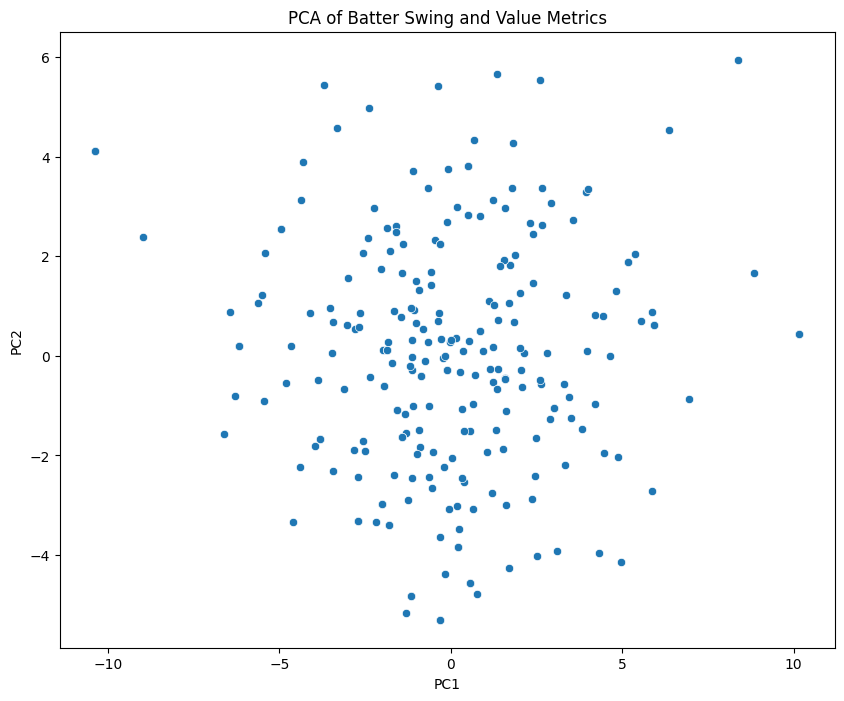

In [20]:
# =========================
# Cell 1: Import libraries
# =========================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Cell 2: Select variables
# =========================

swing_vars = [
    'avg_bat_speed', 'swing_tilt', 'attack_angle', 'attack_direction',
    'ideal_attack_angle_rate', 'avg_intercept_y_vs_plate', 'avg_intercept_y_vs_batter',
    'gb_rate', 'air_rate', 'fb_rate', 'ld_rate',
    'pull_rate', 'straight_rate', 'oppo_rate',
    'pull_gb_rate', 'straight_gb_rate', 'oppo_gb_rate',
    'pull_air_rate', 'straight_air_rate', 'oppo_air_rate'
]

value_vars = ['runs_all', 'xiso', 'xobp', 'brl_percent', 'xwoba', 'woba', 'Rbat', 'Rpos', 'RAA', 'Rrep', 'oRAR', 'oWAR']

selected_vars = swing_vars + value_vars
X = final_df[selected_vars].copy()

# =========================
# Cell 3: Predictive imputation
# =========================

imputer = IterativeImputer(random_state=42)
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame
X_imputed_df = pd.DataFrame(X_imputed, columns=selected_vars, index=final_df.index)

# =========================
# Cell 4: Standardize features
# =========================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_vars, index=final_df.index)

# =========================
# Cell 5: PCA visualization
# =========================

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)

plt.figure(figsize=(10,8))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
plt.title('PCA of Batter Swing and Value Metrics')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [21]:
# =========================
# Cell 6: Analyze PCA Components
# =========================

'''
Identifies which swing/value metrics drive the principal components from dimensionality reduction.  

**Output:**  
- Ranked feature loadings for interpretation  
- Variance explained metrics printed  
'''

feature_names = selected_vars
pc1_loadings = pd.DataFrame({
    'feature': feature_names,
    'pc1_loading': pca.components_[0],
    'pc1_abs_loading': np.abs(pca.components_[0])
}).sort_values('pc1_abs_loading', ascending=False)

pc2_loadings = pd.DataFrame({
    'feature': feature_names,
    'pc2_loading': pca.components_[1],
    'pc2_abs_loading': np.abs(pca.components_[1])
}).sort_values('pc2_abs_loading', ascending=False)

print("PC1 Top Contributing Features:")
print(pc1_loadings.head(10))
print("\nPC2 Top Contributing Features:")
print(pc2_loadings.head(10))

print(f"\nVariance explained by PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")

PC1 Top Contributing Features:
             feature  pc1_loading  pc1_abs_loading
17     pull_air_rate     0.240299         0.240299
9            fb_rate     0.238434         0.238434
11         pull_rate     0.238288         0.238288
15  straight_gb_rate    -0.231186         0.231186
20          runs_all     0.230964         0.230964
21              xiso     0.229711         0.229711
7            gb_rate    -0.224380         0.224380
8           air_rate     0.224380         0.224380
16      oppo_gb_rate    -0.220862         0.220862
25              woba     0.220221         0.220221

PC2 Top Contributing Features:
          feature  pc2_loading  pc2_abs_loading
30           oRAR     0.285746         0.285746
31           oWAR     0.285721         0.285721
26           Rbat     0.281994         0.281994
22           xobp     0.268125         0.268125
28            RAA     0.265719         0.265719
25           woba     0.258799         0.258799
20       runs_all     0.243983         0

#### Performance Metrics Summary  

Calculates key batting statistics from the compiled dataset.  

**Output:**  
Clean table showing mean and standard deviation for each metric  

**Purpose:**  
Provides baseline understanding of hitter performance distributions before clustering analysis  

In [22]:
# Define target stats
performance_stats = ['oWAR', 'runs_all', 'Rbat', 'RAA', "Rrep", 'xwoba']

# Compute mean and std for each
summary_stats = {
    'Statistic': [],
    'Mean': [],
    'Standard Deviation': []
}

for stat in performance_stats:
    if stat in final_df.columns:
        summary_stats['Statistic'].append(stat)
        summary_stats['Mean'].append(final_df[stat].mean())
        summary_stats['Standard Deviation'].append(final_df[stat].std())

# Create summary DataFrame
summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.round(3)

# Display formatted table
print("Summary Statistics:\n")
print(summary_df.to_markdown(index=False))

Summary Statistics:

| Statistic   |   Mean |   Standard Deviation |
|:------------|-------:|---------------------:|
| oWAR        |  1.683 |                1.355 |
| runs_all    |  4.349 |               11.875 |
| Rbat        |  4.058 |               11.221 |
| RAA         |  4.539 |               13.341 |
| Rrep        | 12.667 |                3.826 |
| xwoba       | 51.362 |               28.948 |


### Create Performance Tiers

Classifies batters into 6 performance tiers (Poor to Superstar) using 3 different methodologies.  

**Key Features:**  
1. **Composite Score** - Z-scored average of 6 key metrics (oWAR, xwoba, etc.)  
2. **3 Tiering Approaches**:  
   - *Fractional SD* (0.67σ intervals)  
   - *Percentile-based* (fixed % cutoffs) ← Recommended 
   - *Hybrid* (combines both methods)  
3. **Output Validation** - Shows score ranges and player counts per tier, per method 

**Final Output:**  
- `performance_df` with all tier assignments  
- Detailed comparison of classification methods  
- Saves selected method to final_df in following cell

In [23]:
# =========================
# STEP 1: CREATE 6 PERFORMANCE TIERS (Independent of Swing Clustering)
# =========================
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Define performance variables and extract
performance_vars_for_split = performance_stats
X_performance = final_df.loc[X_imputed_df.index, performance_vars_for_split].fillna(0)

# Create composite score (z-scored across metrics)
performance_scaled = StandardScaler().fit_transform(X_performance)
composite_performance = np.mean(performance_scaled, axis=1)
std_dev = np.std(composite_performance)

print(f"Composite performance stats:")
print(f"Mean: {np.mean(composite_performance):.4f}")
print(f"Std Dev: {std_dev:.4f}")

# =========================
# APPROACH 1: Fractional Standard Deviation (0.67σ)
# =========================
def map_to_performance_tier_fractional(score):
    """Uses 0.67 standard deviations for more granular tiers"""
    if pd.isna(score):
        return 'Average'
    
    std_multiplier = 0.67
    
    if score >= 2 * std_multiplier * std_dev:
        return 'Superstar'
    elif score >= 1 * std_multiplier * std_dev:
        return 'Elite'
    elif score >= 0.5 * std_multiplier * std_dev:
        return 'Above'
    elif score >= -0.5 * std_multiplier * std_dev:
        return 'Average'
    elif score >= -1 * std_multiplier * std_dev:
        return 'Below'
    else:
        return 'Poor'

# =========================
# APPROACH 2: Percentile-Based Approach
# =========================
def map_to_performance_tier_percentile(score, scores_array):
    """Uses percentiles for tier assignment"""
    if pd.isna(score):
        return 'Average'
    
    percentile = (scores_array <= score).mean() * 100
    
    if percentile >= 95:
        return 'Superstar'
    elif percentile >= 85:
        return 'Elite'
    elif percentile >= 65:
        return 'Above'
    elif percentile >= 35:
        return 'Average'
    elif percentile >= 15:
        return 'Below'
    else:
        return 'Poor'

# =========================
# APPROACH 3: Hybrid Approach (Percentiles for extremes, std for middle)
# =========================
def map_to_performance_tier_hybrid(score, scores_array):
    """Combines percentiles for extremes with adjusted standard deviations for middle"""
    if pd.isna(score):
        return 'Average'
    
    percentile = (scores_array <= score).mean() * 100
    
    # Use percentiles for extremes (accounts for truncation)
    if percentile >= 97.5:
        return 'Superstar'
    elif percentile <= 2.5:
        return 'Poor'
    
    # Use adjusted standard deviations for middle tiers
    elif score >= 0.75 * std_dev:
        return 'Elite'
    elif score >= 0.25 * std_dev:
        return 'Above'
    elif score >= -0.25 * std_dev:
        return 'Average'
    else:
        return 'Below'

# =========================
# APPLY ALL THREE APPROACHES AND COMPARE
# =========================

# Approach 1: Fractional Standard Deviation
performance_tiers_fractional = pd.Series(composite_performance, index=X_imputed_df.index).apply(map_to_performance_tier_fractional)

# Approach 2: Percentile-Based
performance_tiers_percentile = pd.Series(composite_performance, index=X_imputed_df.index).apply(
    lambda x: map_to_performance_tier_percentile(x, composite_performance)
)

# Approach 3: Hybrid
performance_tiers_hybrid = pd.Series(composite_performance, index=X_imputed_df.index).apply(
    lambda x: map_to_performance_tier_hybrid(x, composite_performance)
)

# =========================
# BUILD COMPREHENSIVE PERFORMANCE DATAFRAME
# =========================
performance_df = pd.DataFrame(index=X_imputed_df.index)
performance_df['name'] = final_df['name']
performance_df['composite_performance_score'] = composite_performance
performance_df['tier_fractional'] = performance_tiers_fractional
performance_df['tier_percentile'] = performance_tiers_percentile
performance_df['tier_hybrid'] = performance_tiers_hybrid

# For downstream use - updated tier names with Superstar
tier_names = ['Poor', 'Below', 'Average', 'Above', 'Elite', 'Superstar']

# =========================
# COMPARE RESULTS
# =========================
print("\n" + "="*60)
print("PERFORMANCE TIER CLASSIFICATION RESULTS")
print("="*60)

print("\nAPPROACH 1: Fractional Standard Deviation (0.67σ)")
print("-" * 55)
fractional_counts = performance_df['tier_fractional'].value_counts().reindex(tier_names, fill_value=0)
print(fractional_counts)
print(f"Total players: {fractional_counts.sum()}")

print("\nAPPROACH 2: Percentile-Based")
print("-" * 30)
percentile_counts = performance_df['tier_percentile'].value_counts().reindex(tier_names, fill_value=0)
print(percentile_counts)
print(f"Total players: {percentile_counts.sum()}")

print("\nAPPROACH 3: Hybrid (Percentiles + Adjusted Std)")
print("-" * 45)
hybrid_counts = performance_df['tier_hybrid'].value_counts().reindex(tier_names, fill_value=0)
print(hybrid_counts)
print(f"Total players: {hybrid_counts.sum()}")

# =========================
# SELECT FINAL APPROACH (Default to Fractional)
# =========================
# Choose your preferred approach here:
SELECTED_APPROACH = 'percentile'  # Options: 'fractional', 'percentile', 'hybrid'

if SELECTED_APPROACH == 'fractional':
    performance_tiers = performance_tiers_fractional
    print(f"\n🎯 SELECTED APPROACH: Fractional Standard Deviation (0.67σ)")
elif SELECTED_APPROACH == 'percentile':
    performance_tiers = performance_tiers_percentile
    print(f"\n🎯 SELECTED APPROACH: Percentile-Based")
elif SELECTED_APPROACH == 'hybrid':
    performance_tiers = performance_tiers_hybrid
    print(f"\n🎯 SELECTED APPROACH: Hybrid")

# Add selected tiers to main dataframe
performance_df['performance_tier'] = performance_tiers

print("\nFinal Performance Tier Classification:")
print(performance_df['performance_tier'].value_counts().reindex(tier_names, fill_value=0))

# =========================
# VALIDATION: Show score ranges for each tier
# =========================
print("\n" + "="*60)
print("SCORE RANGES BY TIER (Selected Approach)")
print("="*60)

for tier in tier_names:
    tier_scores = performance_df[performance_df['performance_tier'] == tier]['composite_performance_score']
    if len(tier_scores) > 0:
        print(f"{tier:>10}: {tier_scores.min():.3f} to {tier_scores.max():.3f} "
              f"(mean: {tier_scores.mean():.3f}, n={len(tier_scores)})")
    else:
        print(f"{tier:>10}: No players")

print("\nPerformance tier classification complete! 🚀")

Composite performance stats:
Mean: 0.0000
Std Dev: 0.8098

PERFORMANCE TIER CLASSIFICATION RESULTS

APPROACH 1: Fractional Standard Deviation (0.67σ)
-------------------------------------------------------
tier_fractional
Poor         70
Below        30
Average      55
Above        32
Elite        31
Superstar    25
Name: count, dtype: int64
Total players: 243

APPROACH 2: Percentile-Based
------------------------------
tier_percentile
Poor         36
Below        49
Average      72
Above        49
Elite        24
Superstar    13
Name: count, dtype: int64
Total players: 243

APPROACH 3: Hybrid (Percentiles + Adjusted Std)
---------------------------------------------
tier_hybrid
Poor           6
Below        100
Average       37
Above         51
Elite         42
Superstar      7
Name: count, dtype: int64
Total players: 243

🎯 SELECTED APPROACH: Percentile-Based

Final Performance Tier Classification:
performance_tier
Poor         36
Below        49
Average      72
Above        49
Elite

In [24]:
# Merge into final_df
final_df['composite_performance_score'] = performance_df['composite_performance_score'].round(3)
final_df['performance_tier'] = performance_df['performance_tier']

# Swing Clustering

## Feature Analysis Pipeline  

Identifies optimal swing characteristics for batter clustering through comprehensive dimensionality reduction and feature selection.

**Process Flow:**  
1. **Data Preparation**  
   - `prepare_clustering_data()`: Filters/cleans swing metrics, prints dataset stats  
   *(Base function - must run first)*  

2. **Core Analysis Functions**  
   - `analyze_feature_importance()`: Master function coordinating all steps below  
     *(Parent function - calls all sub-functions in order)*  
   - *PCA Analysis*: Computes variance thresholds (90%/95% thresholds)  
   - *Feature Loadings*: Calculates metric contributions to components  
   - *Correlation Check*: Identifies redundant variables (|r|>0.7)  

3. **Supporting Visualizations**  
   - *Variance Plots*: Shows component-wise and cumulative variance  
   - *Heatmaps*: Displays loadings and correlations  
   *(Depend on PCA/correlation results)*  

4. **Feature Selection**  
   - *Variance Ranking*: Orders features by importance scores  
   - *Top Feature Selection*: Recommends optimal subset  
   *(Depends on all previous analysis)*  

**Key Outputs:**  
1. *Visual Diagnostics*:  
   *1. Variance Explained Plot*  
   - Left: Individual component variance bars  
   - Right: Cumulative variance with 90%/95% thresholds  

   *2. Feature Loadings Heatmap*  
   - Color-coded PCA loadings matrix  
   - Shows metric contributions to each component  

   *3. Correlation Matrix*  
   - Highlights |r| > 0.7 relationships  
   - Triangular format reduces redundancy  

2. *Analytical Results*:  
   - Feature variance ranking table  
   - PCA importance scores table  
   - High-correlation alert list (if any)  

3. *Final Recommendation*:  
   - Optimized feature set for clustering (e.g., 4-5 key swing metrics)  
   - `[X]` prioritized features based on 95% variance threshold 

Clustering Data Summary:
Original dataset size: 243
Clustering dataset size (after removing NaN): 243
Variables used: ['avg_bat_speed', 'swing_tilt', 'attack_angle', 'attack_direction', 'avg_intercept_y_vs_batter', 'swing_length']

Descriptive Statistics:
       avg_bat_speed  swing_tilt  attack_angle  attack_direction  \
count     243.000000  243.000000    243.000000        243.000000   
mean       71.828436   32.317428     10.075012         -1.856695   
std         2.601828    3.703605      3.483178          4.140232   
min        62.579000   24.036000      1.512000        -15.020000   
25%        70.277000   29.629500      7.926500         -4.937000   
50%        71.995000   32.305000     10.096000         -1.918000   
75%        73.655000   34.613000     12.031500          1.134000   
max        78.659000   44.759000     19.422000         11.384000   

       avg_intercept_y_vs_batter  swing_length             id  
count                 243.000000    243.000000     243.000000  
mea

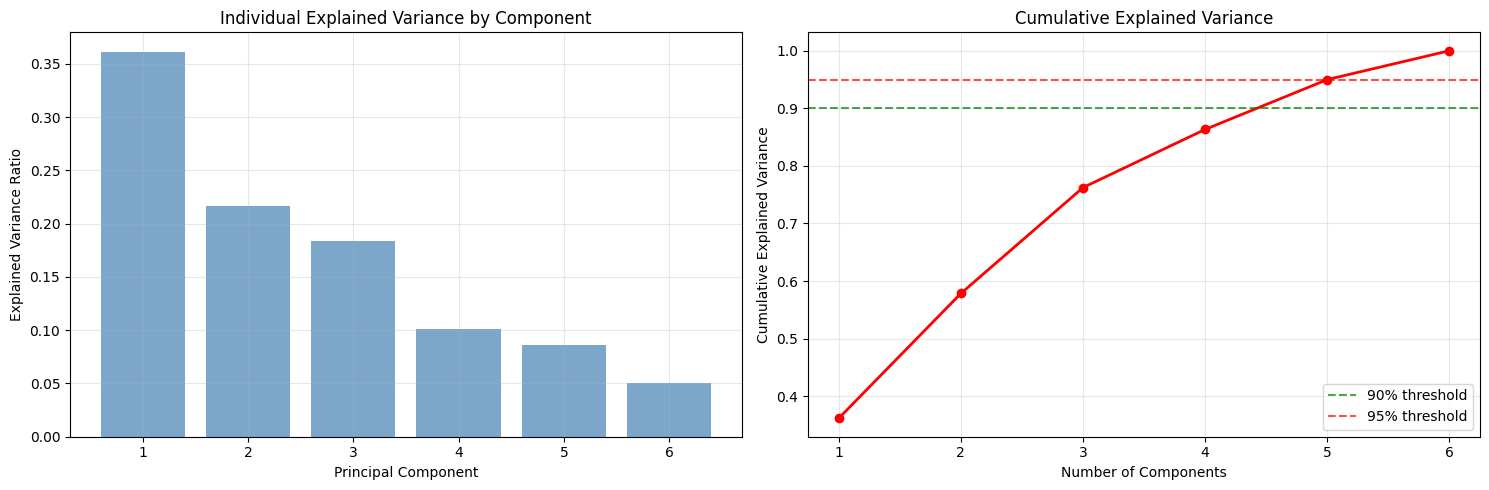


2. Feature Loadings for Top Components:
----------------------------------------
                             PC1    PC2    PC3    PC4    PC5    PC6
avg_bat_speed             -0.419 -0.305 -0.448  0.579 -0.256  0.360
swing_tilt                 0.023  0.771 -0.168  0.071 -0.606 -0.074
attack_angle              -0.386  0.549 -0.039  0.190  0.698  0.156
attack_direction           0.519 -0.002 -0.347  0.534  0.239 -0.518
avg_intercept_y_vs_batter -0.422 -0.054  0.622  0.393 -0.150 -0.504
swing_length               0.476  0.093  0.512  0.429 -0.024  0.564


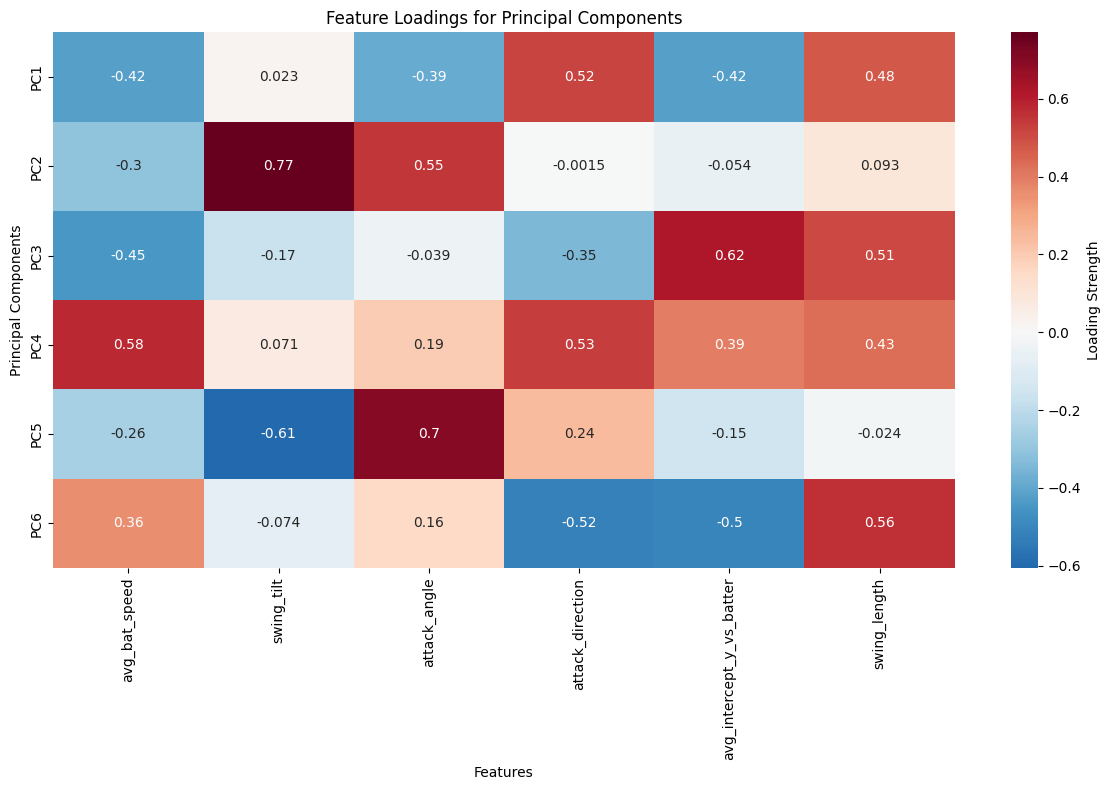


3. Feature Correlation Analysis:
----------------------------------------


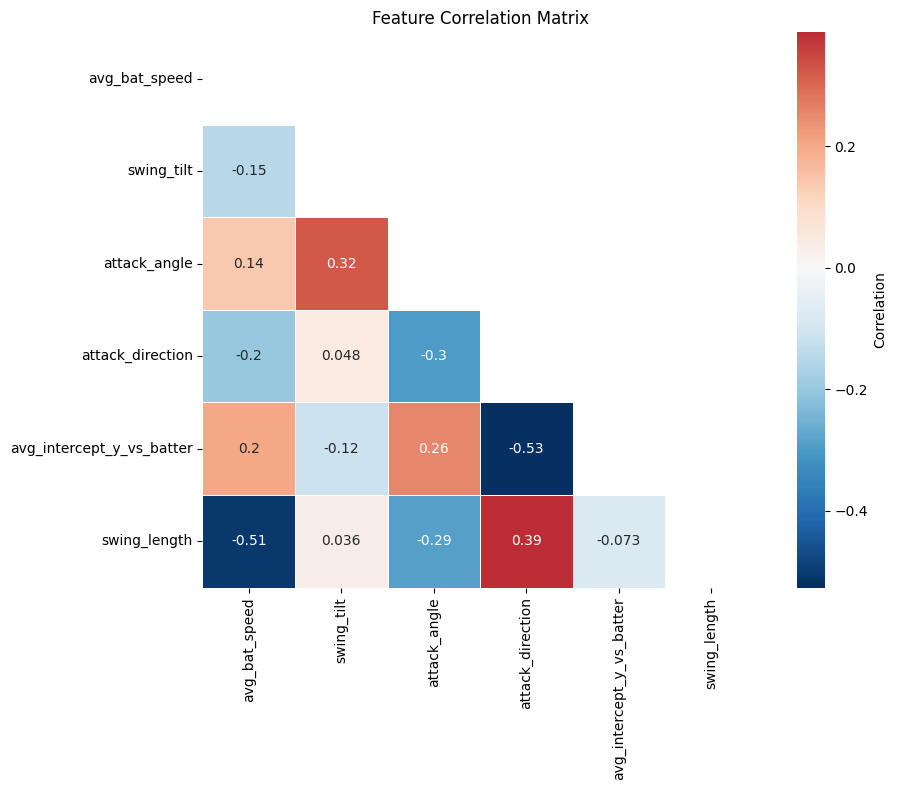


No highly correlated feature pairs found (|r| > 0.7)

4. Feature Variance Analysis:
----------------------------------------
                     Feature  Variance  Std_Dev
3           attack_direction       1.0      1.0
5               swing_length       1.0      1.0
2               attack_angle       1.0      1.0
1                 swing_tilt       1.0      1.0
0              avg_bat_speed       1.0      1.0
4  avg_intercept_y_vs_batter       1.0      1.0

5. Feature Selection Based on PCA Variance Contribution:
----------------------------------------
Feature Importance Ranking (based on PCA contribution):
                     Feature  Importance_Score
0              avg_bat_speed            0.3988
5               swing_length            0.3603
4  avg_intercept_y_vs_batter            0.3569
2               attack_angle            0.3534
3           attack_direction            0.3524
1                 swing_tilt            0.2696

Top 6 features selected based on PCA variance contrib

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

def prepare_clustering_data(swing_df):
    clustering_vars = ['avg_bat_speed', 
                       'swing_tilt', 
                       'attack_angle',
                       'attack_direction', 
                       'avg_intercept_y_vs_batter', 
                       'swing_length']
    
    cluster_data = swing_df[clustering_vars + ['id']].dropna()
    
    print(f"Clustering Data Summary:")
    print(f"Original dataset size: {len(swing_df)}")
    print(f"Clustering dataset size (after removing NaN): {len(cluster_data)}")
    print(f"Variables used: {clustering_vars}")
    print(f"\nDescriptive Statistics:")
    print(cluster_data.describe())
    
    return cluster_data, clustering_vars

def analyze_feature_importance(data, clustering_vars):
    """Analyze which features contribute most to natural clustering patterns"""
    print("\n" + "="*60)
    print("DIMENSIONALITY REDUCTION & FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    
    # Standardize data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[clustering_vars])
    
    # 1. PCA Analysis
    print("\n1. Principal Component Analysis (PCA):")
    print("-" * 40)
    pca = PCA()
    pca_result = pca.fit_transform(data_scaled)
    
    # Calculate cumulative explained variance
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    
    # Find optimal number of components (95% variance)
    n_components_95 = np.argmax(cumvar >= 0.95) + 1
    n_components_90 = np.argmax(cumvar >= 0.90) + 1
    
    print(f"Components needed for 90% variance: {n_components_90}")
    print(f"Components needed for 95% variance: {n_components_95}")
    
    # Plot explained variance
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Individual variance explained
    axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
                pca.explained_variance_ratio_, alpha=0.7, color='steelblue')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_title('Individual Explained Variance by Component')
    axes[0].grid(True, alpha=0.3)
    
    # Cumulative variance
    axes[1].plot(range(1, len(cumvar) + 1), cumvar, 'ro-', linewidth=2, markersize=6)
    axes[1].axhline(y=0.90, color='g', linestyle='--', alpha=0.7, label='90% threshold')
    axes[1].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% threshold')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].set_title('Cumulative Explained Variance')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 2. Feature Loading Analysis
    print("\n2. Feature Loadings for Top Components:")
    print("-" * 40)
    
    # Create DataFrame for feature loadings (using n_components_95)
    loadings_df = pd.DataFrame(
        pca.components_[:n_components_95].T,  # Use n_components_95 instead of fixed 4
        columns=[f'PC{i+1}' for i in range(n_components_95)],
        index=clustering_vars
    )
    
    print(loadings_df.round(3))
    
    # Plot feature loadings heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings_df.T, annot=True, cmap='RdBu_r', center=0, 
                cbar_kws={'label': 'Loading Strength'})
    plt.title('Feature Loadings for Principal Components')
    plt.ylabel('Principal Components')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()
    
    # 3. Correlation Analysis
    print("\n3. Feature Correlation Analysis:")
    print("-" * 40)
    
    corr_matrix = data[clustering_vars].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Identify highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("\nHighly correlated feature pairs (|r| > 0.7):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"  {feat1} - {feat2}: {corr:.3f}")
    else:
        print("\nNo highly correlated feature pairs found (|r| > 0.7)")
    
    # 4. Variance Analysis
    print("\n4. Feature Variance Analysis:")
    print("-" * 40)
    
    feature_vars = pd.DataFrame({
        'Feature': clustering_vars,
        'Variance': np.var(data_scaled, axis=0),
        'Std_Dev': np.std(data_scaled, axis=0)
    }).sort_values('Variance', ascending=False)
    
    print(feature_vars.round(3))
    
    # 5. Select Top Features Based on PCA Contribution
    print("\n5. Feature Selection Based on PCA Variance Contribution:")
    print("-" * 40)
    
    # Calculate feature importance based on weighted contribution across components
    # Weight by explained variance ratio of each component
    feature_importance_scores = np.zeros(len(clustering_vars))
    
    for i in range(n_components_95):
        # Weight loadings by the variance explained by this component
        weighted_loadings = np.abs(pca.components_[i]) * pca.explained_variance_ratio_[i]
        feature_importance_scores += weighted_loadings
    
    # Create DataFrame with feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': clustering_vars,
        'Importance_Score': feature_importance_scores
    }).sort_values('Importance_Score', ascending=False)
    
    print("Feature Importance Ranking (based on PCA contribution):")
    print(feature_importance_df.round(4))
    
    # Select top n_components_95 features
    top_features = feature_importance_df.head(n_components_95)['Feature'].tolist()
    
    print(f"\nTop {n_components_95} features selected based on PCA variance contribution:")
    for i, feature in enumerate(top_features, 1):
        importance = feature_importance_df[feature_importance_df['Feature'] == feature]['Importance_Score'].iloc[0]
        print(f"  {i}. {feature}: {importance:.4f}")
    
    # 6. Recommendations
    print("\n6. Final Feature Selection Summary:")
    print("-" * 40)
    print(f"Original number of features: {len(clustering_vars)}")
    print(f"Components needed for 95% variance: {n_components_95}")
    print(f"Selected features: {len(top_features)}")
    print(f"Variance reduction: {len(clustering_vars) - len(top_features)} features removed")
    
    return {
        'pca_model': pca,
        'scaler': scaler,
        'loadings_df': loadings_df,
        'important_features': top_features,  # Now uses top n_components_95 features
        'n_components_90': n_components_90,
        'n_components_95': n_components_95,
        'feature_vars': feature_vars,
        'feature_importance_df': feature_importance_df
    }

# Execute dimensionality reduction analysis
cluster_data, clustering_vars = prepare_clustering_data(final_df)
dim_results = analyze_feature_importance(cluster_data, clustering_vars)

# Store results for next cell
recommended_features = dim_results['important_features']
print(f"\n🎯 FINAL RECOMMENDATION: Use these {len(recommended_features)} features for clustering:")
print(f"   {recommended_features}")

### Clustering Model Evaluation & Selection  

**Core Analysis Flow:**  
1. **Model Testing** (`streamlined_model_comparison`)  
   - Tests 5 model types (4 GMM variants + K-Means)  
   - Evaluates cluster ranges k=4-14  
   - Outputs 3 validation metrics per configuration  

2. **Results Analysis** (`analyze_streamlined_results`)  
   - Ranks models by:  
     - Silhouette Score (primary)  
     - Calinski-Harabasz  
     - Davies-Bouldin  
   - Identifies best model per cluster count  

3. **Visual Diagnostics** (`visualize_streamlined_results`)  
   *Key Outputs:*  
   - **PCA Cluster Plot Grid**: 20 top models (4x5 grid)  
     - Shows cluster separation in 2D space  
     - Labels include model type, k, and silhouette score  
   - **Metric Trend Charts**: 2x2 grid showing:  
     1. Silhouette by k  
     2. Calinski-Harabasz by k  
     3. Davies-Bouldin by k  
     4. Combined normalized score  

4. **Recommendation Engine** (`find_optimal_models`)  
   - Identifies:  
     - Absolute best performer  
     - Best balanced model (top 10% all metrics)  
     - "Sweet spot" options (k=5-8)  

**Key Output Tables:**  
1. Full results sorted by silhouette score  
2. Top 10 models per metric  
3. Best model for each k  
4. Model performance summary stats  

**Decision Visualizations:**  
- Color-coded PCA projections for top models  
- Metric trend lines across cluster counts  
- Combined score normalization  

**Final Deliverables:**  
1. Clear top model recommendations  
2. Visual evidence for selection  
3. Performance tradeoff analysis  

Starting streamlined model comparison (k=4-14)...

STREAMLINED CLUSTERING MODEL COMPARISON (k=4-14)

Using 6 features: ['avg_bat_speed', 'swing_length', 'avg_intercept_y_vs_batter', 'attack_angle', 'attack_direction', 'swing_tilt']
Data shape: (243, 6)
Testing cluster range: k=4 to k=14

GMM_TIED:
--------------------------------------------------
   k= 4: Sil=0.128, CH=  37.6, DB=1.808
   k= 5: Sil=0.121, CH=  36.8, DB=1.731
   k= 6: Sil=0.121, CH=  33.3, DB=1.727
   k= 7: Sil=0.115, CH=  31.3, DB=1.889
   k= 8: Sil=0.117, CH=  29.2, DB=1.854
   k= 9: Sil=0.086, CH=  26.1, DB=1.812
   k=10: Sil=0.076, CH=  24.3, DB=1.949
   k=11: Sil=0.093, CH=  26.2, DB=1.832
   k=12: Sil=0.104, CH=  27.3, DB=1.793
   k=13: Sil=0.108, CH=  26.5, DB=1.626
   k=14: Sil=0.113, CH=  24.8, DB=1.589

GMM_SPHERICAL:
--------------------------------------------------
   k= 4: Sil=0.160, CH=  51.5, DB=1.667
   k= 5: Sil=0.153, CH=  47.6, DB=1.594
   k= 6: Sil=0.139, CH=  43.1, DB=1.533
   k= 7: Sil=0.139, CH=

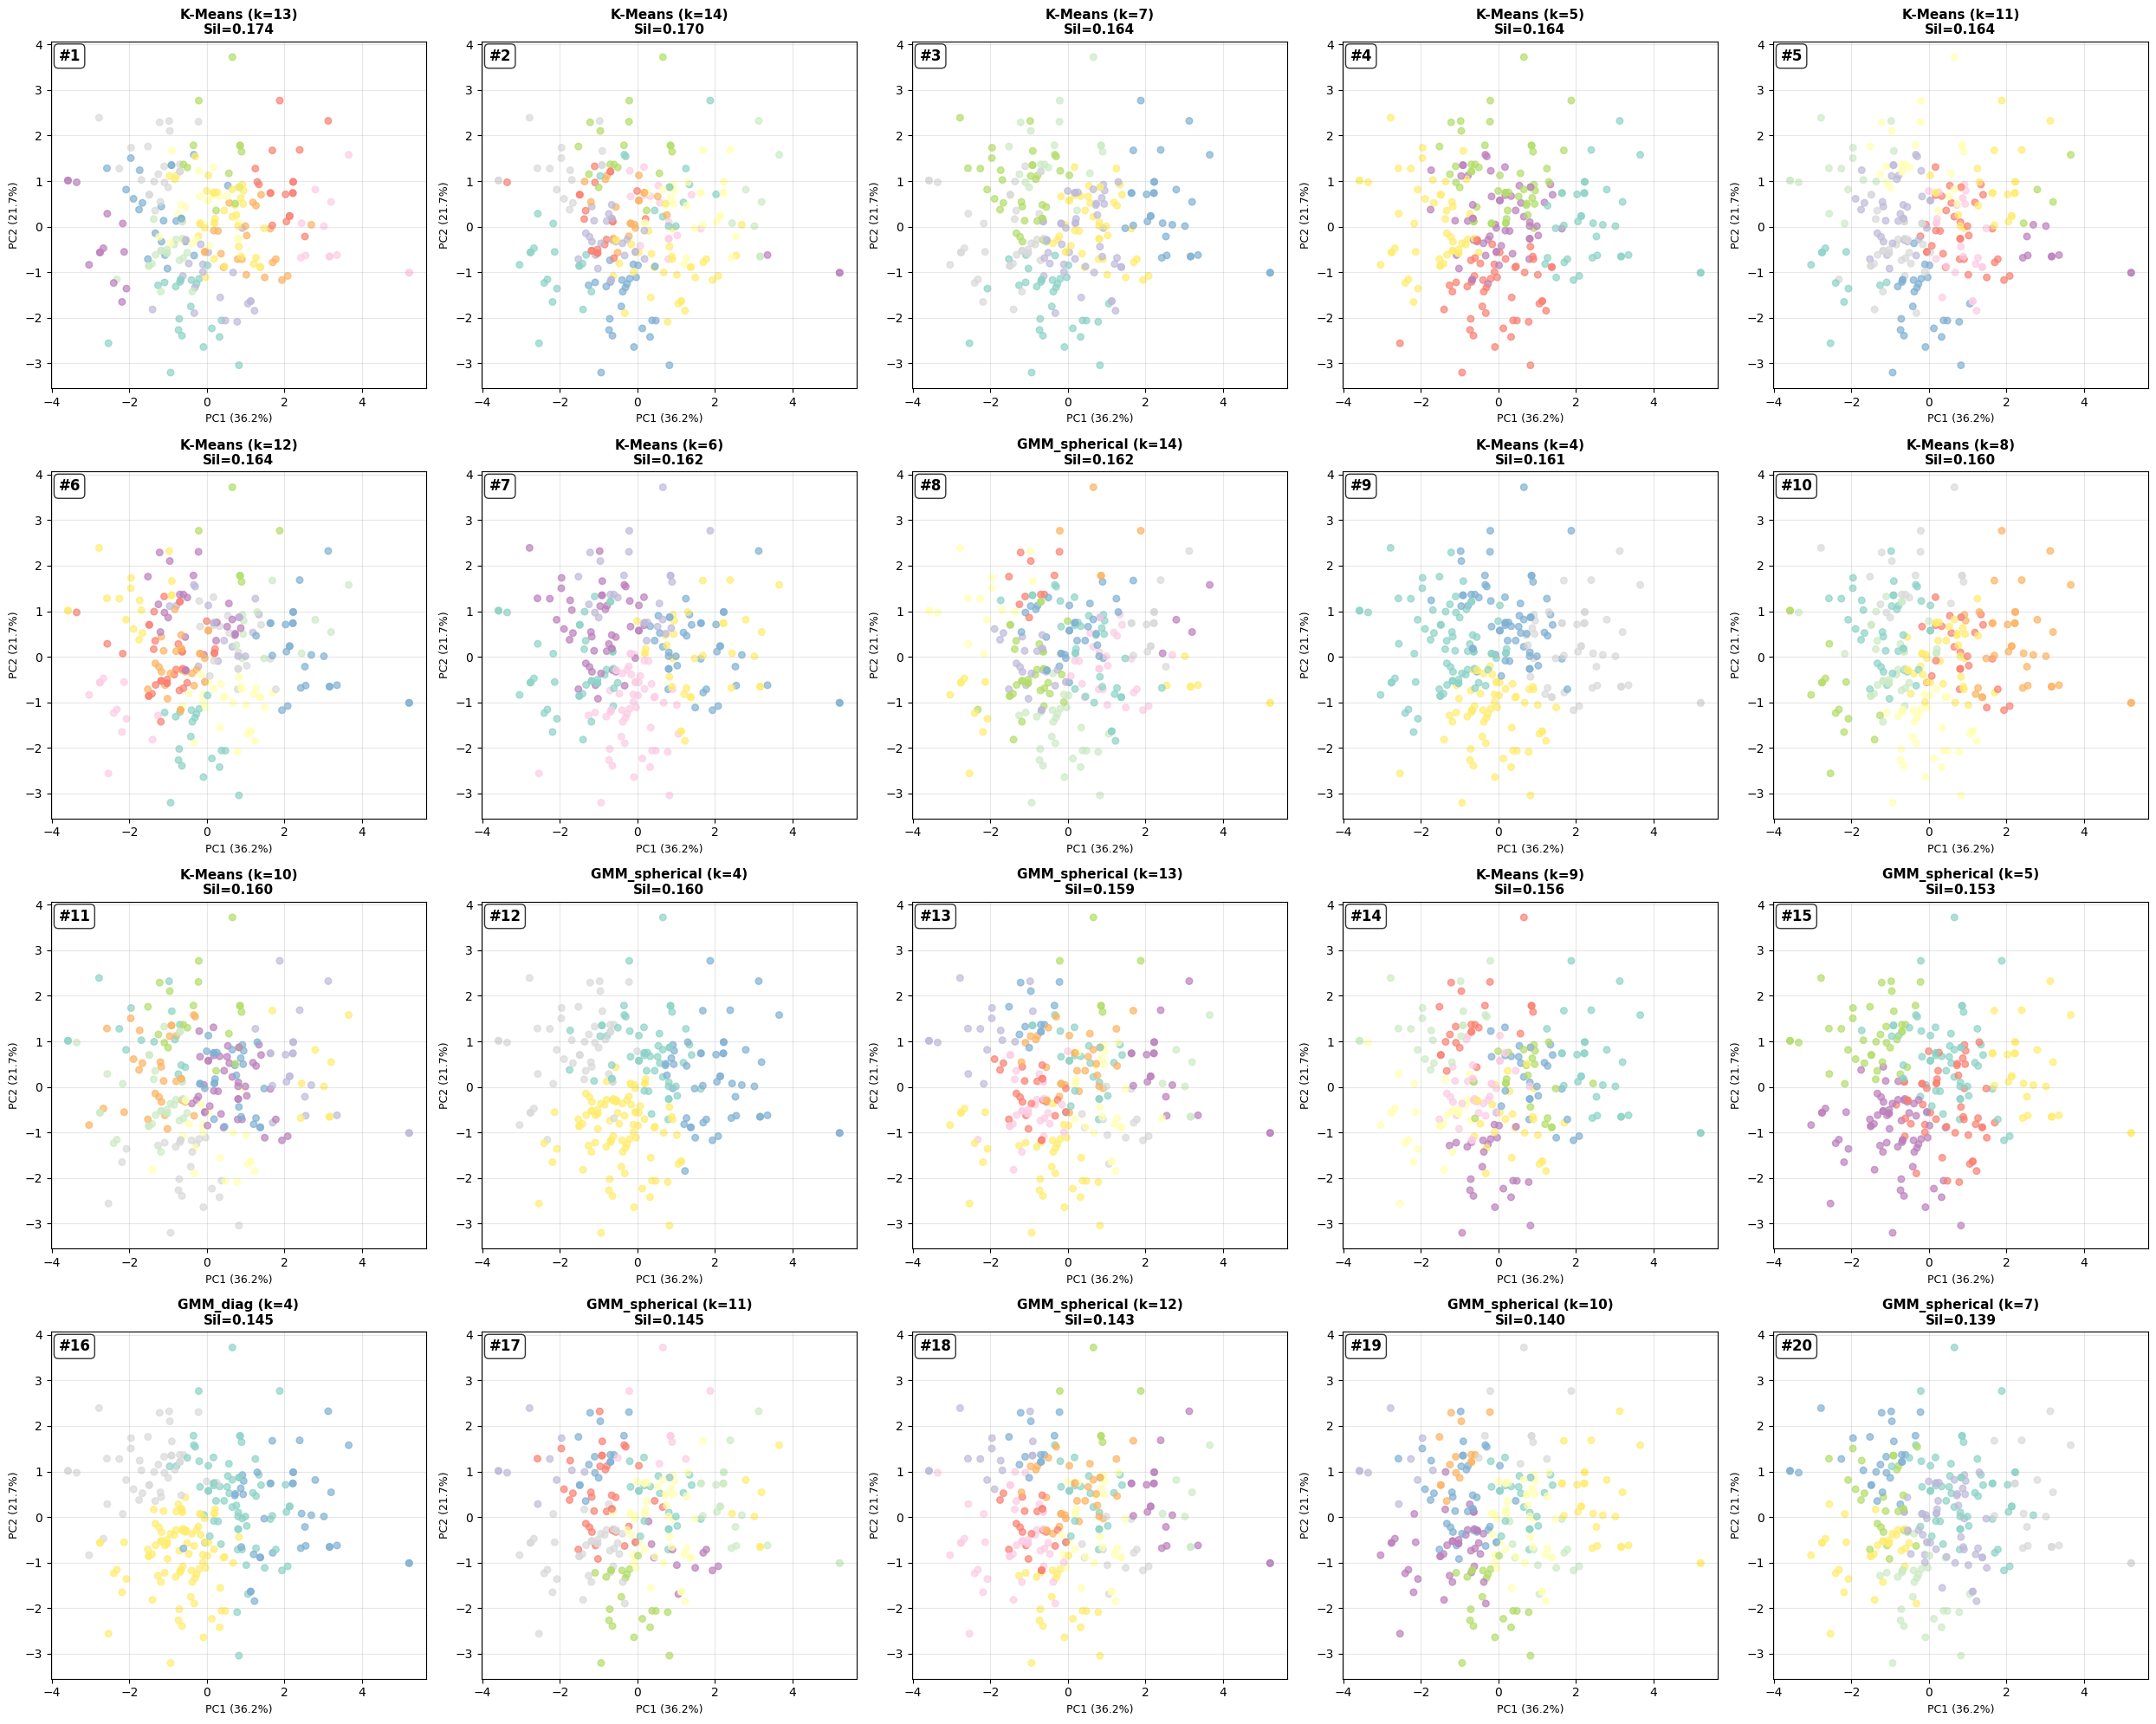


7. PERFORMANCE TRENDS BY k:
--------------------------------------------------


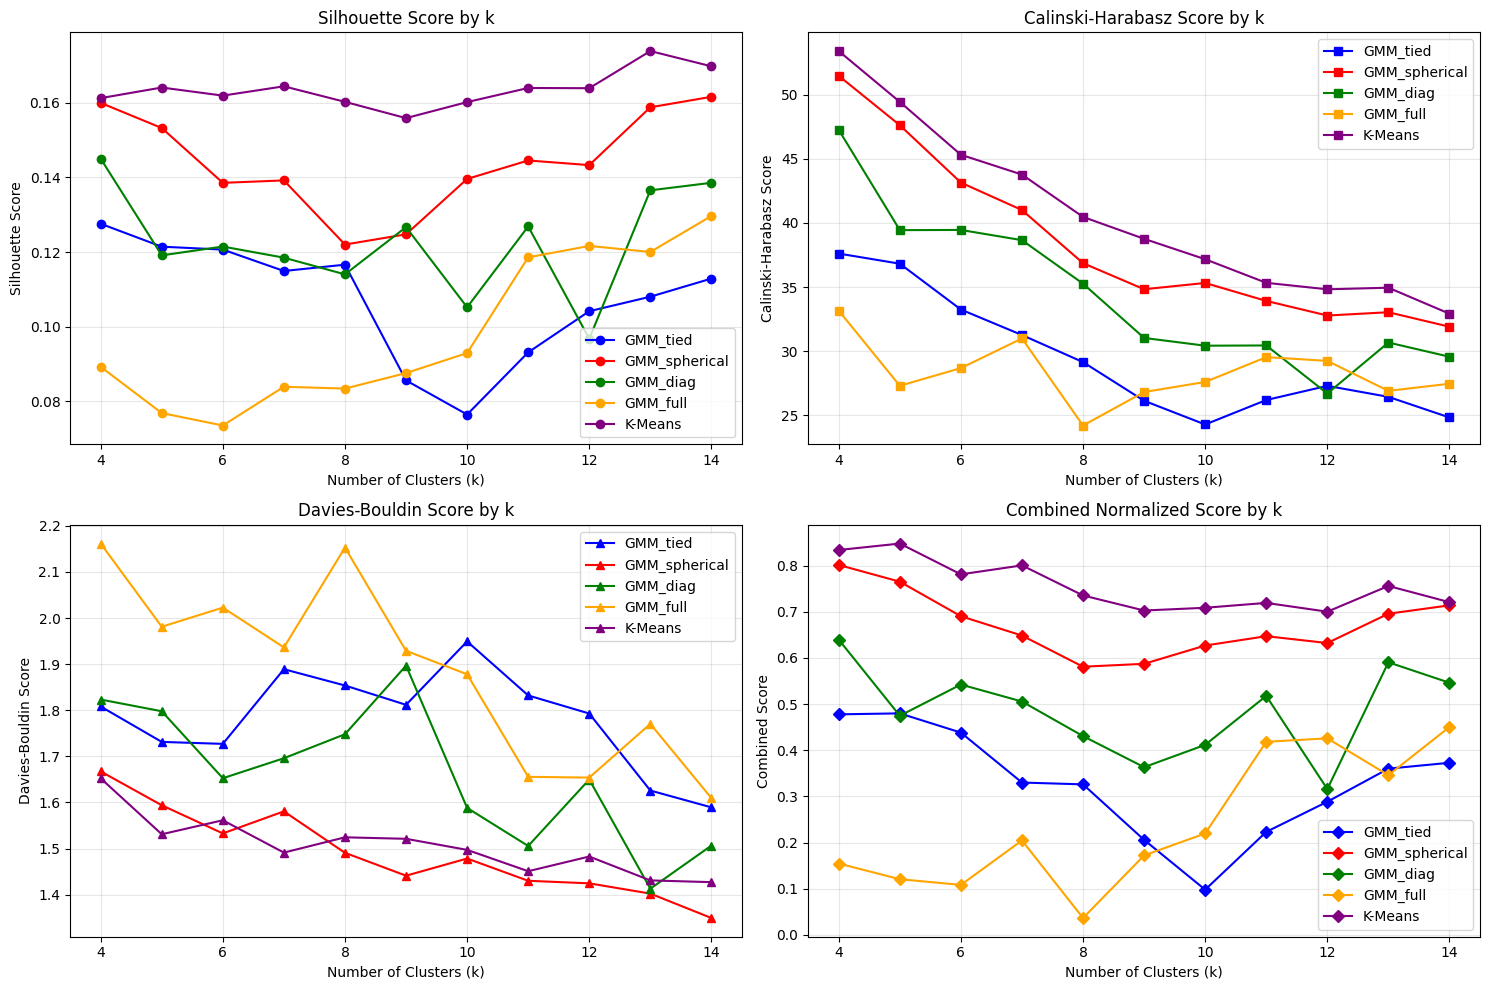


8. 🎯 OPTIMAL MODEL RECOMMENDATIONS:

1. BEST OVERALL (Silhouette Score):
   K-Means with k=13
   Silhouette: 0.174
   Calinski-Harabasz: 35.0
   Davies-Bouldin: 1.431

2. BEST BALANCED MODELS (Top 10% in all metrics):
   No models meet all criteria. Relaxing requirements...

3. SWEET SPOT ANALYSIS (k=5-8):
   1. K-Means (k=7): Sil=0.164, CH=43.8, DB=1.491
   2. K-Means (k=5): Sil=0.164, CH=49.4, DB=1.531
   3. K-Means (k=6): Sil=0.162, CH=45.3, DB=1.561
   4. K-Means (k=8): Sil=0.160, CH=40.5, DB=1.524
   5. GMM_spherical (k=5): Sil=0.153, CH=47.6, DB=1.594

4. 🏆 FINAL RECOMMENDATIONS:
--------------------------------------------------
Based on the comprehensive analysis:
• Top Overall: K-Means (k=13)
• Sweet Spot: K-Means (k=7)

🎯 STREAMLINED ANALYSIS COMPLETE!
Total models tested: 55
Focus on the top performers and choose based on your specific needs!
The visualizations and metrics will guide you to the best choice.


In [26]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def streamlined_model_comparison(data, features, k_range=range(4, 15)):
    """Compare only the most promising clustering models (GMM variants + K-Means)"""
    print("\n" + "="*70)
    print("STREAMLINED CLUSTERING MODEL COMPARISON (k=4-14)")
    print("="*70)
    
    # Prepare data
    X = data[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store all results
    results = []
    
    print(f"\nUsing {len(features)} features: {features}")
    print(f"Data shape: {X_scaled.shape}")
    print(f"Testing cluster range: k={k_range.start} to k={k_range.stop-1}")
    
    # Focus on the most promising models only
    models_to_test = [
        ('GMM_tied', 'tied'),
        ('GMM_spherical', 'spherical'), 
        ('GMM_diag', 'diag'),
        ('GMM_full', 'full'),  # Adding full back as it was competitive
        ('K-Means', None)
    ]
    
    for model_name, cov_type in models_to_test:
        print(f"\n{model_name.upper()}:")
        print("-" * 50)
        
        for k in k_range:
            try:
                if model_name == 'K-Means':
                    # K-Means
                    model = KMeans(n_clusters=k, random_state=42, n_init=10)
                    labels = model.fit_predict(X_scaled)
                else:
                    # GMM variants
                    model = GaussianMixture(n_components=k, covariance_type=cov_type, 
                                          random_state=42, reg_covar=1e-6)
                    labels = model.fit_predict(X_scaled)
                
                # Calculate metrics
                sil_score = silhouette_score(X_scaled, labels)
                cal_score = calinski_harabasz_score(X_scaled, labels)
                db_score = davies_bouldin_score(X_scaled, labels)
                
                # Store results
                result = {
                    'model': model_name,
                    'k': k,
                    'silhouette': sil_score,
                    'calinski_harabasz': cal_score,
                    'davies_bouldin': db_score,
                    'n_clusters_found': len(np.unique(labels)),
                    'labels': labels,
                    'model_obj': model
                }
                results.append(result)
                
                print(f"   k={k:2d}: Sil={sil_score:.3f}, CH={cal_score:6.1f}, DB={db_score:.3f}")
                
            except Exception as e:
                print(f"   k={k:2d}: Failed - {str(e)}")
    
    return results, X_scaled, scaler

def analyze_streamlined_results(results):
    """Analyze and rank the streamlined clustering results"""
    print("\n" + "="*70)
    print("STREAMLINED RESULTS ANALYSIS")
    print("="*70)
    
    # Convert results to DataFrame
    df_results = pd.DataFrame(results)
    
    # Sort by silhouette score for initial view
    df_sorted = df_results.sort_values('silhouette', ascending=False)
    
    # Display all results
    print("\n🔍 ALL RESULTS (Sorted by Silhouette Score):")
    print("-" * 70)
    print(f"{'Model':<15} {'k':<3} {'Silhouette':<11} {'Calinski-H':<11} {'Davies-B':<10}")
    print("-" * 70)
    
    for _, row in df_sorted.iterrows():
        print(f"{row['model']:<15} {row['k']:<3} {row['silhouette']:<11.3f} "
              f"{row['calinski_harabasz']:<11.1f} {row['davies_bouldin']:<10.3f}")
    
    # Top performers by metric
    print("\n📊 TOP 10 BY EACH METRIC:")
    print("=" * 70)
    
    print("\n1. TOP 10 BY SILHOUETTE SCORE:")
    print("-" * 50)
    top_sil = df_sorted.head(10)
    for i, (_, row) in enumerate(top_sil.iterrows(), 1):
        print(f"  {i:2d}. {row['model']:<15} (k={row['k']:<2d}): "
              f"Sil={row['silhouette']:.3f}, CH={row['calinski_harabasz']:.1f}, DB={row['davies_bouldin']:.3f}")
    
    print("\n2. TOP 10 BY CALINSKI-HARABASZ SCORE:")
    print("-" * 50)
    top_cal = df_results.nlargest(10, 'calinski_harabasz')
    for i, (_, row) in enumerate(top_cal.iterrows(), 1):
        print(f"  {i:2d}. {row['model']:<15} (k={row['k']:<2d}): "
              f"Sil={row['silhouette']:.3f}, CH={row['calinski_harabasz']:.1f}, DB={row['davies_bouldin']:.3f}")
    
    print("\n3. TOP 10 BY DAVIES-BOULDIN SCORE (lower is better):")
    print("-" * 50)
    top_db = df_results.nsmallest(10, 'davies_bouldin')
    for i, (_, row) in enumerate(top_db.iterrows(), 1):
        print(f"  {i:2d}. {row['model']:<15} (k={row['k']:<2d}): "
              f"Sil={row['silhouette']:.3f}, CH={row['calinski_harabasz']:.1f}, DB={row['davies_bouldin']:.3f}")
    
    # Best model for each k
    print("\n4. BEST MODEL FOR EACH k (by Silhouette):")
    print("-" * 50)
    best_per_k = df_results.loc[df_results.groupby('k')['silhouette'].idxmax()]
    best_per_k = best_per_k.sort_values('k')
    
    for _, row in best_per_k.iterrows():
        print(f"  k={row['k']:2d}: {row['model']:<15} - "
              f"Sil={row['silhouette']:.3f}, CH={row['calinski_harabasz']:.1f}, DB={row['davies_bouldin']:.3f}")
    
    # Model performance summary
    print("\n5. MODEL PERFORMANCE SUMMARY:")
    print("-" * 50)
    model_summary = df_results.groupby('model').agg({
        'silhouette': ['mean', 'max', 'std'],
        'calinski_harabasz': ['mean', 'max', 'std'],
        'davies_bouldin': ['mean', 'min', 'std']
    }).round(3)
    
    print("\nAverage Performance by Model:")
    for model in df_results['model'].unique():
        model_data = df_results[df_results['model'] == model]
        avg_sil = model_data['silhouette'].mean()
        max_sil = model_data['silhouette'].max()
        avg_cal = model_data['calinski_harabasz'].mean()
        max_cal = model_data['calinski_harabasz'].max()
        avg_db = model_data['davies_bouldin'].mean()
        min_db = model_data['davies_bouldin'].min()
        
        print(f"  {model:<15}: Avg_Sil={avg_sil:.3f} (Max={max_sil:.3f}), "
              f"Avg_CH={avg_cal:.1f} (Max={max_cal:.1f}), Avg_DB={avg_db:.3f} (Min={min_db:.3f})")
    
    return df_sorted, best_per_k

def visualize_streamlined_results(results, X_scaled, data, features):
    """Create focused visualizations for the streamlined results"""
    print("\n6. VISUALIZATION:")
    print("-" * 50)
    
    # Create PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Get top 20 models by silhouette score
    df_results = pd.DataFrame(results)
    top_models = df_results.nlargest(20, 'silhouette')
    
    # Create subplot for top models
    fig, axes = plt.subplots(4, 5, figsize=(25, 20))
    axes = axes.flatten()
    
    for i, (_, result) in enumerate(top_models.iterrows()):
        if i < 20:
            labels = result['labels']
            
            # Plot
            scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, 
                                    cmap='Set3', alpha=0.7, s=30)
            
            # Title with metrics
            title = f"{result['model']} (k={result['k']})"
            subtitle = f"Sil={result['silhouette']:.3f}"
            axes[i].set_title(f"{title}\n{subtitle}", fontsize=11, fontweight='bold')
            axes[i].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=9)
            axes[i].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=9)
            axes[i].grid(True, alpha=0.3)
            
            # Add rank number
            axes[i].text(0.02, 0.98, f"#{i+1}", transform=axes[i].transAxes, 
                        fontsize=12, fontweight='bold', ha='left', va='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Performance trends by k
    print("\n7. PERFORMANCE TRENDS BY k:")
    print("-" * 50)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    models = df_results['model'].unique()
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, model in enumerate(models):
        model_data = df_results[df_results['model'] == model].sort_values('k')
        color = colors[i % len(colors)]
        
        # Silhouette score
        axes[0, 0].plot(model_data['k'], model_data['silhouette'], 
                       marker='o', label=model, color=color)
        
        # Calinski-Harabasz score
        axes[0, 1].plot(model_data['k'], model_data['calinski_harabasz'], 
                       marker='s', label=model, color=color)
        
        # Davies-Bouldin score
        axes[1, 0].plot(model_data['k'], model_data['davies_bouldin'], 
                       marker='^', label=model, color=color)
        
        # Combined score (normalized)
        # Normalize metrics to 0-1 scale for combination
        sil_norm = (model_data['silhouette'] - df_results['silhouette'].min()) / (df_results['silhouette'].max() - df_results['silhouette'].min())
        cal_norm = (model_data['calinski_harabasz'] - df_results['calinski_harabasz'].min()) / (df_results['calinski_harabasz'].max() - df_results['calinski_harabasz'].min())
        db_norm = 1 - (model_data['davies_bouldin'] - df_results['davies_bouldin'].min()) / (df_results['davies_bouldin'].max() - df_results['davies_bouldin'].min())
        
        combined_score = (sil_norm + cal_norm + db_norm) / 3
        axes[1, 1].plot(model_data['k'], combined_score, 
                       marker='D', label=model, color=color)
    
    axes[0, 0].set_title('Silhouette Score by k')
    axes[0, 0].set_xlabel('Number of Clusters (k)')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Calinski-Harabasz Score by k')
    axes[0, 1].set_xlabel('Number of Clusters (k)')
    axes[0, 1].set_ylabel('Calinski-Harabasz Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Davies-Bouldin Score by k')
    axes[1, 0].set_xlabel('Number of Clusters (k)')
    axes[1, 0].set_ylabel('Davies-Bouldin Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Combined Normalized Score by k')
    axes[1, 1].set_xlabel('Number of Clusters (k)')
    axes[1, 1].set_ylabel('Combined Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return top_models

def find_optimal_models(results):
    """Find the optimal models based on different criteria"""
    print("\n8. 🎯 OPTIMAL MODEL RECOMMENDATIONS:")
    print("=" * 70)
    
    df_results = pd.DataFrame(results)
    
    # 1. Best overall by silhouette
    best_sil = df_results.loc[df_results['silhouette'].idxmax()]
    print(f"\n1. BEST OVERALL (Silhouette Score):")
    print(f"   {best_sil['model']} with k={best_sil['k']}")
    print(f"   Silhouette: {best_sil['silhouette']:.3f}")
    print(f"   Calinski-Harabasz: {best_sil['calinski_harabasz']:.1f}")
    print(f"   Davies-Bouldin: {best_sil['davies_bouldin']:.3f}")
    
    # 2. Best balanced (top 10% in all metrics)
    sil_threshold = df_results['silhouette'].quantile(0.9)
    cal_threshold = df_results['calinski_harabasz'].quantile(0.9)
    db_threshold = df_results['davies_bouldin'].quantile(0.1)  # Lower is better
    
    balanced_models = df_results[
        (df_results['silhouette'] >= sil_threshold) & 
        (df_results['calinski_harabasz'] >= cal_threshold) & 
        (df_results['davies_bouldin'] <= db_threshold)
    ].sort_values('silhouette', ascending=False)
    
    print(f"\n2. BEST BALANCED MODELS (Top 10% in all metrics):")
    if len(balanced_models) > 0:
        for i, (_, row) in enumerate(balanced_models.head(5).iterrows(), 1):
            print(f"   {i}. {row['model']} (k={row['k']}): "
                  f"Sil={row['silhouette']:.3f}, CH={row['calinski_harabasz']:.1f}, DB={row['davies_bouldin']:.3f}")
    else:
        print("   No models meet all criteria. Relaxing requirements...")
        # Relax to top 20%
        sil_threshold = df_results['silhouette'].quantile(0.8)
        cal_threshold = df_results['calinski_harabasz'].quantile(0.8)
        db_threshold = df_results['davies_bouldin'].quantile(0.2)
        
        balanced_models = df_results[
            (df_results['silhouette'] >= sil_threshold) & 
            (df_results['calinski_harabasz'] >= cal_threshold) & 
            (df_results['davies_bouldin'] <= db_threshold)
        ].sort_values('silhouette', ascending=False)
        
        for i, (_, row) in enumerate(balanced_models.head(5).iterrows(), 1):
            print(f"   {i}. {row['model']} (k={row['k']}): "
                  f"Sil={row['silhouette']:.3f}, CH={row['calinski_harabasz']:.1f}, DB={row['davies_bouldin']:.3f}")
    
    # 3. Sweet spot analysis (k=5-8 typically good for many applications)
    print(f"\n3. SWEET SPOT ANALYSIS (k=5-8):")
    sweet_spot = df_results[df_results['k'].between(5, 8)].sort_values('silhouette', ascending=False)
    for i, (_, row) in enumerate(sweet_spot.head(5).iterrows(), 1):
        print(f"   {i}. {row['model']} (k={row['k']}): "
              f"Sil={row['silhouette']:.3f}, CH={row['calinski_harabasz']:.1f}, DB={row['davies_bouldin']:.3f}")
    
    print(f"\n4. 🏆 FINAL RECOMMENDATIONS:")
    print("-" * 50)
    print("Based on the comprehensive analysis:")
    print(f"• Top Overall: {best_sil['model']} (k={best_sil['k']})")
    if len(balanced_models) > 0:
        top_balanced = balanced_models.iloc[0]
        print(f"• Best Balanced: {top_balanced['model']} (k={top_balanced['k']})")
    top_sweet_spot = sweet_spot.iloc[0]
    print(f"• Sweet Spot: {top_sweet_spot['model']} (k={top_sweet_spot['k']})")
    
    return best_sil, balanced_models, sweet_spot

# Execute the streamlined analysis
print("Starting streamlined model comparison (k=4-14)...")
results, X_scaled, scaler = streamlined_model_comparison(cluster_data, recommended_features, k_range=range(4, 15))

# Analyze results
df_sorted, best_per_k = analyze_streamlined_results(results)

# Visualize results
top_models = visualize_streamlined_results(results, X_scaled, cluster_data, recommended_features)

# Find optimal models
best_overall, balanced_models, sweet_spot_models = find_optimal_models(results)

print(f"\n{'='*70}")
print("🎯 STREAMLINED ANALYSIS COMPLETE!")
print(f"{'='*70}")
print(f"Total models tested: {len(results)}")
print("Focus on the top performers and choose based on your specific needs!")
print("The visualizations and metrics will guide you to the best choice.")

## Single Model Clustering Visualization  

**Core Components:**  
1. **Model Fitting**  
   - GMM (4 covariance types) or K-Means  
   - Standardized features  
   - User-specified cluster count (k)  

2. **Diagnostic Visualizations**  
   - *PCA Projection*: 2D cluster separation  
     - Shows % variance explained per component  
     - Color-coded by cluster  
   - *Size Distribution*: Bar chart of player counts per cluster  

3. **Analytical Outputs**  
   - *Summary Table*: Mean ± std for 6 key swing metrics  
     - avg_bat_speed  
     - swing_tilt  
     - attack_angle  
     - attack_direction  
     - avg_intercept_y_vs_batter  
     - swing_length  

**Key Parameters:**  
- `model_type`: 'gmm' or 'kmeans'  
- `cov_type`: GMM covariance structure  
- `k`: Number of clusters  

**Example Output:**  
```python
# Returns:
clustered_data  # Original data + cluster labels  
fitted_model    # Trained model object  
cluster_summary # Formatted stats table  
```

### K-Means Model

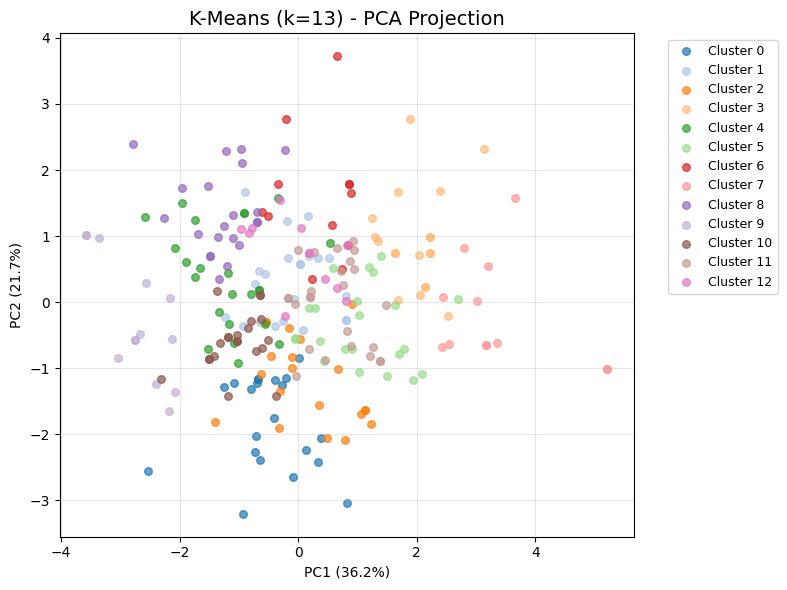


🔢 Cluster Sizes:


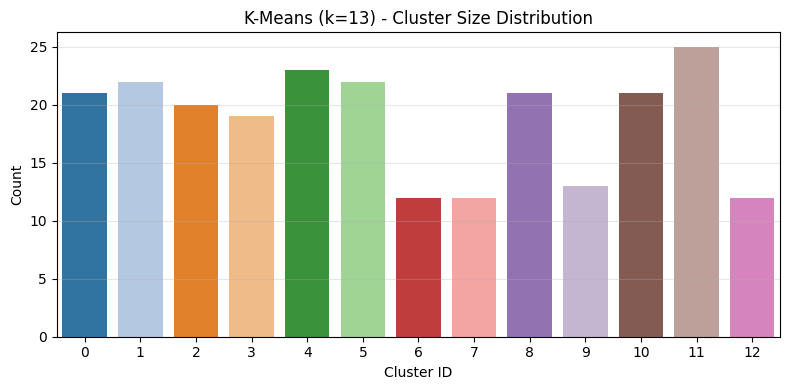


📋 Cluster Feature Summary Table (Mean ± Std):


avg_bat_speed    swing_tilt  attack_angle attack_direction  \
cluster                                                              
0        74.12 ± 1.68   27.64 ± 2.3   6.97 ± 2.35     -1.45 ± 2.63   
1        70.86 ± 1.26  31.59 ± 2.21  12.58 ± 1.97     -0.68 ± 2.58   
2         73.27 ± 1.4  29.25 ± 2.98   7.51 ± 2.39      -0.7 ± 1.81   
3        69.02 ± 1.28  35.67 ± 2.79   8.47 ± 1.62      1.08 ± 2.32   
4         73.99 ± 1.6  34.42 ± 2.24  11.82 ± 2.49     -4.63 ± 2.49   
5        72.96 ± 1.49  31.68 ± 2.13   8.97 ± 1.79      3.12 ± 2.73   
6        72.49 ± 1.68  37.11 ± 3.22  13.76 ± 2.76      1.43 ± 1.96   
7         66.38 ± 2.4  32.03 ± 2.79   4.03 ± 1.83      3.96 ± 4.65   
8        71.22 ± 1.57   35.01 ± 2.1  15.12 ± 2.26      -4.4 ± 1.93   
9        74.74 ± 2.52   31.55 ± 2.2  12.56 ± 3.11     -7.99 ± 2.48   
10       71.71 ± 1.05  29.64 ± 2.36  10.08 ± 1.96      -7.07 ± 2.4   
11       69.86 ± 1.57  31.11 ± 2.51   9.56 ± 1.53     -2.88 ± 1.83   
12       72.45 ± 1.88  37.61 ± 2.01   8.33 ± 1.78     -1.89 ± 2.89   

        avg_intercept_y_vs_batter   swing_length  
cluster                                           
0                    31.01 ± 2.01  19.14 ± 11.04  
1                    29.01 ± 2.41  25.05 ± 11.34  
2                     33.73 ± 2.4  68.55 ± 15.17  
3                    26.53 ± 1.79  75.63 ± 13.94  
4                    28.33 ± 2.16  12.26 ± 10.13  
5                    27.33 ± 2.22  53.86 ± 19.16  
6                     31.6 ± 1.66  78.75 ± 11.79  
7                    28.23 ± 3.72   94.75 ± 6.14  
8                    34.61 ± 2.08  44.29 ± 25.17  
9                    35.66 ± 1.65  10.62 ± 10.32  
10                   33.84 ± 2.23   46.9 ± 18.91  
11                   30.57 ± 1.39   69.2 ± 17.43  
12                   29.74 ± 2.39  32.83 ± 18.02

In [29]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def analyze_single_clustering_model(data, features, model_type='gmm', cov_type='spherical', k=7):
    """
    Fit and visualize a single clustering model (GMM or KMeans).
    Includes PCA plot, cluster size bar chart, and cluster-wise summary table.
    """
    X = data[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    if model_type == 'gmm':
        model = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
        labels = model.fit_predict(X_scaled)
        title = f"GMM ({cov_type}, k={k})"
    elif model_type == 'kmeans':
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X_scaled)
        title = f"K-Means (k={k})"
    else:
        raise ValueError("model_type must be 'gmm' or 'kmeans'")

    data_clustered = data.copy()
    data_clustered['cluster'] = labels

    # Color palette
    palette = sns.color_palette("tab20", k)

    # === PCA Projection ===
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    for cluster_id in range(k):
        idx = labels == cluster_id
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=30, alpha=0.7,
                    color=palette[cluster_id], label=f"Cluster {cluster_id}")
    plt.title(f"{title} - PCA Projection", fontsize=14)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # === Cluster Sizes ===
    print("\n🔢 Cluster Sizes:")
    cluster_sizes = data_clustered['cluster'].value_counts().sort_index()

    plt.figure(figsize=(8, 4))
    sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette=palette)
    plt.title(f"{title} - Cluster Size Distribution")
    plt.xlabel("Cluster ID")
    plt.ylabel("Count")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # === Summary Table (Mean ± Std for Selected Vars) ===
    print("\n📋 Cluster Feature Summary Table (Mean ± Std):")

    summary_vars = [
        'avg_bat_speed',
        'swing_tilt',
        'attack_angle',
        'attack_direction',
        'avg_intercept_y_vs_batter',
        'swing_length'
    ]

    grouped = data_clustered.groupby('cluster')[summary_vars]
    mean_df = grouped.mean().round(2)
    std_df = grouped.std().round(2)

    summary_df = mean_df.astype(str) + " ± " + std_df.astype(str)

    display(summary_df)


    return data_clustered, model, summary_df


# === KMeans Usage ===
clustered_data, fitted_model, cluster_summary = analyze_single_clustering_model(
    cluster_data,
    recommended_features,
    model_type='kmeans',
    k=13
)

### GMM (Spherical) Model

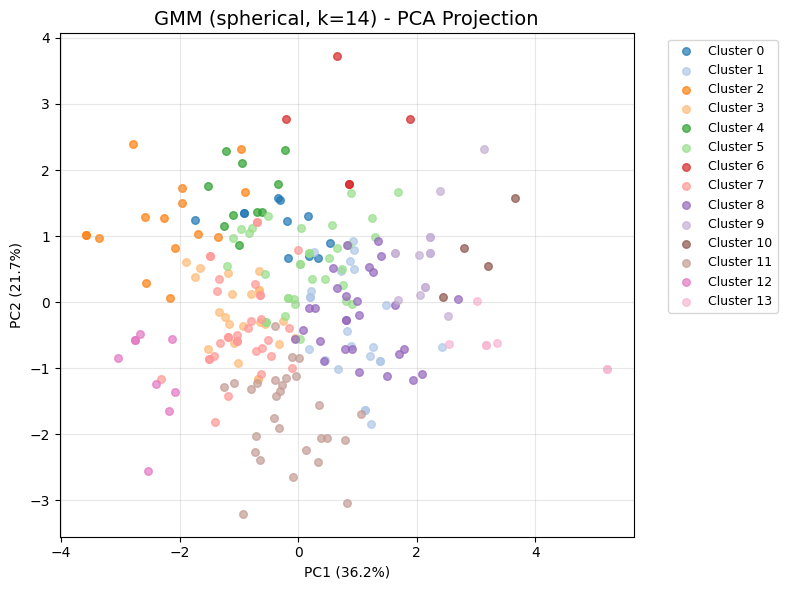


🔢 Cluster Sizes:


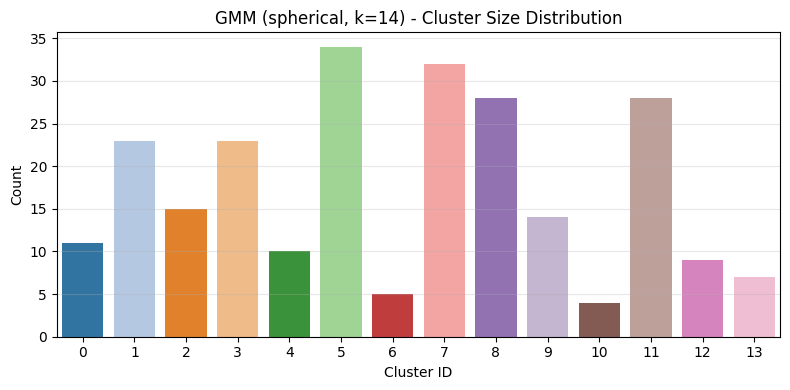


📋 Cluster Feature Summary Table (Mean ± Std):


avg_bat_speed    swing_tilt  attack_angle attack_direction  \
cluster                                                              
0        72.57 ± 1.52   35.1 ± 2.68   14.3 ± 1.56     -0.26 ± 1.79   
1        69.95 ± 1.74  29.94 ± 2.28   8.85 ± 2.41     -2.11 ± 2.07   
2        72.27 ± 2.31   35.1 ± 2.48  15.54 ± 2.31     -6.73 ± 3.08   
3        73.42 ± 1.73  32.49 ± 1.66  10.24 ± 2.06      -4.58 ± 2.1   
4        71.46 ± 1.44   35.14 ± 1.7  16.41 ± 1.02     -2.71 ± 2.21   
5         71.9 ± 2.02  35.46 ± 2.32   9.62 ± 2.32     -1.12 ± 2.76   
6        71.74 ± 2.41  40.98 ± 3.02  14.06 ± 3.21      2.23 ± 1.49   
7        71.59 ± 1.57  30.29 ± 2.74  10.69 ± 2.03      -6.2 ± 2.51   
8        72.38 ± 1.82  31.77 ± 2.73   9.39 ± 1.94      2.92 ± 2.34   
9        68.78 ± 1.18  34.73 ± 2.14   8.13 ± 1.68       1.3 ± 2.37   
10       63.55 ± 0.73  34.61 ± 3.11   4.65 ± 1.97      0.23 ± 3.45   
11        73.6 ± 1.56  27.55 ± 2.01   7.21 ± 2.37     -0.97 ± 2.42   
12       76.29 ± 1.52   30.1 ± 2.47  10.56 ± 1.89     -6.58 ± 1.33   
13       67.77 ± 1.52  31.02 ± 1.42   3.33 ± 1.55      6.36 ± 4.13   

        avg_intercept_y_vs_batter   swing_length  
cluster                                           
0                    26.54 ± 2.25  20.55 ± 10.36  
1                    30.76 ± 1.69  79.43 ± 13.59  
2                    33.52 ± 2.59    7.87 ± 6.25  
3                    28.88 ± 1.52  13.22 ± 11.81  
4                     34.2 ± 1.99   63.6 ± 14.07  
5                    31.74 ± 2.15  53.65 ± 23.83  
6                    29.31 ± 2.35   78.2 ± 10.73  
7                    34.33 ± 2.35  51.53 ± 18.19  
8                     27.2 ± 2.05  49.21 ± 19.69  
9                    25.83 ± 1.01  75.21 ± 12.68  
10                    31.0 ± 0.86   99.25 ± 0.96  
11                   31.33 ± 2.04  33.04 ± 20.58  
12                   35.36 ± 1.82  12.56 ± 11.84  
13                   26.47 ± 4.01   92.29 ± 6.92

In [30]:
# === GMM (Spherical) Code ===
clustered_data, fitted_model, cluster_summary = analyze_single_clustering_model(
    cluster_data,
    recommended_features,
    model_type='gmm',
    cov_type='spherical',
    k=14
)

### Merge Latest Local Model into `final_df`

In [ ]:
## FINAL: Used GMM w/ k=14 ##
## Clusters are more centralized

# Add swing_archetype column to final_df
final_df['swing_archetype'] = clustered_data['cluster']

# Verify the merge
print(final_df)

         id                  name bat_side side  avg_foot_sep  \
0    646240        Devers, Rafael        L    L     31.035497   
1    691718  Crow-Armstrong, Pete        L    L     33.491122   
2    677594      Rodríguez, Julio        R    R     30.621024   
3    682985         Greene, Riley        L    L     28.550438   
4    621566           Olson, Matt        L    L     31.554282   
..      ...                   ...      ...  ...           ...   
240  650859         Rengifo, Luis        R    R     34.322489   
241  663968          Mangum, Jake        R    R     25.564098   
242  672275       Bailey, Patrick        R    R     26.481101   
243  668939      Rutschman, Adley        R    R     40.203628   
244  593871        Polanco, Jorge        R    R     31.910784   

     avg_stance_angle  stance_archetype  avg_bat_speed  swing_tilt  \
0          -62.799237                 4         71.603      29.539   
1           -1.923022                 5         72.593      34.800   
2        

# Clustering Visualizations (EDA)

### Interactive Swing-Performance Heatmap  

**Purpose:**  
Reveals relationships between swing mechanics (archetypes) and batting performance tiers. Identifies which players of specific swing archetypes correlate with specific performance tiers.

**Key Features:**  
- **Interactive Elements**:  
  - Hover shows player names (truncated after 20)  
  - Color intensity = player count per cell  
- **Data Structure**:  
  - Rows: Swing archetypes (sorted numerically)  
  - Columns: Performance tiers (Poor → Superstar)  
- **Color Scale**: SunsetDark gradient for clear contrast  

**Notes:**  
- Preserves categorical ordering in both dimensions  
- Built with Plotly for full interactivity  

In [32]:
# =========================
# INTERACTIVE HEATMAP OF PERFORMANCE TIERS VS SWING ARCHETYPES
# =========================
import plotly.graph_objects as go

# Clean copy
heatmap_df = final_df.copy()

# Convert to string for plotting
heatmap_df['swing_archetype'] = heatmap_df['swing_archetype'].astype(str)

# Player identifier
heatmap_df['player_list'] = heatmap_df['name'] + '_' + heatmap_df['side']

# Categorical ordering
heatmap_df['performance_tier'] = pd.Categorical(
    heatmap_df['performance_tier'],
    categories=tier_names,
    ordered=True
)

# Dynamically get swing archetype categories
archetype_categories = sorted(heatmap_df['swing_archetype'].unique(), key=int)
heatmap_df['swing_archetype'] = pd.Categorical(
    heatmap_df['swing_archetype'],
    categories=archetype_categories,
    ordered=True
)

# Group and summarize
grid_summary = heatmap_df.groupby(['swing_archetype', 'performance_tier']).agg(
    player_count=('player_list', 'count'),
    player_names=('player_list', lambda x: '<br>'.join(x[:20]) + ('<br>... (truncated)' if len(x) > 20 else ''))
).reset_index()

pivot_ready = grid_summary.groupby(['swing_archetype', 'performance_tier']).agg({
    'player_count': 'sum',
    'player_names': 'first'
}).reset_index()

# Pivot
z = pivot_ready.pivot(index='swing_archetype', columns='performance_tier', values='player_count').fillna(0)
text = pivot_ready.pivot(index='swing_archetype', columns='performance_tier', values='player_names').fillna('')

# Heatmap
fig = go.Figure(data=go.Heatmap(
    z=z.values,
    x=z.columns,
    y=z.index,
    text=z.values,
    hovertext=text.values,
    hoverinfo='text',
    colorscale='sunsetdark',
    colorbar=dict(title='Player Count')
))

fig.update_traces(texttemplate="%{text}", textfont_size=14)
fig.update_layout(
    title=f'{len(archetype_categories)}x{len(tier_names)} Heatmap: Swing Archetypes vs Performance Tiers',
    xaxis_title='Performance Tier',
    yaxis_title='Swing Archetype',
    height=600
)

fig.show()

#### Swing Archetype Success Analysis  

Quantifies which swing mechanics correlate with success. Highlights potential trends in performance level on archetypes as a whole, and how they relate to overall success/failure. Oversimplified calculation that provides insight that should be further explored with finer detail.

**Key Metrics:**  
- **Success Rate**: % of players in Above/Elite/Superstar tiers  
- **Failure Rate**: % in Poor/Below tiers  
- **Total Players**: Sample size per archetype  

**Output Table Shows:**  
1. Archetype ID  
2. Total player count  
3. % Successful hitters  
4. % Unsuccessful hitters  

In [33]:
# =========================
# SUCCESS RATE FOR SWING ARCHETYPES
# =========================
swing_stats_df = heatmap_df.copy()
swing_stats_df['swing_archetype'] = swing_stats_df['swing_archetype'].astype(str)

# Define tier groupings
success_tiers = ['Above', 'Elite', 'Superstar']
failure_tiers = ['Poor', 'Below']

# Count of players in each (archetype, tier)
swing_grouped = swing_stats_df.groupby(['swing_archetype', 'performance_tier'])['name'].count().unstack(fill_value=0)

# Ensure all defined tiers are columns (even if missing from data)
for col in success_tiers + failure_tiers:
    if col not in swing_grouped.columns:
        swing_grouped[col] = 0

# Total per archetype
swing_grouped['Total'] = swing_grouped.sum(axis=1)

# Success / failure rates
swing_grouped['% Successful'] = (swing_grouped[success_tiers].sum(axis=1) / swing_grouped['Total'] * 100).round(1)
swing_grouped['% Unsuccessful'] = (swing_grouped[failure_tiers].sum(axis=1) / swing_grouped['Total'] * 100).round(1)

# Final output table
swing_summary = swing_grouped[['Total', '% Successful', '% Unsuccessful']].sort_index()

# Display
print("Swing Archetype Success/Failure Rates (%):\n")
print(swing_summary.to_markdown())

Swing Archetype Success/Failure Rates (%):

|   swing_archetype |   Total |   % Successful |   % Unsuccessful |
|------------------:|--------:|---------------:|-----------------:|
|                 0 |      11 |           36.4 |             45.5 |
|                 1 |      23 |           17.4 |             34.8 |
|                10 |       4 |            0   |             50   |
|                11 |      28 |           46.4 |             32.1 |
|                12 |       9 |           44.4 |              0   |
|                13 |       7 |           14.3 |             57.1 |
|                 2 |      15 |           46.7 |             33.3 |
|                 3 |      23 |           17.4 |             39.1 |
|                 4 |      10 |           70   |             20   |
|                 5 |      34 |           47.1 |             32.4 |
|                 6 |       5 |           40   |             60   |
|                 7 |      32 |           25   |             34.4 |
|   

### Interactive Stance-Performance Heatmap  

In [34]:
# =========================
# STEP 6: INTERACTIVE HEATMAP OF PERFORMANCE TIERS VS STANCE ARCHETYPES
# =========================
import plotly.graph_objects as go

stance_heatmap_df = final_df.copy()
stance_heatmap_df['stance_archetype'] = stance_heatmap_df['stance_archetype'].astype(str)

# Player identifier
stance_heatmap_df['player_list'] = stance_heatmap_df['name'] + '_' + stance_heatmap_df['side']

# Set category order
stance_heatmap_df['performance_tier'] = pd.Categorical(
    stance_heatmap_df['performance_tier'],
    categories=tier_names,
    ordered=True
)

# Dynamic archetype categories
stance_archetype_categories = sorted(stance_heatmap_df['stance_archetype'].unique(), key=int)
stance_heatmap_df['stance_archetype'] = pd.Categorical(
    stance_heatmap_df['stance_archetype'],
    categories=stance_archetype_categories,
    ordered=True
)

# Group and summarize
stance_grid_summary = stance_heatmap_df.groupby(['stance_archetype', 'performance_tier']).agg(
    player_count=('player_list', 'count'),
    player_names=('player_list', lambda x: '<br>'.join(x[:20]) + ('<br>... (truncated)' if len(x) > 20 else ''))
).reset_index()

stance_pivot_ready = stance_grid_summary.groupby(['stance_archetype', 'performance_tier']).agg({
    'player_count': 'sum',
    'player_names': 'first'
}).reset_index()

# Pivot
z_stance = stance_pivot_ready.pivot(index='stance_archetype', columns='performance_tier', values='player_count').fillna(0)
text_stance = stance_pivot_ready.pivot(index='stance_archetype', columns='performance_tier', values='player_names').fillna('')

# Plot
fig = go.Figure(data=go.Heatmap(
    z=z_stance.values,
    x=z_stance.columns,
    y=z_stance.index,
    text=z_stance.values,
    hovertext=text_stance.values,
    hoverinfo='text',
    colorscale='sunsetdark',
    colorbar=dict(title='Player Count')
))

fig.update_traces(texttemplate="%{text}", textfont_size=14)
fig.update_layout(
    title=f'{len(stance_archetype_categories)}x{len(tier_names)} Heatmap: Stance Archetypes vs Performance Tiers',
    xaxis_title='Performance Tier',
    yaxis_title='Stance Archetype',
    height=600
)

fig.show()

#### Stance Archetype Success Analysis  

In [35]:
# =========================
# STEP 6b: SUCCESS RATE FOR STANCE ARCHETYPES
# =========================
stance_stats_df = final_df.copy()
stance_stats_df['stance_archetype'] = stance_stats_df['stance_archetype'].astype(str)

# Define tier groups
success_tiers = ['Above', 'Elite']
failure_tiers = ['Poor', 'Below']

# Group and count per tier
stance_grouped = stance_stats_df.groupby(['stance_archetype', 'performance_tier'])['name'].count().unstack(fill_value=0)

# Total per archetype
stance_grouped['Total'] = stance_grouped.sum(axis=1)

# Compute percentages
stance_grouped['% Successful'] = (stance_grouped[success_tiers].sum(axis=1) / stance_grouped['Total'] * 100).round(1)
stance_grouped['% Unsuccessful'] = (stance_grouped[failure_tiers].sum(axis=1) / stance_grouped['Total'] * 100).round(1)

# Final output table
stance_summary = stance_grouped[['Total', '% Successful', '% Unsuccessful']].sort_index()

# Display
print("Stance Archetype Success/Failure Rates (%):\n")
print(stance_summary.to_markdown())

Stance Archetype Success/Failure Rates (%):

|   stance_archetype |   Total |   % Successful |   % Unsuccessful |
|-------------------:|--------:|---------------:|-----------------:|
|                  0 |      28 |           21.4 |             39.3 |
|                  1 |      30 |           20   |             33.3 |
|                  2 |      43 |           39.5 |             39.5 |
|                  3 |      55 |           29.1 |             38.2 |
|                  4 |      11 |           27.3 |             18.2 |
|                  5 |      76 |           32.9 |             31.6 |


# Analysis on Pitch Types

### Create `combined_arsenal_df`

In [36]:
final_df['id'] = final_df['id'].astype(int)
arsenal_df['id'] = arsenal_df['id'].astype(int)

# Subset final_df to keep only the relevant columns
attributes = final_df[['id', 'swing_archetype', 'stance_archetype', 'performance_tier']].copy()

# Left merge with arsenal_df based on 'name' column
combined_arsenal_df = pd.merge(arsenal_df, attributes, on='id', how='left').dropna()

## Pitch Type Performance by Swing Archetype  

**Key Analysis:**  
- Combines swing mechanics, performance tiers, and pitch-by-pitch results  
- Reveals which archetypes hit specific pitches best
    - Identifies swing-style/pitch-type matchups to exploit  
    - Shows which archetypes naturally run into specific pitch shapes
- Excludes **Knuckleballs**, **Screwballs**, and **Slurve**, as they are less common and have inconsistent data

**Output Table Includes:**  
1. **Player Metrics**:  
   - RV/100 (run value)  
   - BA/SLG/wOBA (traditional stats)  
   - xBA/xSLG/xwOBA (expected stats)  
   - Whiff%/K% (swing-and-miss rates)  
   - Hard Hit% (contact quality)  

2. **Grouping Dimensions**:  
   - Swing archetype  
   - Performance tier  
   - Pitch type (excluding rare pitches)  

3. **Sample Size**: Player count per group  

**Extra Usage Example:**  
```python
# Find best-performing archetypes vs fastballs:
hitters_vs_pitch_types[hitters_vs_pitch_types['Pitch Type']=='4-Seam Fastball']\
    .sort_values('RV/100', ascending=False)
```
  

In [37]:
# Step 1: Group and count number of players per group
player_counts = (
    combined_arsenal_df
    .groupby(['swing_archetype', 'performance_tier', 'Pitch Type'])
    .size()
    .reset_index(name='Player Count')
)

summary_cols = [
    'RV/100',        # Run Value per 100 pitches - key overall performance metric
    'Run Value',
    'BA',            # Batting Average against this pitch type
    'SLG',           # Slugging Percentage against this pitch type
    'wOBA',          # Weighted On-Base Average (comprehensive offensive metric)
    'Whiff%',        # Miss rate on swings - important for swing effectiveness
    'K%',            # Strikeout rate against this pitch
    'Hard Hit %',    # Quality of contact metric
    'xBA',           # Expected Batting Average
    'xSLG',          # Expected Slugging Percentage
    'xwOBA',         # Expected wOBA
    'PutAway %'      # Pitcher's putaway rate (reverse indicator for hitters)
]

# Step 2: Group and summarize metrics
hitters_vs_pitch_types = (
    combined_arsenal_df
    .groupby(['swing_archetype', 'performance_tier', 'Pitch Type'])[summary_cols]
    .mean()
    .round(3)
    .reset_index()
)

# Step 3: Merge player counts into the summary DataFrame
hitters_vs_pitch_types = pd.merge(
    hitters_vs_pitch_types,
    player_counts,
    on=['swing_archetype', 'performance_tier', 'Pitch Type'],
    how='left'
)

# Step 4: Convert numeric columns and exclude rare pitch types
hitters_vs_pitch_types[summary_cols] = hitters_vs_pitch_types[summary_cols].apply(pd.to_numeric, errors='coerce')
excluded_pitches = ['Knuckleball', 'Slurve', 'Screwball']
hitters_vs_pitch_types = hitters_vs_pitch_types[~hitters_vs_pitch_types['Pitch Type'].isin(excluded_pitches)]

# View the result
print(hitters_vs_pitch_types)

     swing_archetype performance_tier       Pitch Type  RV/100  Run Value  \
0                0.0            Above  4-Seam Fastball    1.10      5.131   
1                0.0            Above         Changeup    2.30      3.877   
2                0.0            Above        Curveball    0.50      0.640   
3                0.0            Above           Cutter    2.55      2.756   
4                0.0            Above           Sinker    1.30      1.110   
..               ...              ...              ...     ...        ...   
598             13.0             Poor           Cutter   -1.80     -1.854   
599             13.0             Poor           Sinker   -0.10     -0.226   
600             13.0             Poor           Slider   -4.00     -8.360   
602             13.0             Poor     Split-Finger    3.70      0.444   
603             13.0             Poor          Sweeper   -1.40     -1.512   

        BA    SLG   wOBA  Whiff%     K%  Hard Hit %    xBA   xSLG  xwOBA  \

In [38]:
mean_run_value = hitters_vs_pitch_types['Run Value'].mean()
std_run_value = hitters_vs_pitch_types['Run Value'].std()

print(f"Mean of run_value: {mean_run_value:.3f}")
print(f"Standard deviation of run_value: {std_run_value:.3f}")

Mean of run_value: 0.863
Standard deviation of run_value: 3.101


### **Comprehensive Hitter-Pitch Matchup Analysis**

Identifies optimal pitch strategies against different hitter archetypes by analyzing swing mechanics, performance tiers, and pitch-specific outcomes.

**Key Components**

1. **Core Analytical Engine**
   - `archetype_strength_analysis()`: Quantifies which pitch types each swing archetype performs best/worst against using weighted composite scores
   - `pitch_effectiveness_ranking()`: Ranks all pitch types by overall effectiveness against all hitters
   - `archetype_vulnerability_matrix()`: Creates matchup matrices showing K%, wOBA, Hard Hit%, and PutAway% for each archetype-pitch combination

2. **Advanced Statistical Methods**
   - Weighted averaging (by player count) for robust aggregation
   - K-means clustering to identify hidden performance patterns
   - ANOVA testing for statistically significant differences
   - Composite metric development (attack_score, net_performance)

3. **Visualization Suite**
   - **Heatmap Matrices**: 2x2 grid comparing wOBA, K%, Hard Hit%, and PutAway% across matchups
   - **Distribution Plots**: Histograms and boxplots showing performance metrics by archetype and pitch type
   - **Cluster Analysis**: Visual grouping of similar performance profiles

**Outputs**

1. **Strategic Recommendations**
   ```python
   {
       'attack_with': [
           ['4-Seam Fastball', 32.1, 0.310, 38.2],  # Pitch, K%, wOBA, HardHit%
           ['Slider', 35.4, 0.285, 32.1]
       ],
       'avoid': [
           ['Changeup', 18.7, 0.380, 42.5],
           ['Curveball', 22.3, 0.355, 39.8]
       ],
       'key_insight': "Archetype 3 struggles most with high fastballs (32.1% K-rate)"
   }
   ```

2. **Statistical Findings**
   - Pitch effectiveness rankings (weighted by usage)
   - Performance tier vulnerabilities (how different talent levels handle pitches)
   - Significant archetype-pitch interactions (p < 0.05)

3. **Diagnostic Visuals**
   - **Heatmaps**: Quickly identify red (advantage pitcher) and blue (advantage hitter) zones
   - **Cluster Plots**: See which archetypes group together in performance space
   - **Distribution Charts**: Understand metric variability across groups


**Technical Adjustments**

1. **Data Weighting**: All metrics weighted by player count for representative averages
2. **Dynamic Clustering**: Automatic elbow detection for optimal group identification
3. **Statistical Rigor**: Hypothesis testing ensures findings are significant
4. **Visual Outputs**: Heatmaps and plots support deep visual exploration

Initialize the analyzer with your data:
STARTING COMPREHENSIVE HITTER VS PITCH TYPE ANALYSIS
=== ARCHETYPE STRENGTH ANALYSIS ===

--- MLB-WIDE AVERAGES (Total Players: 2,360) ---
Overall Average Performance Score: 5.065
Average wOBA: 0.326
Average K%: 22.4%
Average Hard Hit%: 39.8%
Average Offensive Score: 5.286
Average Defensive Vulnerability: 22.1%

--- 0.0 (104 players) ---
STRONGEST AGAINST:
Pitch Type  net_performance     wOBA        K%  Player Count
    Sinker         6.940535 0.412462 16.000000            13
    Cutter         6.606750 0.499154 20.484615            13
   Sweeper         6.368272 0.233462 34.069231            13

WEAKEST AGAINST:
  Pitch Type  net_performance     wOBA        K%  Player Count
Split-Finger         3.137660 0.231385 40.861538            13
    Changeup         4.774865 0.307385 31.838462            13
   Curveball         5.207426 0.301923 36.523077            13
Overall Performance Score: 5.607
vs MLB Average: +0.541 (Above average)

--- 1.0 (232 p

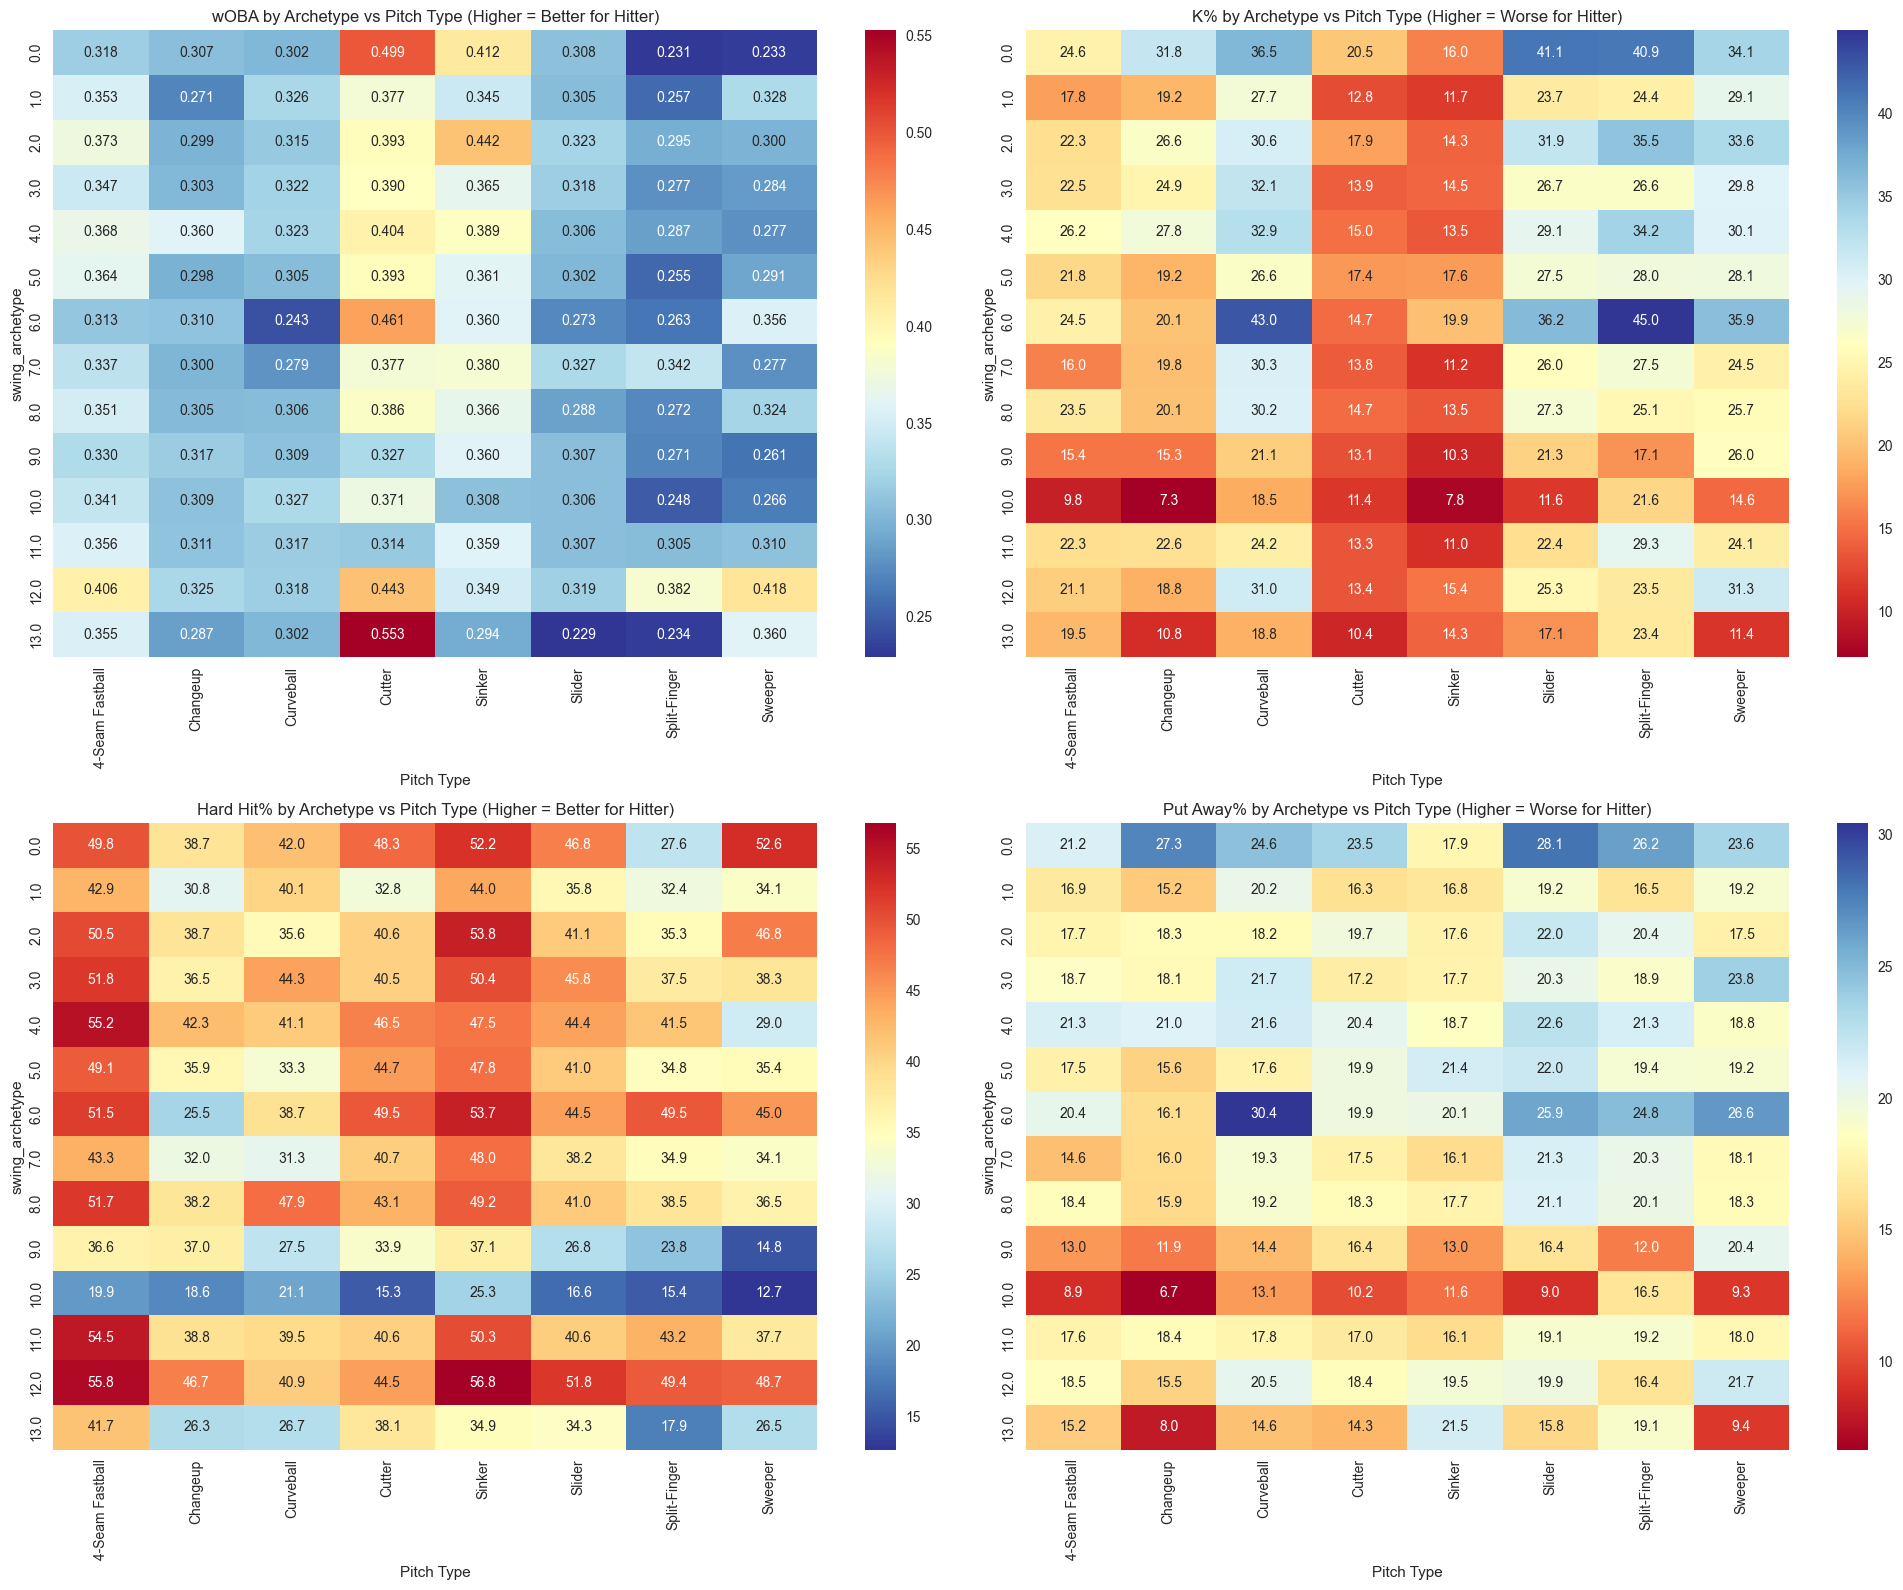

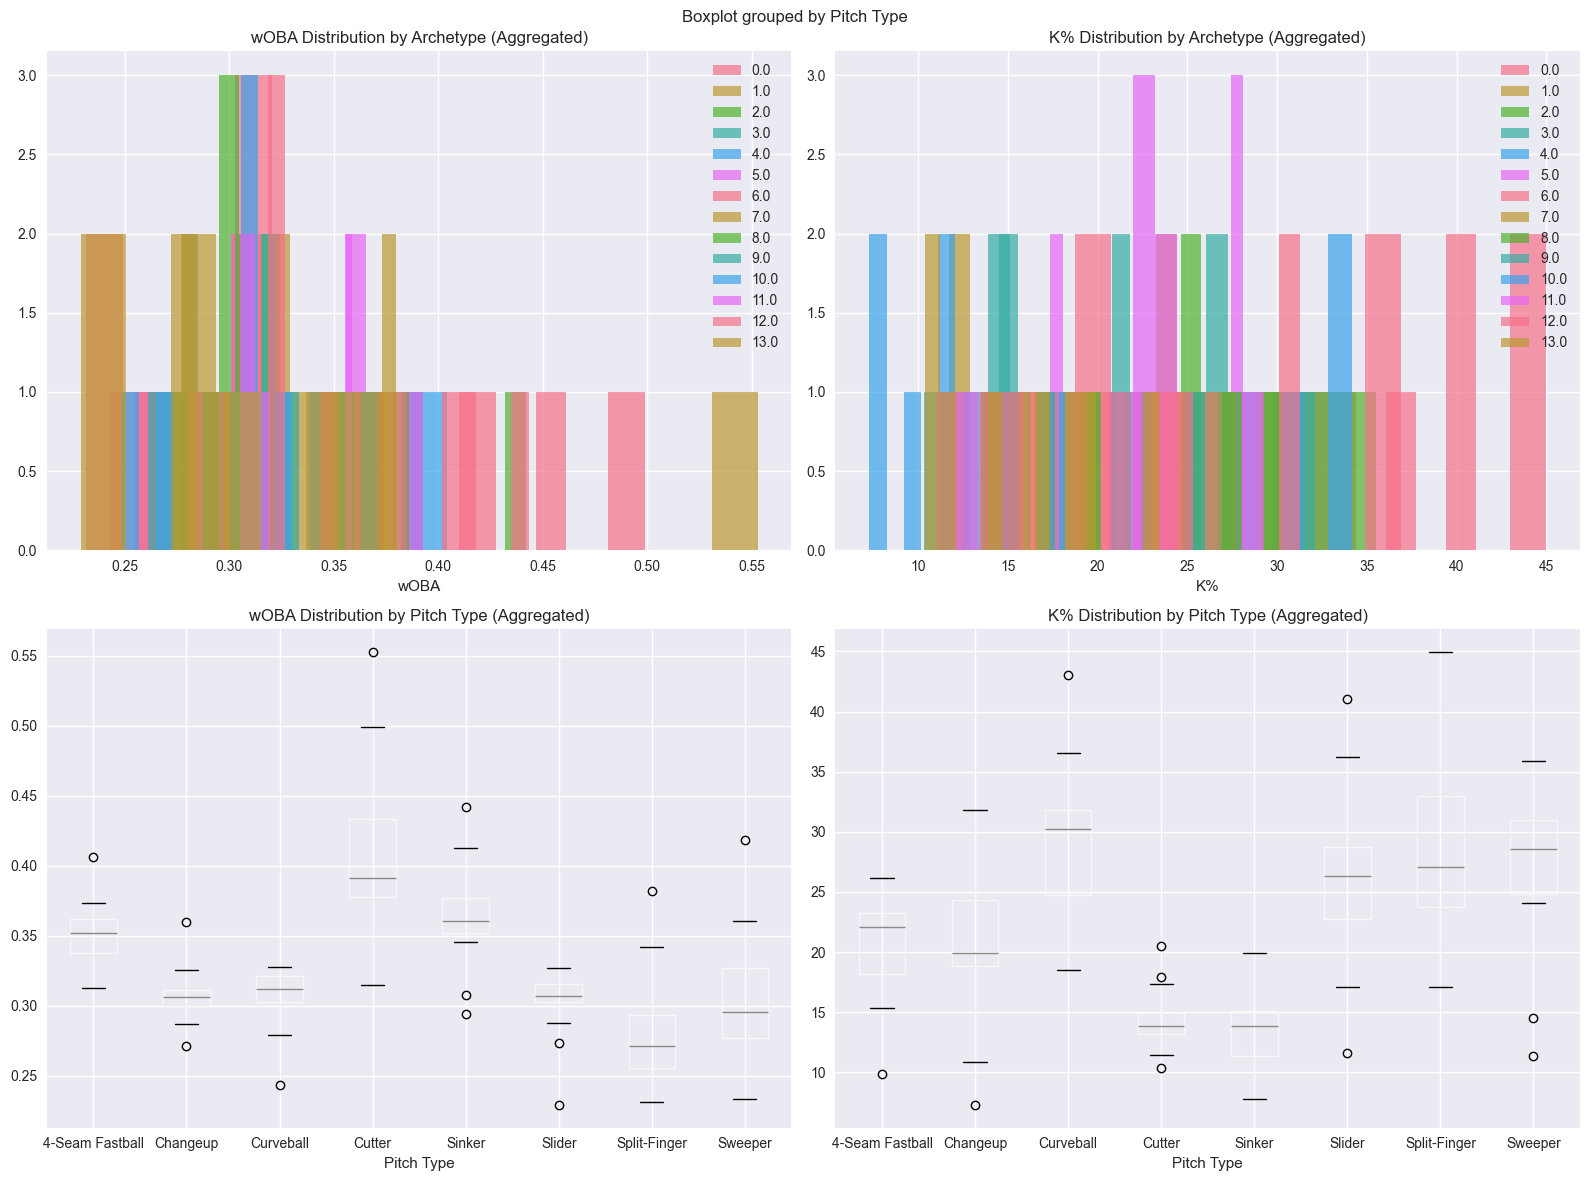

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class HitterPitchAnalyzer:
    def __init__(self, hitters_vs_pitch_types):
        self.data = hitters_vs_pitch_types.copy()
        self.summary_cols = [
            'Run Value', 'BA', 'SLG', 'wOBA', 'Whiff%', 'K%', 'PutAway %',
            'xBA', 'xSLG', 'xwOBA', 'Hard Hit %'
        ]
        self.offensive_metrics = [
            'Run Value', 'BA', 'SLG', 'wOBA', 
            'xBA', 'xSLG', 'xwOBA', 'Hard Hit %'
        ]
        self.defensive_metrics = ['Whiff%', 'K%', 'PutAway %']
        
        # Calculate MLB-wide averages weighted by player count
        self._calculate_mlb_averages()
        
    def _calculate_mlb_averages(self):
        """Calculate MLB-wide weighted averages for comparison"""
        total_players = self.data['Player Count'].sum()
        
        # Calculate weighted averages for each metric
        self.mlb_averages = {}
        for col in self.summary_cols:
            if col in self.data.columns:
                self.mlb_averages[col] = np.average(self.data[col], weights=self.data['Player Count'])
        
        # Calculate MLB composite scores
        mlb_offensive_metrics = [col for col in self.offensive_metrics if col in self.mlb_averages]
        mlb_defensive_metrics = [col for col in self.defensive_metrics if col in self.mlb_averages]
        
        self.mlb_averages['offensive_score'] = np.mean([self.mlb_averages[col] for col in mlb_offensive_metrics])
        self.mlb_averages['defensive_vulnerability'] = np.mean([self.mlb_averages[col] for col in mlb_defensive_metrics])
        self.mlb_averages['net_performance'] = (
            self.mlb_averages['offensive_score'] - 
            (self.mlb_averages['defensive_vulnerability'] / 100)
        )
        
        self.total_mlb_players = total_players
        
    def _aggregate_by_pitch_type(self, archetype_data):
        """
        Aggregate data by pitch type within an archetype, weighted by Player Count
        """
        # First, calculate weighted metrics for each row
        weighted_data = archetype_data.copy()
        
        # Weight each metric by Player Count
        numeric_cols = self.summary_cols + ['Player Count']
        for col in self.summary_cols:
            if col in weighted_data.columns:
                weighted_data[f'{col}_weighted'] = weighted_data[col] * weighted_data['Player Count']
        
        # Group by Pitch Type and aggregate
        agg_dict = {'Player Count': 'sum'}
        
        # Add weighted sum aggregations for each metric
        for col in self.summary_cols:
            if col in weighted_data.columns:
                agg_dict[f'{col}_weighted'] = 'sum'
        
        # Preserve other important columns
        if 'swing_archetype' in weighted_data.columns:
            agg_dict['swing_archetype'] = 'first'
        if 'performance_tier' in weighted_data.columns:
            agg_dict['performance_tier'] = lambda x: ', '.join(x.unique())  # Show all tiers represented
        
        aggregated = weighted_data.groupby('Pitch Type').agg(agg_dict).reset_index()
        
        # Calculate final weighted averages
        for col in self.summary_cols:
            if col in weighted_data.columns:
                aggregated[col] = aggregated[f'{col}_weighted'] / aggregated['Player Count']
                aggregated = aggregated.drop(f'{col}_weighted', axis=1)
        
        return aggregated
        
    def archetype_strength_analysis(self):
        """Analyze which pitch types each archetype excels against"""
        print("=== ARCHETYPE STRENGTH ANALYSIS ===")
        
        # Display MLB-wide averages first
        print(f"\n--- MLB-WIDE AVERAGES (Total Players: {self.total_mlb_players:,}) ---")
        print(f"Overall Average Performance Score: {self.mlb_averages['net_performance']:.3f}")
        print(f"Average wOBA: {self.mlb_averages['wOBA']:.3f}")
        print(f"Average K%: {self.mlb_averages['K%']:.1f}%")
        print(f"Average Hard Hit%: {self.mlb_averages['Hard Hit %']:.1f}%")
        print(f"Average Offensive Score: {self.mlb_averages['offensive_score']:.3f}")
        print(f"Average Defensive Vulnerability: {self.mlb_averages['defensive_vulnerability']:.1f}%")
        
        # Create composite offensive and defensive scores for the original data
        self.data['offensive_score'] = self.data[self.offensive_metrics].mean(axis=1)
        self.data['defensive_vulnerability'] = self.data[self.defensive_metrics].mean(axis=1)
        self.data['net_performance'] = self.data['offensive_score'] - (self.data['defensive_vulnerability'] / 100)
        
        archetype_analysis = {}
        
        for archetype in self.data['swing_archetype'].unique():
            archetype_data = self.data[self.data['swing_archetype'] == archetype]
            
            # Aggregate by pitch type
            aggregated_data = self._aggregate_by_pitch_type(archetype_data)
            
            # Recalculate composite scores on aggregated data
            aggregated_data['offensive_score'] = aggregated_data[self.offensive_metrics].mean(axis=1)
            aggregated_data['defensive_vulnerability'] = aggregated_data[self.defensive_metrics].mean(axis=1)
            aggregated_data['net_performance'] = aggregated_data['offensive_score'] - (aggregated_data['defensive_vulnerability'] / 100)
            
            # Best pitch matchups (highest net performance)
            best_pitches = aggregated_data.nlargest(3, 'net_performance')[['Pitch Type', 'net_performance', 'wOBA', 'K%', 'Player Count']]
            
            # Worst pitch matchups (lowest net performance)
            worst_pitches = aggregated_data.nsmallest(3, 'net_performance')[['Pitch Type', 'net_performance', 'wOBA', 'K%', 'Player Count']]
            
            # Calculate archetype's overall performance vs MLB average
            archetype_avg_performance = aggregated_data['net_performance'].mean()
            performance_vs_mlb = archetype_avg_performance - self.mlb_averages['net_performance']
            archetype_total_players = archetype_data['Player Count'].sum()
            
            archetype_analysis[archetype] = {
                'strengths': best_pitches,
                'weaknesses': worst_pitches,
                'avg_performance': archetype_avg_performance,
                'performance_vs_mlb': performance_vs_mlb,
                'total_players': archetype_total_players,
                'aggregated_data': aggregated_data
            }
            
            print(f"\n--- {archetype} ({archetype_total_players:,} players) ---")
            print("STRONGEST AGAINST:")
            print(best_pitches.to_string(index=False))
            print("\nWEAKEST AGAINST:")
            print(worst_pitches.to_string(index=False))
            print(f"Overall Performance Score: {archetype_avg_performance:.3f}")
            print(f"vs MLB Average: {performance_vs_mlb:+.3f} ({'Above' if performance_vs_mlb > 0 else 'Below'} average)")
        
        return archetype_analysis
    
    def pitch_effectiveness_ranking(self):
        """Rank pitch types by their effectiveness against different archetypes"""
        print("\n=== PITCH EFFECTIVENESS RANKING ===")
        
        pitch_effectiveness = []
        
        for pitch in self.data['Pitch Type'].unique():
            pitch_data = self.data[self.data['Pitch Type'] == pitch]
            
            # Weight by player count for overall averages
            total_players = pitch_data['Player Count'].sum()
            
            effectiveness_metrics = {
                'pitch_type': pitch,
                'avg_k_percent': np.average(pitch_data['K%'], weights=pitch_data['Player Count']),
                'avg_put_away': np.average(pitch_data['PutAway %'], weights=pitch_data['Player Count']),
                'avg_woba_against': np.average(pitch_data['wOBA'], weights=pitch_data['Player Count']),
                'avg_hard_hit_allowed': np.average(pitch_data['Hard Hit %'], weights=pitch_data['Player Count']),
                'total_players': total_players
            }
            
            effectiveness_metrics['effectiveness_score'] = (
                effectiveness_metrics['avg_k_percent'] + 
                effectiveness_metrics['avg_put_away'] - 
                (effectiveness_metrics['avg_woba_against'] * 100)
            )
            
            pitch_effectiveness.append(effectiveness_metrics)
        
        pitch_effectiveness_df = pd.DataFrame(pitch_effectiveness)
        pitch_effectiveness_df = pitch_effectiveness_df.sort_values('effectiveness_score', ascending=False)
        
        print(pitch_effectiveness_df.to_string(index=False))
        return pitch_effectiveness_df
    
    def archetype_vulnerability_matrix(self):
        """Create a vulnerability matrix showing archetype vs pitch type matchups"""
        print("\n=== VULNERABILITY MATRIX ===")
        
        vulnerability_matrices = {}
        metrics_to_analyze = ['K%', 'wOBA', 'Hard Hit %', 'PutAway %']
        
        for metric in metrics_to_analyze:
            # Create aggregated data for each archetype-pitch combination
            aggregated_combinations = []
            
            for archetype in self.data['swing_archetype'].unique():
                archetype_data = self.data[self.data['swing_archetype'] == archetype]
                aggregated_archetype = self._aggregate_by_pitch_type(archetype_data)
                aggregated_archetype['swing_archetype'] = archetype
                aggregated_combinations.append(aggregated_archetype)
            
            combined_aggregated = pd.concat(aggregated_combinations, ignore_index=True)
            
            # Create pivot table from aggregated data
            matrix = combined_aggregated.pivot_table(
                values=metric,
                index='swing_archetype',
                columns='Pitch Type',
                aggfunc='mean'
            ).round(3)
            
            vulnerability_matrices[metric] = matrix
            print(f"\n{metric.upper()} MATRIX:")
            print(matrix)
        
        return vulnerability_matrices
    
    def performance_tier_analysis(self):
        """Analyze how performance tiers interact with pitch types"""
        print("\n=== PERFORMANCE TIER ANALYSIS ===")
        
        tier_analysis = {}
        
        for tier in self.data['performance_tier'].unique():
            tier_data = self.data[self.data['performance_tier'] == tier]
            
            # Aggregate by pitch type within this tier, weighted by player count
            struggles = tier_data.groupby('Pitch Type').apply(
                lambda x: pd.Series({
                    'K%': np.average(x['K%'], weights=x['Player Count']),
                    'PutAway %': np.average(x['PutAway %'], weights=x['Player Count']),
                    'wOBA': np.average(x['wOBA'], weights=x['Player Count']),
                    'Hard Hit %': np.average(x['Hard Hit %'], weights=x['Player Count']),
                    'Total Players': x['Player Count'].sum()
                })
            ).round(3)
            
            # Calculate struggle score (higher K%, higher put_away, lower wOBA, lower hard hit)
            struggles['struggle_score'] = (
                struggles['K%'] + 
                struggles['PutAway %'] - 
                (struggles['wOBA'] * 50) - 
                (struggles['Hard Hit %'] * 0.5)
            )
            
            struggles_ranked = struggles.sort_values('struggle_score', ascending=False)
            
            tier_analysis[tier] = struggles_ranked
            
            print(f"\n--- {tier} TIER ---")
            print("Pitch types ranked by how much this tier struggles (highest = most struggle):")
            print(struggles_ranked)
        
        return tier_analysis
    
    def advanced_clustering_analysis(self):
        """Perform clustering analysis to find hidden patterns"""
        print("\n=== ADVANCED CLUSTERING ANALYSIS ===")
        
        # Aggregate data by archetype and pitch type first
        aggregated_combinations = []
        
        for archetype in self.data['swing_archetype'].unique():
            archetype_data = self.data[self.data['swing_archetype'] == archetype]
            aggregated_archetype = self._aggregate_by_pitch_type(archetype_data)
            aggregated_archetype['swing_archetype'] = archetype
            aggregated_combinations.append(aggregated_archetype)
        
        combined_aggregated = pd.concat(aggregated_combinations, ignore_index=True)
        
        # Prepare data for clustering
        feature_cols = [col for col in self.summary_cols if col in combined_aggregated.columns]
        clustering_data = combined_aggregated[feature_cols].fillna(combined_aggregated[feature_cols].mean())
        
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(clustering_data)
        
        # Perform K-means clustering
        optimal_k = self._find_optimal_clusters(scaled_data)
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        combined_aggregated['performance_cluster'] = kmeans.fit_predict(scaled_data)
        
        print(f"Optimal number of clusters found: {optimal_k}")
        
        # Analyze clusters
        cluster_analysis = combined_aggregated.groupby('performance_cluster').agg({
            'swing_archetype': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Mixed',
            'Pitch Type': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Mixed',
            'wOBA': 'mean',
            'K%': 'mean',
            'Hard Hit %': 'mean',
            'Run Value': 'mean',
        }).round(3)
        
        print("\nCluster Characteristics:")
        print(cluster_analysis)
        
        return cluster_analysis
    
    def _find_optimal_clusters(self, data, max_k=8):
        """Find optimal number of clusters using elbow method"""
        inertias = []
        k_range = range(2, max_k + 1)
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(data)
            inertias.append(kmeans.inertia_)
        
        # Simple elbow detection
        if len(inertias) > 1:
            diffs = np.diff(inertias)
            if len(diffs) > 1:
                diff_ratios = diffs[:-1] / diffs[1:]
                optimal_k = k_range[np.argmax(diff_ratios) + 1]
            else:
                optimal_k = k_range[0]
        else:
            optimal_k = k_range[0]
        
        return optimal_k
    
    def statistical_significance_testing(self):
        """Test for statistical significance in performance differences"""
        print("\n=== STATISTICAL SIGNIFICANCE TESTING ===")
        
        significant_findings = []
        
        # Test differences between archetypes for each pitch type (using aggregated data)
        for pitch in self.data['Pitch Type'].unique():
            pitch_data = self.data[self.data['Pitch Type'] == pitch]
            
            if len(pitch_data['swing_archetype'].unique()) < 2:
                continue
            
            # Aggregate by archetype for this pitch type
            archetype_woba = []
            for archetype in pitch_data['swing_archetype'].unique():
                archetype_pitch_data = pitch_data[pitch_data['swing_archetype'] == archetype]
                avg_woba = np.average(archetype_pitch_data['wOBA'], weights=archetype_pitch_data['Player Count'])
                archetype_woba.append(avg_woba)
            
            if len(set(archetype_woba)) > 1:  # Only test if there are different values
                # Create groups with repeated values based on player count for proper statistical testing
                archetype_groups = []
                for archetype in pitch_data['swing_archetype'].unique():
                    archetype_pitch_data = pitch_data[pitch_data['swing_archetype'] == archetype]
                    # Approximate by repeating average values
                    avg_woba = np.average(archetype_pitch_data['wOBA'], weights=archetype_pitch_data['Player Count'])
                    total_players = int(archetype_pitch_data['Player Count'].sum())
                    archetype_groups.append(np.full(max(total_players//10, 1), avg_woba))  # Scale down for computation
                
                try:
                    f_stat, p_value = stats.f_oneway(*archetype_groups)
                    
                    if p_value < 0.05:
                        significant_findings.append({
                            'Pitch Type': pitch,
                            'metric': 'wOBA',
                            'f_statistic': f_stat,
                            'p_value': p_value,
                            'interpretation': 'Significant archetype differences'
                        })
                except:
                    pass  # Skip if statistical test fails
        
        significant_df = pd.DataFrame(significant_findings)
        if len(significant_df) > 0:
            print("Statistically Significant Findings (p < 0.05):")
            print(significant_df.to_string(index=False))
        else:
            print("No statistically significant findings detected.")
        
        return significant_df
    
    def create_comprehensive_visualizations(self):
        """Create comprehensive visualizations using aggregated data"""
        print("\n=== CREATING VISUALIZATIONS ===")
        
        # Create aggregated data for visualization
        aggregated_combinations = []
        
        for archetype in self.data['swing_archetype'].unique():
            archetype_data = self.data[self.data['swing_archetype'] == archetype]
            aggregated_archetype = self._aggregate_by_pitch_type(archetype_data)
            aggregated_archetype['swing_archetype'] = archetype
            aggregated_combinations.append(aggregated_archetype)
        
        viz_data = pd.concat(aggregated_combinations, ignore_index=True)
        
        print(f"Visualization data: {len(viz_data)} rows (aggregated by pitch type)")
        
        # Check for sufficient data
        if len(viz_data['swing_archetype'].unique()) < 2 or len(viz_data['Pitch Type'].unique()) < 2:
            print("Insufficient data for comprehensive visualizations")
            return
        
        # 1. Heatmap of archetype vs pitch type performance
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        # wOBA heatmap
        woba_matrix = viz_data.pivot_table(values='wOBA', index='swing_archetype', columns='Pitch Type', aggfunc='mean')
        sns.heatmap(woba_matrix, annot=True, cmap='RdYlBu_r', ax=axes[0,0], fmt='.3f')
        axes[0,0].set_title('wOBA by Archetype vs Pitch Type (Higher = Better for Hitter)')
        
        # K% heatmap
        k_matrix = viz_data.pivot_table(values='K%', index='swing_archetype', columns='Pitch Type', aggfunc='mean')
        sns.heatmap(k_matrix, annot=True, cmap='RdYlBu', ax=axes[0,1], fmt='.1f')
        axes[0,1].set_title('K% by Archetype vs Pitch Type (Higher = Worse for Hitter)')
        
        # Hard Hit% heatmap
        hh_matrix = viz_data.pivot_table(values='Hard Hit %', index='swing_archetype', columns='Pitch Type', aggfunc='mean')
        sns.heatmap(hh_matrix, annot=True, cmap='RdYlBu_r', ax=axes[1,0], fmt='.1f')
        axes[1,0].set_title('Hard Hit% by Archetype vs Pitch Type (Higher = Better for Hitter)')
        
        # Put Away% heatmap
        pa_matrix = viz_data.pivot_table(values='PutAway %', index='swing_archetype', columns='Pitch Type', aggfunc='mean')
        sns.heatmap(pa_matrix, annot=True, cmap='RdYlBu', ax=axes[1,1], fmt='.1f')
        axes[1,1].set_title('Put Away% by Archetype vs Pitch Type (Higher = Worse for Hitter)')
        
        plt.tight_layout()
        plt.show()
        
        # 2. Performance distribution by archetype
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # wOBA distribution
        for archetype in viz_data['swing_archetype'].unique():
            archetype_data = viz_data[viz_data['swing_archetype'] == archetype]
            axes[0,0].hist(archetype_data['wOBA'], alpha=0.7, label=archetype, bins=15)
        axes[0,0].set_xlabel('wOBA')
        axes[0,0].set_title('wOBA Distribution by Archetype (Aggregated)')
        axes[0,0].legend()
        
        # K% distribution
        for archetype in viz_data['swing_archetype'].unique():
            archetype_data = viz_data[viz_data['swing_archetype'] == archetype]
            axes[0,1].hist(archetype_data['K%'], alpha=0.7, label=archetype, bins=15)
        axes[0,1].set_xlabel('K%')
        axes[0,1].set_title('K% Distribution by Archetype (Aggregated)')
        axes[0,1].legend()
        
        # Performance by pitch type
        viz_data.boxplot(column='wOBA', by='Pitch Type', ax=axes[1,0])
        axes[1,0].set_title('wOBA Distribution by Pitch Type (Aggregated)')
        axes[1,0].set_xlabel('Pitch Type')
        
        viz_data.boxplot(column='K%', by='Pitch Type', ax=axes[1,1])
        axes[1,1].set_title('K% Distribution by Pitch Type (Aggregated)')
        axes[1,1].set_xlabel('Pitch Type')
        
        plt.tight_layout()
        plt.show()
    
    def archetype_pitch_recommendations(self):
        """Generate specific recommendations for attacking each archetype"""
        print("\n=== ARCHETYPE ATTACK RECOMMENDATIONS ===")
        
        recommendations = {}
        
        for archetype in self.data['swing_archetype'].unique():
            archetype_data = self.data[self.data['swing_archetype'] == archetype]
            
            # Aggregate by pitch type
            aggregated_data = self._aggregate_by_pitch_type(archetype_data)
            
            # Calculate attack score on aggregated data
            aggregated_data['attack_score'] = (
                aggregated_data['K%'] + 
                aggregated_data['PutAway %'] - 
                (aggregated_data['wOBA'] * 100) - 
                (aggregated_data['Hard Hit %'] * 0.5)
            )
            
            best_attack_pitches = aggregated_data.nlargest(3, 'attack_score')
            worst_attack_pitches = aggregated_data.nsmallest(3, 'attack_score')
            
            recommendations[archetype] = {
                'attack_with': best_attack_pitches[['Pitch Type', 'K%', 'wOBA', 'Hard Hit %', 'attack_score']],
                'avoid': worst_attack_pitches[['Pitch Type', 'K%', 'wOBA', 'Hard Hit %', 'attack_score']],
                'key_insight': f"Most vulnerable to {best_attack_pitches.iloc[0]['Pitch Type']} with {best_attack_pitches.iloc[0]['K%']:.1f}% K-rate (based on {best_attack_pitches.iloc[0]['Player Count']} players)"
            }
            
            print(f"\n--- ATTACKING {archetype} ---")
            print("MOST EFFECTIVE PITCHES:")
            print(best_attack_pitches[['Pitch Type', 'K%', 'wOBA', 'Hard Hit %']].to_string(index=False))
            print("\nLEAST EFFECTIVE PITCHES (AVOID):")
            print(worst_attack_pitches[['Pitch Type', 'K%', 'wOBA', 'Hard Hit %']].to_string(index=False))
            print(f"\nKEY INSIGHT: {recommendations[archetype]['key_insight']}")
        
        return recommendations
    
    def run_complete_analysis(self):
        """Run all analyses in sequence"""
        print("STARTING COMPREHENSIVE HITTER VS PITCH TYPE ANALYSIS")
        print("=" * 60)
        
        # Run all analyses
        archetype_strengths = self.archetype_strength_analysis()
        pitch_effectiveness = self.pitch_effectiveness_ranking()
        vulnerability_matrices = self.archetype_vulnerability_matrix()
        tier_analysis = self.performance_tier_analysis()
        cluster_analysis = self.advanced_clustering_analysis()
        significance_tests = self.statistical_significance_testing()
        recommendations = self.archetype_pitch_recommendations()
        
        # Create visualizations
        self.create_comprehensive_visualizations()
        
        return {
            'archetype_strengths': archetype_strengths,
            'pitch_effectiveness': pitch_effectiveness,
            'vulnerability_matrices': vulnerability_matrices,
            'tier_analysis': tier_analysis,
            'cluster_analysis': cluster_analysis,
            'significance_tests': significance_tests,
            'recommendations': recommendations
        }

# Run the main analysis
print("Initialize the analyzer with your data:")
analyzer = HitterPitchAnalyzer(hitters_vs_pitch_types)
results = analyzer.run_complete_analysis()

## 🧠 Swing Archetype Scouting Report (June 9th)


**Swing Archetype 0 – \[Textbook A->B]**

* **Summary:** Average Bat Speed, High Tilt, LD Mid Direction, Deep Contact, Short Swing
* **Weakness:** North-South Pitching, Splitters are weakest, in combination with high fastball.
* **Plan of Attack:**

**Swing Archetype 1 – \[Flat Pull]**

* **Summary:** Slightly below-average bat speed, shortish, out-in-front swing, Low LD's.
* **Weakness:** Splitter, Sweeper, Changeup – trouble with horizontal break and deception.
* **Plan of Attack:**

**Swing Archetype 2 – \[Backside Approach]**

* **Summary:** Slow bat speed, Avg Tilt, Tight Path with a deep Contact point, Long Swing with an opposite field direction (More LHH in this cluster than RHH)
* **Weakness:** OH Sweeper In,  Splitter (Horz movement from CH can run into batpath). 
* **Plan of Attack:**

**Swing Archetype 3 – \[Elite Athletes (Teacherman)]**

* **Summary:** Upper Echlon bat speed, High LD/FB AA, short tight swing + early contact
* **Weakness:** Copared to other archetypes, very litte weaknesses. Relatively, weaknesses vary by player. Some struggle with SL/ST others struggle more with FS/CH.
* **Plan of Attack:**

**Swing Archetype 4 – \[Standard]**

* **Summary:** All swing metrics are nearly average: through the middle, average LD swing,  moderate in every metric.
* **Weakness:** SS Sweeper + Offspeed pitches; perfrom well against most FB types
* **Plan of Attack:**

**Swing Archetype 5 – \[Weak Pull FB]**

* **Summary:** Low bat speed, looking to launch Pull-side FB: Long, uptilt swings
* **Weakness:** Curveball, Sweeper, Slider: Big total movement pitches, looking to hit ball square at max bat speed
* **Plan of Attack:**

**Swing Archetype 6 – \[Short Pull FB]**

* **Summary:** Similar to Type 5, but mush shorter swing with more batspeed
* **Traits:** Aggressive steep attack, vulnerable to changing planes.
* **Weakness:** Curveball (32.5%), Sweeper, Slider, Split: Same total movement idea, but with higher K rates
* **Plan of Attack:**

**Swing Archetype 7 – \[Slap Hitter]**

* **Summary:** Weakest overall type: Looking to minimize K rate, putting the ball in play and on the ground
* **Weakness:** Attack w/ best pitch in zone, the worst case scenario is usually a hard hit 1B anyway, the range of damage is very narrow, important not to give way free bases, make them earn the 1B
* **Plan of Attack:**

**Swing Archetype 8 – \[Line-to-Line]**

* **Summary:** Elite bat speed, low AA, short swing with a deep contact point
* **Weakness:** Pretyy good against every type. Get them to commit to a half: commited up, then throw FS/CH, 
* **Plan of Attack:**

**Swing Archetype 9 – \[Jake Mangum]**

* **Summary:** One-player cluster; extreme outlier. LONG swing, slow, flat bat, SUPER oppo.
* **Traits:** Too specific to generalize. Might need personal scouting.
* **Recommendation:** Extreme version of Type 7

## 8/7/25 Clustering

| Cluster | Archetype           | Quick Summary                                                   |
| :-----: | :----------------------- | :------------------------------------------------------------------------------- |
| **0**   | **Line-to-Line**         | Short, quick bat. Deep, flyball contact and launch with a neutral direction  |
| **1**   | **Short & Inside**        | Compact swing, steep hands, stays tight; ideal for turning on inside heaters.   |
| **2**   | **Lift & Launch**         | Higher attack angle, uphill path; built to elevate and pull.                     |
| **3**   | **Gap Hunter**            | Quick through zone, shorter finish; drives balls to gaps on a line.              |
| **4**   | **Backspin FB**    | Aggressive upward path, longer finish; crushes pitches up in the zone.           |
| **5**   | **Textbook A->B**      | Level path, efficient to contact; punishes mistakes over the plate.              |
| **6**   | **Steep Agressive**           | Big hand load, extended swing length; trades quickness for power leverage.       |
| **7**   | **Flat Pull**              | Extreme upward tilt, long path; high fly-ball hitter with pull-side juice.       |
| **8**   | **Hands Inside**     | Quick hands, shorter barrel turn; best on inside pitches and quick react zones.  |
| **9**   | **Two-Strike Fighter**   | Controlled bat speed, flatter path; shortens up and fights off pitches.          |
| **10**  | **In Play Over K**         | Minimal load, rapid bat launch; attacks early in the count.                      |
| **11**  | **Middle Approach**      | Pronounced barrel tilt into load; creates loft from deep launch position.        |
| **12**  | **Max EV**| Slightly closed path, inside-out swing; thrives on outside pitches.               |
| **13**  | **Slap Hitter**            | Loose, fast barrel turn; explosive contact when timed right.                      |

#### Specific Pitch Type Success on Different Swing Archetypes

In [40]:
import pandas as pd

# Assuming your dataframe is named hitters_vs_pitch_types

# Define columns to calculate weighted averages for
weighted_cols = ['Run Value', 'BA', 'SLG', 'wOBA', 'Whiff%', 'K%', 'PutAway %',
                 'xBA', 'xSLG', 'xwOBA', 'Hard Hit %']

# First, multiply each metric by Player Count to prepare for weighted averaging
for col in weighted_cols:
    hitters_vs_pitch_types[f'{col}_weighted'] = hitters_vs_pitch_types[col] * hitters_vs_pitch_types['Player Count']

# Group by swing_archetype and Pitch Type, summing weighted metrics and Player Count
grouped = (
    hitters_vs_pitch_types
    .groupby(['swing_archetype', 'Pitch Type'])
    .agg({f'{col}_weighted': 'sum' for col in weighted_cols} | {'Player Count': 'sum'})
    .reset_index()
)

# Divide summed weighted metrics by total Player Count to get weighted averages
for col in weighted_cols:
    grouped[col] = grouped[f'{col}_weighted'] / grouped['Player Count']
    grouped.drop(columns=[f'{col}_weighted'], inplace=True)

# Optional: order by swing_archetype then Run Value descending for interpretation
grouped = grouped.sort_values(['swing_archetype', 'Run Value'], ascending=[True, False])

# Display results
print("==== Weighted Average Pitch Performance by Archetype and Pitch Type ====")
display(grouped)

==== Weighted Average Pitch Performance by Archetype and Pitch Type ====


swing_archetype       Pitch Type  Player Count  Run Value        BA  \
3                0.0           Cutter            13   3.583846  0.374308   
4                0.0           Sinker            13   2.016462  0.324154   
2                0.0        Curveball            13   0.609923  0.213615   
5                0.0           Slider            13   0.554846  0.204769   
1                0.0         Changeup            13   0.259923  0.224154   
..               ...              ...           ...        ...       ...   
105             13.0         Changeup            11  -0.134364  0.275091   
110             13.0     Split-Finger            11  -0.718000  0.196545   
104             13.0  4-Seam Fastball            11  -1.765818  0.296909   
109             13.0           Slider            11  -2.502545  0.190273   
108             13.0           Sinker            11  -2.606364  0.273909   

          SLG      wOBA     Whiff%         K%  PutAway %       xBA      xSLG  \
3    0.724923  0.499154  28.076923  20.484615  23.484615  0.309769  0.587769   
4    0.538692  0.412462  16.184615  16.000000  17.861538  0.342308  0.567615   
2    0.384538  0.301923  41.538462  36.523077  24.592308  0.213000  0.380231   
5    0.435154  0.307692  40.961538  41.076923  28.084615  0.198077  0.409692   
1    0.395231  0.307385  38.284615  31.838462  27.307692  0.227385  0.399769   
..        ...       ...        ...        ...        ...       ...       ...   
105  0.338545  0.286818  14.872727  10.827273   8.027273  0.264818  0.338727   
110  0.269364  0.233818  28.581818  23.409091  19.054545  0.180364  0.225636   
104  0.379545  0.354818  16.718182  19.463636  15.209091  0.282909  0.364091   
109  0.260455  0.229000  18.909091  17.118182  15.845455  0.237091  0.346727   
108  0.311455  0.293727  10.536364  14.263636  21.463636  0.238091  0.301000   

        xwOBA  Hard Hit %  
3    0.426231   48.269231  
4    0.418692   52.238462  
2    0.278231   42.015385  
5    0.293769   46.776923  
1    0.306308   38.676923  
..        ...         ...  
105  0.274273   26.300000  
110  0.199545   17.909091  
104  0.337455   41.727273  
109  0.266273   34.263636  
108  0.263000   34.927273  

[112 rows x 14 columns]

In [41]:
import pandas as pd

# A: Identify top/bottom performing pitches per archetype
def summarize_pitch_performance(df, stat='wOBA', top_n=2):
    top = (
        df.sort_values(by=stat, ascending=False)
          .groupby('swing_archetype')
          .head(top_n)
          .assign(performance='Best Pitches')
    )
    bottom = (
        df.sort_values(by=stat, ascending=True)
          .groupby('swing_archetype')
          .head(top_n)
          .assign(performance='Worst Pitches')
    )
    return pd.concat([top, bottom])

# Apply to run_value and woba
best_worst_runval = summarize_pitch_performance(hitters_vs_pitch_types, stat='Run Value', top_n=2)
best_worst_woba = summarize_pitch_performance(hitters_vs_pitch_types, stat='wOBA', top_n=2)

print("==== A. Top/Bottom Pitch Performance by run_value ====")
display(best_worst_runval)

print("==== A. Top/Bottom Pitch Performance by wOBA ====")
display(best_worst_woba)

==== A. Top/Bottom Pitch Performance by run_value ====


swing_archetype performance_tier       Pitch Type  RV/100  Run Value  \
558             12.0        Superstar  4-Seam Fastball   3.900     23.595   
396              8.0        Superstar  4-Seam Fastball   2.300     13.294   
119              2.0        Superstar  4-Seam Fastball   1.880     11.819   
31               0.0            Elite           Sinker   4.000     11.640   
275              5.0        Superstar           Slider   4.400     11.616   
50               0.0        Superstar           Slider   3.500     11.305   
172              3.0        Superstar  4-Seam Fastball   1.800     10.836   
562             12.0        Superstar           Sinker   3.000      9.660   
346              7.0        Superstar           Sinker   4.500      9.495   
123              2.0        Superstar           Sinker   5.500      9.416   
342              7.0        Superstar  4-Seam Fastball   1.700      8.500   
216              4.0        Superstar        Curveball   4.400      8.360   
252              5.0            Elite  4-Seam Fastball   1.338      7.930   
522             11.0        Superstar  4-Seam Fastball   1.450      7.790   
160              3.0            Elite           Slider   3.100      7.440   
207              4.0            Elite         Changeup   4.400      7.348   
570             13.0            Above           Cutter   5.400      7.128   
437              9.0            Elite           Slider   2.320      6.233   
504             11.0            Elite  4-Seam Fastball   1.025      5.654   
382              8.0            Elite           Sinker   1.467      5.594   
432              9.0            Elite  4-Seam Fastball   0.540      4.706   
281              6.0            Above           Cutter   3.000      4.314   
56               1.0            Above        Curveball   4.250      4.042   
579             13.0          Average           Cutter   4.400      4.004   
454             10.0          Average           Slider   1.900      3.926   
460             10.0            Below        Curveball   2.900      3.770   
286              6.0            Above          Sweeper   3.150      3.047   
57               1.0            Above           Cutter   3.083      2.250   
422              9.0            Below  4-Seam Fastball  -1.840     -8.798   
36               0.0             Poor  4-Seam Fastball  -1.800     -8.626   
600             13.0             Poor           Slider  -4.000     -8.360   
517             11.0             Poor           Sinker  -2.633     -7.837   
462             10.0            Below           Sinker  -2.600     -7.800   
387              8.0             Poor  4-Seam Fastball  -1.257     -6.537   
408              9.0            Above           Sinker  -1.800     -5.988   
194              4.0          Average           Slider  -3.300     -5.742   
576             13.0          Average  4-Seam Fastball  -0.800     -5.288   
316              7.0            Below        Curveball  -2.100     -4.868   
467             10.0             Poor  4-Seam Fastball  -1.100     -4.763   
87               1.0             Poor           Slider  -2.683     -4.567   
287              6.0            Below  4-Seam Fastball  -0.900     -4.149   
292              6.0            Below           Slider  -1.540     -3.573   
248              5.0            Below           Slider  -1.500     -3.374   
563             12.0        Superstar           Slider  -0.900     -3.348   
44               0.0             Poor          Sweeper  -3.760     -3.222   
200              4.0            Below           Cutter  -3.350     -3.102   
400              8.0        Superstar           Sinker  -0.800     -2.896   
314              7.0            Below  4-Seam Fastball  -0.550     -2.844   
518             11.0             Poor           Slider  -1.367     -2.791   
94               2.0            Above           Cutter  -1.675     -2.515   
262              5.0             Poor         Changeup  -1.390     -2.444   
5

==== A. Top/Bottom Pitch Performance by wOBA ====


swing_archetype performance_tier       Pitch Type  RV/100  Run Value  \
161              3.0            Elite     Split-Finger  11.700      5.382   
570             13.0            Above           Cutter   5.400      7.128   
192              4.0          Average           Cutter   5.000      4.800   
588             13.0            Below           Cutter   4.300      2.789   
39               0.0             Poor           Cutter   7.520      6.790   
123              2.0        Superstar           Sinker   5.500      9.416   
273              5.0        Superstar           Cutter   2.100      2.373   
217              4.0        Superstar           Cutter   4.400      5.676   
399              8.0        Superstar           Cutter   3.300      5.280   
3                0.0            Above           Cutter   2.550      2.756   
57               1.0            Above           Cutter   3.083      2.250   
281              6.0            Above           Cutter   3.000      4.314   
552             12.0            Elite           Cutter   4.800      3.456   
271              5.0        Superstar         Changeup   4.900      5.684   
402              8.0        Superstar     Split-Finger   4.500      4.995   
558             12.0        Superstar  4-Seam Fastball   3.900     23.595   
122              2.0        Superstar           Cutter   1.600      2.354   
346              7.0        Superstar           Sinker   4.500      9.495   
62               1.0            Above          Sweeper   3.500      1.843   
524             11.0        Superstar        Curveball   4.450      4.704   
435              9.0            Elite           Cutter   1.120      1.318   
290              6.0            Below           Cutter   1.680      1.466   
140              3.0          Average           Cutter   1.517      1.891   
451             10.0          Average        Curveball   2.350      2.400   
331              7.0            Elite     Split-Finger   6.200      2.628   
445              9.0             Poor           Sinker   1.640      2.160   
452             10.0          Average           Cutter   1.350      1.839   
522             11.0        Superstar  4-Seam Fastball   1.450      7.790   
43               0.0             Poor     Split-Finger  -5.840     -2.918   
469             10.0             Poor        Curveball  -3.700     -4.403   
44               0.0             Poor          Sweeper  -3.760     -3.222   
268              5.0             Poor     Split-Finger  -3.610     -2.158   
600             13.0             Poor           Slider  -4.000     -8.360   
574             13.0            Above     Split-Finger  -2.800     -2.072   
90               1.0             Poor          Sweeper  -2.483     -2.317   
135              3.0            Above     Split-Finger  -2.900     -2.109   
411              9.0            Above     Split-Finger  -2.700     -0.497   
221              4.0        Superstar     Split-Finger  -4.300     -2.967   
89               1.0             Poor     Split-Finger  -0.800     -0.330   
316              7.0            Below        Curveball  -2.100     -4.868   
474             10.0             Poor     Split-Finger  -4.100     -0.779   
335              7.0             Poor        Curveball  -1.733     -2.230   
98               2.0            Above     Split-Finger  -1.200     -0.714   
107              2.0          Average     Split-Finger  -0.400     -0.237   
538             12.0            Above     Split-Finger  -4.200     -2.394   
200              4.0            Below           Cutter  -3.350     -3.102   
170              3.0             Poor     Split-Finger  -0.233     -0.214   
520             11.0             Poor     Split-Finger  -0.700     -0.343   
294              6.0            Below     Split-Finger  -2.060     -1.327   
289              6.0            Below        Curveball  -1.160     -2.312   
446              9.0             Poor           Slider  -2.680     -5.903   
5

## Predict Swing Archetype

In [42]:
# =========================================
#  FLEXIBLE SWING-ARCHETYPE CLASSIFIER
#  (works with any subset of the columns)
# =========================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- 1. master list of desired predictors ---------
master_predictors = [
    'avg_bat_speed', 'swing_tilt', 'attack_angle', 'attack_direction',
    'avg_intercept_y_vs_plate', 'avg_intercept_y_vs_batter',
    'swing_length'                      
]

# --- 2. keep only those actually available --------
available_predictors = [c for c in master_predictors if c in final_df.columns]

if len(available_predictors) == 0:
    raise ValueError('None of the desired predictor columns are in final_df!')

print('Using these columns in this run:')
print(available_predictors)

# --- 3. prepare data --------------------------------
model_df = final_df[available_predictors + ['swing_archetype']].copy()

# impute missing values (within the available cols)
imputer = KNNImputer(n_neighbors = 5)
model_df[available_predictors] = imputer.fit_transform(model_df[available_predictors])

# --- 4. train / validate ----------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    model_df[available_predictors],
    model_df['swing_archetype'],
    test_size = 0.20,
    random_state = 42,
    stratify = model_df['swing_archetype']
)

clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)

print('\nSwing Archetype Prediction Report:')
print(classification_report(y_valid, y_pred))

Using these columns in this run:
['avg_bat_speed', 'swing_tilt', 'attack_angle', 'attack_direction', 'avg_intercept_y_vs_plate', 'avg_intercept_y_vs_batter', 'swing_length']

Swing Archetype Prediction Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.83      1.00      0.91         5
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         4
           4       0.67      1.00      0.80         2
           5       0.86      0.86      0.86         7
           6       0.00      0.00      0.00         1
           7       0.86      1.00      0.92         6
           8       0.71      0.83      0.77         6
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         1
          11       0.80      0.67      0.73         6
          12       0.50      0.50      0.50         2
          13       1.00      1.00

In [43]:
# --------------------------------------------------
#  Single-batter inference 
# --------------------------------------------------

# 1) Whatever numbers you have for this hitter
test_batter_raw = pd.DataFrame({
    'avg_bat_speed'            : [71.4],
    'swing_tilt'               : [34.2],
    'attack_angle'             : [14.6],
    'attack_direction'         : [-4.4],
    'avg_intercept_y_vs_batter': [28.9],
    'swing_length'             : [20]
})

# 2) Ensure every column the model expects is present
#    – add any missing ones as 
for col in available_predictors:
    if col not in test_batter_raw.columns:
        test_batter_raw[col] = np.nan

# 3) Re-order columns to match the model’s order
test_batter = test_batter_raw[available_predictors].copy()

# 4) Impute & predict
test_batter_imputed = pd.DataFrame(
    imputer.transform(test_batter),
    columns = available_predictors
)

predicted_archetype = clf.predict(test_batter_imputed)[0]
print('\nPredicted Swing Archetype for Test Batter:', predicted_archetype)


Predicted Swing Archetype for Test Batter: 0


## Predict Run Value on Pitch Type

In [86]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define input features and target
pitch_features = [
    'BA', 'SLG', 'wOBA', 'Whiff%', 'K%', 'PutAway %', 'Hard Hit %', 'Pitches'
]

# Prepare dataset
pitch_model_df = arsenal_df[pitch_features + ['Run Value']].copy()

# Impute missing values
pitch_imputer = KNNImputer(n_neighbors=5)
pitch_model_df[pitch_features] = pitch_imputer.fit_transform(pitch_model_df[pitch_features])

# Drop rows missing target
pitch_model_df = pitch_model_df.dropna(subset=['Run Value'])

# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(
    pitch_model_df[pitch_features], pitch_model_df['Run Value'],
    test_size=0.2, random_state=42
)

# Apply feature weighting manually
feature_weights = {
    'BA': 0.03,
    'SLG': 0.31,
    'wOBA': 0.335,
    'Whiff%': 0.045,
    'K%': 0.03,
    'PutAway %': 0.03,
    'Hard Hit %': 0.03,
    'Pitches': 0.235
}

# Multiply each feature by its weight
for col, weight in feature_weights.items():
    X_train[col] = X_train[col] * weight
    X_valid[col] = X_valid[col] * weight

# Train optimized Gradient Boosting model
regressor = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    random_state=42
)
regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred = regressor.predict(X_valid)
print("Run Value Prediction Model Evaluation:")
print("MAE:", round(mean_absolute_error(y_valid, y_pred), 3))
print("MSE:", round(mean_squared_error(y_valid, y_pred), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_valid, y_pred)), 3))
print("R^2:", round(r2_score(y_valid, y_pred), 3))

Run Value Prediction Model Evaluation:
MAE: 0.85
MSE: 1.763
RMSE: 1.328
R^2: 0.847


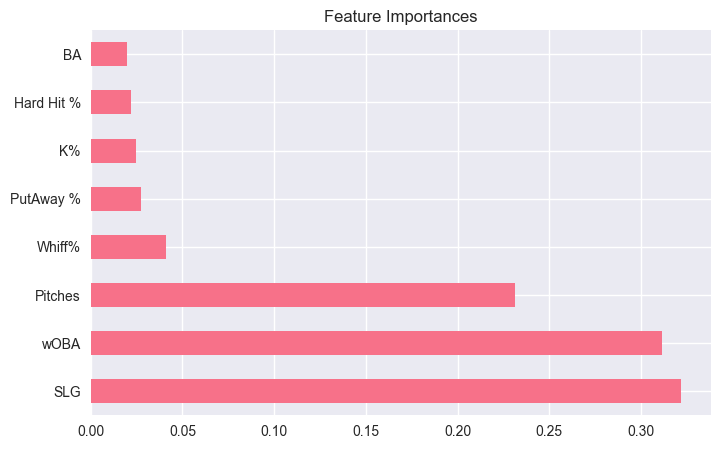

In [87]:
# Importance checks
importances = pd.Series(regressor.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(8, 5), title='Feature Importances')
plt.show()

In [91]:
# =========================
# TEST INPUT
# =========================

# Row Number
obs_index = 180
raw_test_pitch = arsenal_df.loc[[obs_index], pitch_features]

# Hardcoded:
'''
test_pitch = pd.DataFrame({
    'ba': [0.179],
    'slg': [0.393],
    'woba': [0.270],
    'whiff_percent': [18.4],
    'k_percent': [23.3],
    'put_away': [14.7],
    'hard_hit_percent': [52.4]
})
'''

# Impute missing values
imputed_test_pitch = pd.DataFrame(pitch_imputer.transform(raw_test_pitch), columns=pitch_features)

# Apply same weights used in training
for col, weight in feature_weights.items():
    imputed_test_pitch[col] = imputed_test_pitch[col] * weight

# Predict run value
predicted_run_value = regressor.predict(imputed_test_pitch)[0]


# Output
print("\nPlayer:", arsenal_df.loc[obs_index, 'name'], "against", arsenal_df.loc[obs_index, 'Pitch Type'] )
print("=" * 60)
print("\nBatting Average:", arsenal_df.loc[obs_index, 'BA'])
print(f"Slugging Percentage:", arsenal_df.loc[obs_index, 'SLG'])
print(f"Weighted On Base Average:", arsenal_df.loc[obs_index, 'wOBA'])
print(f"Whiff %:", arsenal_df.loc[obs_index, 'Whiff%'])
print(f"Strikeout %:", arsenal_df.loc[obs_index, 'K%'])
print(f"Put Away Rate:", arsenal_df.loc[obs_index, 'PutAway %'])
print(f"Hard Hit %:", arsenal_df.loc[obs_index, 'Hard Hit %'])
print("=" * 60)
print("\nPredicted Run Value for Test Pitch:", round(predicted_run_value, 3))
print(f"Actual Run Value for index {obs_index}:", round(arsenal_df.loc[obs_index, 'Run Value'], 3))


Player: Pages, Andy against Cutter

Batting Average: 0.217
Slugging Percentage: 0.391
Weighted On Base Average: 0.259
Whiff %: 26.5
Strikeout %: 17.4
Put Away Rate: 13.8
Hard Hit %: 42.1

Predicted Run Value for Test Pitch: -0.469
Actual Run Value for index 180: -0.119


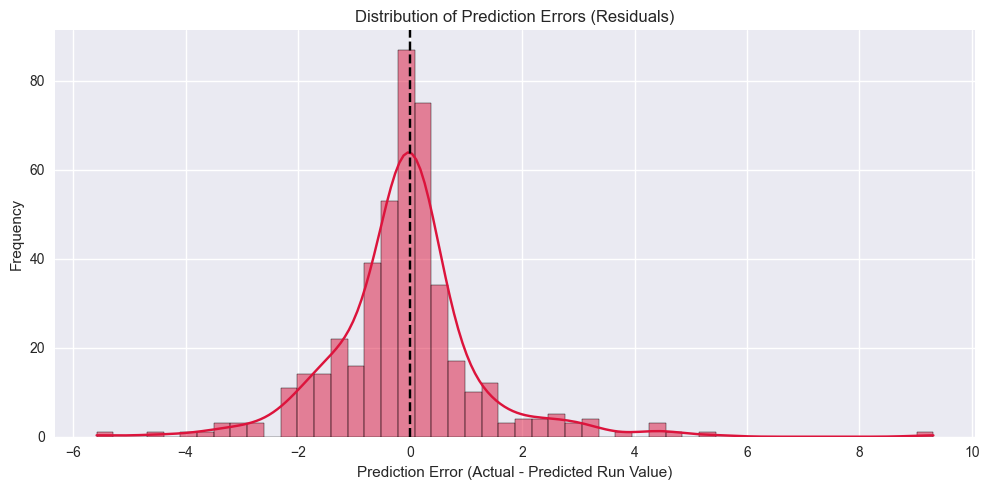

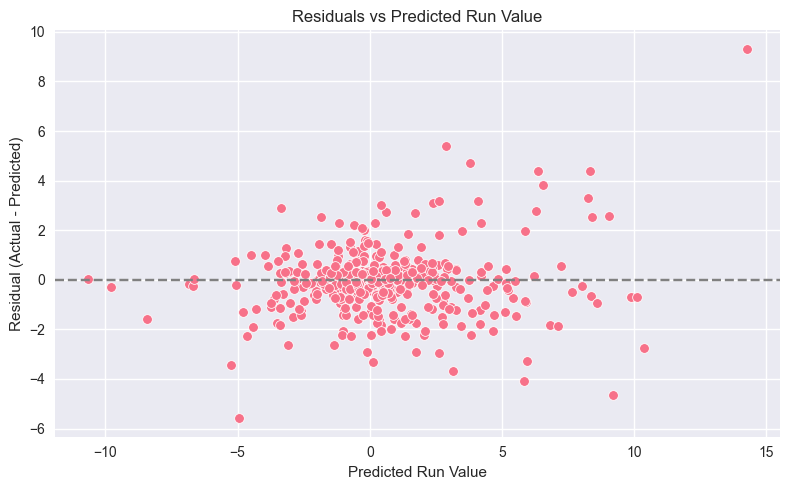

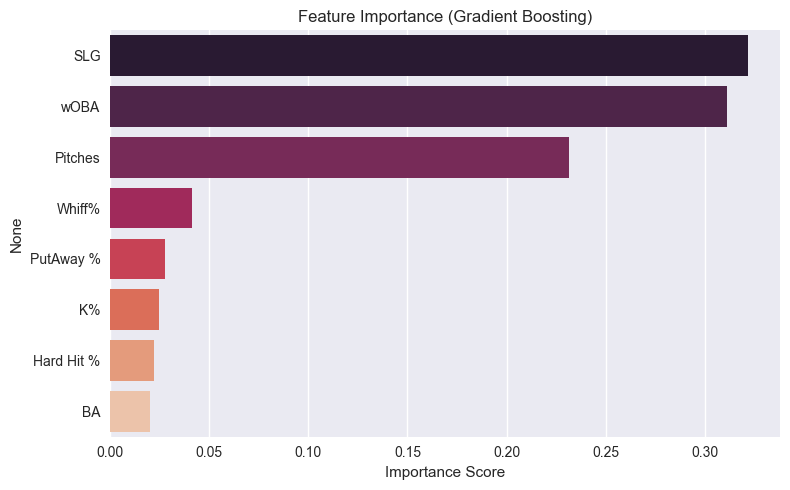

Top 10 Largest Prediction Errors (with corrected actuals and indices):
      actual  predicted  residual  abs_error
247   23.595     14.277     9.318      9.318
1228 -10.540     -4.956    -5.584      5.584
18     8.256      2.869     5.387      5.387
1448   8.507      3.803     4.704      4.704
1809   4.560      9.187    -4.627      4.627
457   12.760      8.353     4.407      4.407
891   10.770      6.383     4.387      4.387
1992  10.770      6.383     4.387      4.387
111    1.752      5.821    -4.069      4.069
1041  10.366      6.550     3.816      3.816


In [92]:
# =========================
# MODEL DIAGNOSTICS & ERROR ANALYSIS
# =========================

# A. Residuals and error spread
residuals = y_valid - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True, color='crimson')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Prediction Error (Actual - Predicted Run Value)")
plt.ylabel("Frequency")
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# B. Residuals vs Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals vs Predicted Run Value")
plt.xlabel("Predicted Run Value")
plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

# C. Feature importance
importances = pd.Series(regressor.feature_importances_, index=pitch_features)
importances = importances.reindex(pitch_features)
sorted_importances = importances.sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=sorted_importances, y=sorted_importances.index, palette="rocket")
plt.title("Feature Importance (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# D. Identify large absolute errors
# Reset index to preserve row IDs for reference
error_df = y_valid.to_frame(name='actual').copy()
error_df['predicted'] = y_pred
error_df['residual'] = error_df['actual'] - error_df['predicted']
error_df['abs_error'] = error_df['residual'].abs()
large_errors = error_df.sort_values('abs_error', ascending=False).head(10)

print("Top 10 Largest Prediction Errors (with corrected actuals and indices):")
print(large_errors[['actual', 'predicted', 'residual', 'abs_error']].round(3))

## Simple EDA Grouped by Swing Type

In [93]:
import pandas as pd

# Assuming your dataframe is final_df
df = final_df.copy()

# Define the variables you want to average
eda_vars = [
    'runs_all', 'runs_heart', 'runs_shadow', 'runs_chase', 'runs_waste',
    'gb_rate', 'air_rate', 'fb_rate', 'ld_rate', 'pu_rate',
    'pull_rate', 'straight_rate', 'oppo_rate',
    'pull_gb_rate', 'straight_gb_rate', 'oppo_gb_rate',
    'pull_air_rate', 'straight_air_rate', 'oppo_air_rate'
]

# Group by swing_archetype and calculate mean
eda_summary = (
    df.groupby('swing_archetype')
    .agg({
        **{var: 'mean' for var in eda_vars},
        'swing_archetype': 'count'
    })
    .rename(columns={'swing_archetype': 'player_count'})
    .reset_index()
    .round(3)
)

# Display the summarized table
print("==== EDA Summary by Swing Archetype ====")
display(eda_summary)

==== EDA Summary by Swing Archetype ====


swing_archetype  runs_all  runs_heart  runs_shadow  runs_chase  \
0                 0     5.917       0.722       -9.021       8.646   
1                 1    -0.228      -7.367       -7.582       9.179   
2                 2    10.395       1.519      -10.223      11.306   
3                 3     5.138      -1.967       -7.926       9.251   
4                 4     9.848       1.239       -7.226       9.432   
5                 5     4.974      -2.477       -8.459       9.786   
6                 6     1.284      -4.532       -9.178       8.826   
7                 7     3.383      -3.470       -8.660       9.353   
8                 8     5.087      -3.616       -9.756      11.369   
9                 9    -0.653      -8.426       -9.340      11.421   
10               10    -2.702     -15.466       -3.466      10.924   
11               11     3.994      -2.552       -8.197       8.647   
12               12    15.015       2.259       -3.650       9.442   
13               13    -4.122     -12.534       -3.272       7.551   

    runs_waste  gb_rate  air_rate  fb_rate  ld_rate  ...  pull_rate  \
0        5.570    0.392     0.608    0.293    0.250  ...      0.418   
1        5.543    0.434     0.566    0.253    0.241  ...      0.376   
2        7.793    0.323     0.677    0.355    0.223  ...      0.464   
3        5.781    0.404     0.596    0.288    0.236  ...      0.426   
4        6.402    0.361     0.639    0.325    0.238  ...      0.444   
5        6.124    0.421     0.579    0.270    0.250  ...      0.380   
6        6.168    0.429     0.571    0.272    0.268  ...      0.417   
7        6.160    0.392     0.608    0.279    0.237  ...      0.441   
8        7.090    0.444     0.556    0.259    0.243  ...      0.358   
9        5.691    0.429     0.571    0.253    0.260  ...      0.352   
10       5.305    0.466     0.534    0.215    0.264  ...      0.313   
11       6.096    0.432     0.568    0.250    0.242  ...      0.370   
12       6.964    0.397     0.603    0.281    0.235  ...      0.458   
13       4.134    0.545     0.455    0.175    0.244  ...      0.277   

    straight_rate  oppo_rate  pull_gb_rate  straight_gb_rate  oppo_gb_rate  \
0           0.364      0.218         0.225             0.136         0.032   
1           0.372      0.253         0.205             0.174         0.055   
2           0.327      0.210         0.191             0.099         0.033   
3           0.340      0.234         0.215             0.144         0.045   
4           0.342      0.214         0.204             0.130         0.028   
5           0.369      0.251         0.210             0.160         0.050   
6           0.325      0.257         0.238             0.135         0.057   
7           0.349      0.210         0.216             0.140         0.036   
8           0.384      0.258         0.209             0.182         0.053   
9           0.369      0.280         0.193             0.174         0.062   
10          0.380      0.306         0.182             0.198         0.086   
11          0.373      0.257         0.206             0.171         0.055   
12          0.341      0.202         0.222             0.137         0.038   
13          0.382      0.340         0.198             0.233         0.114   

    pull_air_rate  straight_air_rate  oppo_air_rate  player_count  
0           0.193              0.229          0.186            11  
1           0.171              0.198          0.197            23  
2           0.273              0.227          0.177            15  
3           0.211              0.197          0.189            23  
4           0.240              0.212          0.186            10  
5           0.170              0.209          0.200            34  
6           0.180              0.190          0.201             5  
7           0.225              0.209          0.174            32  
8           0.149              0.202          0.204            28  
9           0.158              0.195

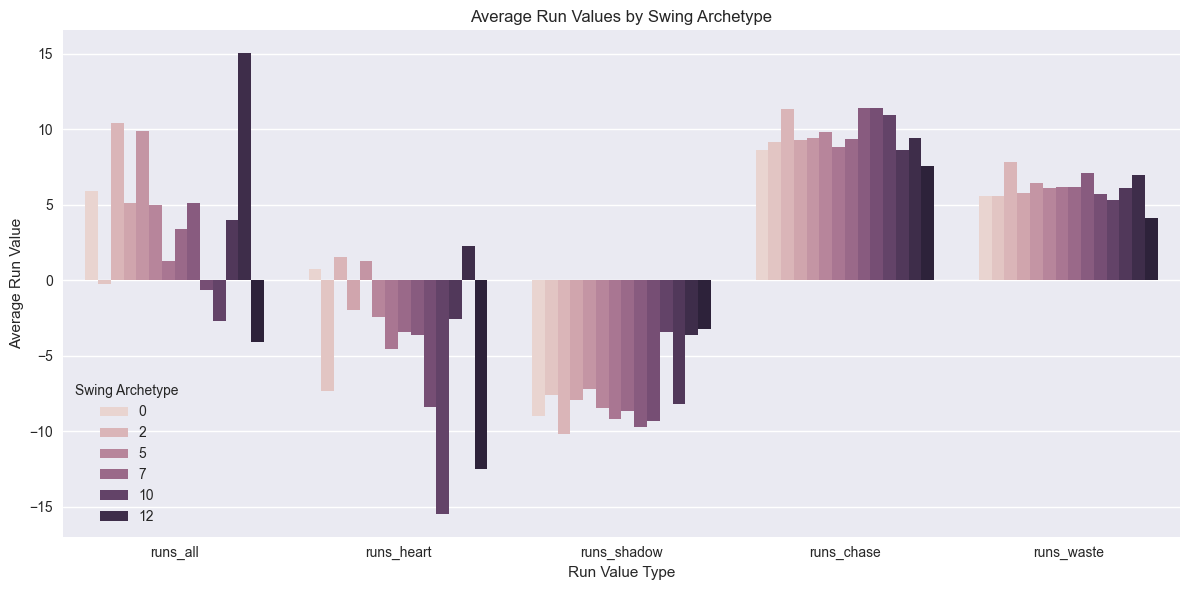

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the dataframe to long format for Seaborn plotting
runval_cols = ['runs_all', 'runs_heart', 'runs_shadow', 'runs_chase', 'runs_waste']
eda_long = eda_summary.melt(id_vars='swing_archetype', value_vars=runval_cols,
                            var_name='Run Value Type', value_name='Value')

plt.figure(figsize=(12,6))
sns.barplot(data=eda_long, x='Run Value Type', y='Value', hue='swing_archetype')
plt.title('Average Run Values by Swing Archetype')
plt.ylabel('Average Run Value')
plt.xlabel('Run Value Type')
plt.legend(title='Swing Archetype')
plt.tight_layout()
plt.show()

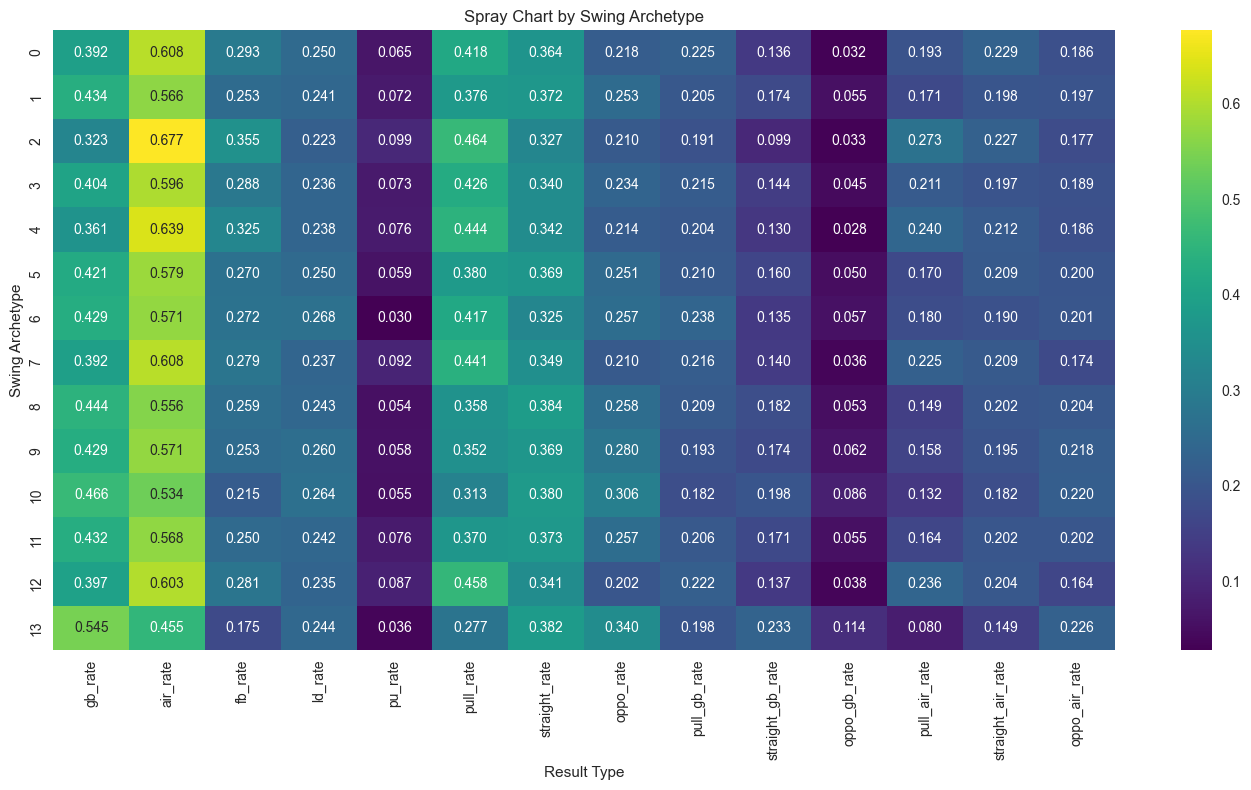

In [95]:
# Define all result rate columns
rate_cols = [
    'gb_rate', 'air_rate', 'fb_rate', 'ld_rate', 'pu_rate',
    'pull_rate', 'straight_rate', 'oppo_rate',
    'pull_gb_rate', 'straight_gb_rate', 'oppo_gb_rate',
    'pull_air_rate', 'straight_air_rate', 'oppo_air_rate'
]

# Prepare data for heatmap
heatmap_df = eda_summary.set_index('swing_archetype')[rate_cols]

plt.figure(figsize=(14,8))
sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap='viridis')
plt.title('Spray Chart by Swing Archetype')
plt.xlabel('Result Type')
plt.ylabel('Swing Archetype')
plt.tight_layout()
plt.show()

## Performance Tier Progression

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class PlayerTierProgressionModel:
    def __init__(self, combined_arsenal_df, final_df):
        """
        Initialize the model with the two main dataframes
        """
        self.combined_arsenal_df = combined_arsenal_df.copy()
        self.final_df = final_df.copy()
        self.merged_df = None
        self.tier_benchmarks = {}
        self.feature_importance = {}
        self.models = {}
        self.scalers = {}
        
        # Define tier hierarchy for progression analysis
        self.tier_hierarchy = {
            'Poor': 1,
            'Below': 2, 
            'Average': 3,
            'Above': 4,
            'Elite': 5,
            'Superstar': 6
        }
        
    def prepare_data(self):
        """
        Merge and prepare the datasets for analysis
        """
        print("Preparing and merging datasets...")
        
        # Merge the datasets on player ID
        self.merged_df = self.combined_arsenal_df.merge(
            self.final_df, 
            on=['id', 'name'], 
            suffixes=('_arsenal', '_overall'),
            how='inner'
        )
        
        # Create tier numeric mapping
        self.merged_df['tier_numeric'] = self.merged_df['performance_tier_arsenal'].map(self.tier_hierarchy)
        
        # Calculate pitch-type specific aggregations for each player
        self.create_pitch_specific_features()
        
        print(f"Merged dataset shape: {self.merged_df.shape}")
        print(f"Performance tier distribution:\n{self.merged_df['performance_tier_arsenal'].value_counts()}")
        
    def create_pitch_specific_features(self):
        """
        Create features that capture player performance against specific pitch types
        """
        print("Creating pitch-specific performance features...")
        
        # Key pitch types to focus on
        pitch_types = ['Fastball', 'Breaking Ball', 'Off-Speed']
        
        # Aggregate metrics by player and pitch type
        pitch_agg = self.merged_df.groupby(['id', 'name', 'Pitch Type']).agg({
            'wOBA': 'mean',
            'xwOBA': 'mean', 
            'Whiff%': 'mean',
            'K%': 'mean',
            'Hard Hit %': 'mean',
            'BA': 'mean',
            'SLG': 'mean',
            'PutAway %': 'mean'
        }).round(3)
        
        # Pivot to create pitch-specific columns
        pitch_features = pitch_agg.unstack('Pitch Type')
        pitch_features.columns = [f"{metric}_{pitch}" for metric, pitch in pitch_features.columns]
        pitch_features = pitch_features.fillna(pitch_features.mean())
        
        # Merge back with main dataset
        player_summary = self.merged_df.groupby(['id', 'name']).first().reset_index()
        self.player_df = player_summary.merge(
            pitch_features.reset_index(), 
            on=['id', 'name'], 
            how='left'
        )
        
    def analyze_tier_benchmarks(self):
        """
        Analyze what separates Elite/Superstar players from lower tiers
        """
        print("Analyzing tier benchmarks...")
        
        # Key metrics to analyze
        key_metrics = [
            'avg_bat_speed', 'swing_tilt', 'attack_angle', 'ideal_attack_angle_rate',
            'woba', 'xwoba', 'brl_percent', 'composite_performance_score'
        ]
        
        # Add pitch-specific metrics
        pitch_metrics = [col for col in self.player_df.columns 
                        if any(pitch in col for pitch in ['Fastball', 'Breaking Ball', 'Off-Speed'])]
        key_metrics.extend(pitch_metrics)
        
        # Calculate benchmarks for Elite/Superstar tiers
        elite_superstar = self.player_df[
            self.player_df['performance_tier_arsenal'].isin(['Elite', 'Superstar'])
        ]
        
        for metric in key_metrics:
            if metric in self.player_df.columns:
                self.tier_benchmarks[metric] = {
                    'elite_mean': elite_superstar[metric].mean(),
                    'elite_std': elite_superstar[metric].std(),
                    'elite_25th': elite_superstar[metric].quantile(0.25),
                    'elite_75th': elite_superstar[metric].quantile(0.75)
                }
        
        return self.tier_benchmarks
    
    def identify_progression_factors(self):
        """
        Identify key factors that differentiate performance tiers
        """
        print("Identifying progression factors...")
        
        # Statistical tests between tiers
        progression_factors = {}
        
        # Compare each lower tier to Elite/Superstar
        target_tiers = ['Elite', 'Superstar'] 
        comparison_tiers = ['Poor', 'Below', 'Average', 'Above']
        
        elite_data = self.player_df[
            self.player_df['performance_tier_arsenal'].isin(target_tiers)
        ]
        
        for tier in comparison_tiers:
            tier_data = self.player_df[
                self.player_df['performance_tier_arsenal'] == tier
            ]
            
            if len(tier_data) > 0:
                progression_factors[tier] = {}
                
                # Analyze key swing mechanics and performance metrics
                key_features = [
                    'avg_bat_speed', 'swing_tilt', 'attack_angle', 'ideal_attack_angle_rate',
                    'swing_length', 'woba', 'xwoba', 'brl_percent', 'Whiff%'
                ]
                
                # Add pitch-specific features
                pitch_features = [col for col in self.player_df.columns 
                                if 'wOBA_' in col or 'Whiff%_' in col or 'Hard Hit %_' in col]
                key_features.extend(pitch_features)
                
                for feature in key_features:
                    if feature in self.player_df.columns and feature in elite_data.columns:
                        try:
                            # T-test to compare means
                            stat, p_value = stats.ttest_ind(
                                elite_data[feature].dropna(),
                                tier_data[feature].dropna()
                            )
                            
                            effect_size = (elite_data[feature].mean() - tier_data[feature].mean()) / \
                                        np.sqrt(((elite_data[feature].std()**2 + tier_data[feature].std()**2) / 2))
                            
                            progression_factors[tier][feature] = {
                                'elite_mean': elite_data[feature].mean(),
                                'tier_mean': tier_data[feature].mean(),
                                'difference': elite_data[feature].mean() - tier_data[feature].mean(),
                                'p_value': p_value,
                                'effect_size': effect_size,
                                'significant': p_value < 0.05,
                                'large_effect': abs(effect_size) > 0.5
                            }
                        except:
                            continue
        
        self.progression_factors = progression_factors
        return progression_factors
    
    def build_prediction_models(self):
        """
        Build machine learning models to predict tier progression
        """
        print("Building prediction models...")
        
        # Prepare features for modeling
        feature_cols = [
            'avg_bat_speed', 'swing_tilt', 'attack_angle', 'ideal_attack_angle_rate',
            'swing_length', 'brl_percent', 'gb_rate', 'air_rate', 'pull_rate',
            'Age'
        ]
        
        # Add pitch-specific features
        pitch_features = [col for col in self.player_df.columns 
                         if any(pitch in col for pitch in ['Fastball', 'Breaking Ball', 'Off-Speed'])]
        feature_cols.extend(pitch_features)
        
        # Filter available features
        available_features = [col for col in feature_cols if col in self.player_df.columns]
        
        X = self.player_df[available_features].fillna(self.player_df[available_features].mean())
        y = self.player_df['tier_numeric']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Scale features
        self.scalers['standard'] = StandardScaler()
        X_train_scaled = self.scalers['standard'].fit_transform(X_train)
        X_test_scaled = self.scalers['standard'].transform(X_test)
        
        # Train multiple models
        models_to_train = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
        }
        
        results = {}
        
        for name, model in models_to_train.items():
            print(f"Training {name}...")
            
            if name == 'Logistic Regression':
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            cv_scores = cross_val_score(model, X_train_scaled if name == 'Logistic Regression' else X_train, 
                                      y_train, cv=5)
            
            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'predictions': y_pred
            }
            
            # Feature importance
            if hasattr(model, 'feature_importances_'):
                feature_imp = pd.DataFrame({
                    'feature': available_features,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                results[name]['feature_importance'] = feature_imp
        
        self.models = results
        self.feature_names = available_features
        return results
    
    def generate_player_recommendations(self, player_id=None, player_name=None):
        """
        Generate specific recommendations for a player to advance to the next tier
        """
        if player_id is None and player_name is None:
            print("Please provide either player_id or player_name")
            return None
            
        # Find player
        if player_id:
            player_data = self.player_df[self.player_df['id'] == player_id]
        else:
            player_data = self.player_df[self.player_df['name'] == player_name]
            
        if len(player_data) == 0:
            print("Player not found")
            return None
            
        player = player_data.iloc[0]
        current_tier = player['performance_tier_arsenal']
        current_tier_num = self.tier_hierarchy[current_tier]
        
        # Determine target tier
        if current_tier_num < 6:
            target_tiers = [tier for tier, num in self.tier_hierarchy.items() 
                          if num > current_tier_num]
            next_tier = min(target_tiers, key=lambda x: self.tier_hierarchy[x])
        else:
            print(f"Player {player['name']} is already in the highest tier (Superstar)")
            return None
        
        print(f"\n=== PLAYER DEVELOPMENT RECOMMENDATIONS ===")
        print(f"Player: {player['name']}")
        print(f"Current Tier: {current_tier}")
        print(f"Target Tier: {next_tier}")
        print("=" * 50)
        
        # Display current player metrics
        print(f"\n=== CURRENT PLAYER METRICS ===")
        print("-" * 35)
        
        # Lead with swing type for context - FIRST
        if 'swing_archetype' in player_data.columns:
            swing_type = player['swing_archetype']
            print(f"SWING ARCHETYPE: {swing_type}")
            print(f"This provides context for interpreting all metrics below")
            print("-" * 35)
        
        # Core swing mechanics
        key_metrics = {
            'avg_bat_speed': 'Bat Speed (mph)',
            'swing_tilt': 'Swing Tilt (degrees)',
            'attack_angle': 'Attack Angle (degrees)', 
            'attack_direction': 'Attack Direction',
            'avg_intercept_y_vs_batter': 'Contact Point vs Batter (inches)',
            'stance_archetype': 'Stance Type'
        }
        
        for metric, display_name in key_metrics.items():
            if metric in player_data.columns:
                value = player[metric]
                if isinstance(value, (int, float)):
                    print(f"{display_name}: {value:.2f}")
                else:
                    print(f"{display_name}: {value}")
        
        # Performance metrics with expanded list
        print(f"\nPerformance Metrics:")
        perf_metrics = {
            'woba': 'wOBA',
            'slg': 'SLG',
            'est_slg': 'Expected SLG',
            'xiso': 'xISO', 
            'xobp': 'xOBP',
            'brl_percent': 'Barrel %',
            'Hard Hit %': 'Hard Hit %',
            'Whiff%': 'Whiff %'
        }
        
        for metric, display_name in perf_metrics.items():
            if metric in player_data.columns:
                value = player[metric]
                if isinstance(value, (int, float)):
                    print(f"{display_name}: {value:.3f}")
        
        # Zone performance metrics
        print(f"\nZone Performance (Run Values):")
        zone_metrics = {
            'runs_heart': 'Heart Zone Runs',
            'runs_shadow': 'Shadow Zone Runs', 
            'runs_chase': 'Chase Zone Runs',
            'runs_waste': 'Waste Zone Runs'
        }
        
        for metric, display_name in zone_metrics.items():
            if metric in player_data.columns:
                value = player[metric]
                if isinstance(value, (int, float)):
                    print(f"{display_name}: {value:.3f}")
        
        # Tier-specific performance analysis
        self.analyze_tier_performance_gaps(player, current_tier, next_tier)
        
    def analyze_tier_performance_gaps(self, player, current_tier, target_tier):
        """
        Analyze what performance metrics the player needs to improve to reach the next tier
        """
        print(f"\n=== TIER PROGRESSION ANALYSIS ===")
        print(f"Current Tier: {current_tier} → Target Tier: {target_tier}")
        print("-" * 45)
        
        # Get target tier players for benchmarking
        target_players = self.player_df[
            self.player_df['performance_tier_arsenal'] == target_tier
        ]
        
        if len(target_players) == 0:
            print(f"No players found in {target_tier} tier for comparison")
            return
        
        # Calculate target tier benchmarks
        performance_metrics = [
            'woba', 'slg', 'est_slg', 'xiso', 'xobp', 'brl_percent', 
            'Hard Hit %', 'Whiff%', 'runs_heart', 'runs_shadow', 
            'runs_chase', 'runs_waste'
        ]
        
        gaps_analysis = []
        
        for metric in performance_metrics:
            if metric in self.player_df.columns and metric in target_players.columns:
                # Calculate target tier benchmarks
                tier_mean = target_players[metric].mean()
                tier_25th = target_players[metric].quantile(0.25)
                tier_75th = target_players[metric].quantile(0.75)
                
                # Get player's current value
                player_value = player.get(metric, 0)
                
                # Calculate gap
                gap = tier_mean - player_value
                gap_25th = tier_25th - player_value
                
                # Determine if improvement is needed
                needs_improvement = False
                priority_level = "Low"
                
                if metric in ['Whiff%']:  # Lower is better
                    if player_value > tier_75th:
                        needs_improvement = True
                        priority_level = "High" if player_value > tier_mean + (tier_75th - tier_mean) else "Medium"
                        gap = player_value - tier_mean  # Positive gap means need to reduce
                else:  # Higher is better
                    if player_value < tier_25th:
                        needs_improvement = True
                        priority_level = "High" if player_value < tier_mean - (tier_mean - tier_25th) else "Medium"
                
                if needs_improvement:
                    gaps_analysis.append({
                        'metric': metric,
                        'player_value': player_value,
                        'tier_mean': tier_mean,
                        'tier_25th': tier_25th,
                        'tier_75th': tier_75th,
                        'gap': abs(gap),
                        'priority': priority_level,
                        'direction': 'decrease' if metric in ['Whiff%'] else 'increase'
                    })
        
        # Sort by priority and gap size
        priority_order = {'High': 3, 'Medium': 2, 'Low': 1}
        gaps_analysis.sort(key=lambda x: (priority_order[x['priority']], x['gap']), reverse=True)
        
        if gaps_analysis:
            print(f"PERFORMANCE GAPS TO ADDRESS:")
            print("-" * 35)
            
            for i, gap in enumerate(gaps_analysis, 1):
                metric = gap['metric']
                display_name = self.get_metric_display_name(metric)
                player_val = gap['player_value']
                tier_mean = gap['tier_mean']
                direction = gap['direction']
                priority = gap['priority']
                gap_size = gap['gap']
                
                print(f"{i}. {display_name} [{priority} Priority]")
                print(f"   Current: {player_val:.3f}")
                print(f"   {target_tier} Avg: {tier_mean:.3f}")
                print(f"   Need to {direction}: {gap_size:.3f}")
                
                # Add context about what this improvement means
                impact_text = self.get_performance_impact_context(metric, gap_size, direction)
                if impact_text:
                    print(f"   Impact: {impact_text}")
                print()
        else:
            print("Player's performance metrics are already at or above target tier levels!")
            print("Focus should be on consistency and mechanical refinements.")
    
    def get_metric_display_name(self, metric):
        """
        Get display name for metrics
        """
        display_names = {
            'woba': 'wOBA',
            'slg': 'SLG',
            'est_slg': 'Expected SLG',
            'xiso': 'xISO',
            'xobp': 'xOBP',
            'brl_percent': 'Barrel %',
            'Hard Hit %': 'Hard Hit %',
            'Whiff%': 'Whiff %',
            'runs_heart': 'Heart Zone Runs',
            'runs_shadow': 'Shadow Zone Runs',
            'runs_chase': 'Chase Zone Runs',
            'runs_waste': 'Waste Zone Runs'
        }
        return display_names.get(metric, metric.replace('_', ' ').title())
    
    def get_performance_impact_context(self, metric, gap_size, direction):
        """
        Provide context about what performance improvements mean
        """
        impact_contexts = {
            'woba': f"Each 0.010 increase ≈ 10-15 points of wRC+",
            'slg': f"Each 0.050 increase ≈ significant power boost",
            'xiso': f"Indicates power potential - mechanical adjustments needed",
            'brl_percent': f"Each 1% increase ≈ 0.030 SLG improvement", 
            'Whiff%': f"Each 2% decrease ≈ 0.015 wOBA improvement",
            'Hard Hit %': f"Each 5% increase ≈ meaningful contact quality boost",
            'runs_heart': f"Heart zone performance critical for elite hitting",
            'runs_shadow': f"Shadow zone discipline separates good from great",
            'runs_chase': f"Chase zone improvement = better plate discipline",
            'runs_waste': f"Waste zone performance indicates selectivity"
        }
        
        base_context = impact_contexts.get(metric, "")
        
        if metric == 'brl_percent' and gap_size > 2:
            return f"{base_context} - Large gap suggests mechanical issues"
        elif metric == 'Whiff%' and gap_size > 5:
            return f"{base_context} - High whiff rate suggests timing/recognition issues"
        elif metric in ['runs_heart', 'runs_shadow'] and gap_size > 2:
            return f"{base_context} - Zone performance gap indicates approach adjustments needed"
        
        return base_context
        
        # Generate mechanical adjustment recommendations
        print(f"\n=== MECHANICAL ADJUSTMENT RECOMMENDATIONS ===")
        print("-" * 50)
        
        # Analyze swing mechanics for specific adjustments
        mechanical_recs = self.analyze_swing_mechanics(player)
        
        if mechanical_recs:
            priority_count = 1
            for rec in mechanical_recs:
                print(f"\n{priority_count}. {rec['title']}")
                print(f"   Current: {rec['current_description']}")
                print(f"   Target Adjustment: {rec['target_adjustment']}")
                print(f"   Expected Impact: {rec['expected_impact']}")
                priority_count += 1
        
        recommendations['mechanical_adjustments'] = mechanical_recs
        
        return recommendations
    
    def analyze_swing_mechanics(self, player):
        """
        Analyze swing mechanics and provide specific numerical adjustments
        """
        recommendations = []
        
        # Get player's current metrics
        bat_speed = player.get('avg_bat_speed', 0)
        swing_tilt = player.get('swing_tilt', 0)
        attack_angle = player.get('attack_angle', 0)
        attack_direction = player.get('attack_direction', 0)
        contact_point = player.get('avg_intercept_y_vs_batter', 0)
        barrel_pct = player.get('brl_percent', 0)
        whiff_pct = player.get('Whiff%', player.get('whiff%', 0))
        hard_hit_pct = player.get('Hard Hit %', 0)
        
        # Elite benchmarks (from tier analysis)
        elite_bat_speed = 75.0  # mph
        elite_barrel_pct = 8.0  # %
        elite_whiff_pct = 22.0  # %
        elite_hard_hit_pct = 45.0  # %
        
        # 1. BAT SPEED ANALYSIS
        if bat_speed < elite_bat_speed - 2:  # More than 2 mph below elite
            speed_deficit = elite_bat_speed - bat_speed
            
            # Analyze contact point relationship
            if contact_point > 22:  # Deep contact point
                recommendations.append({
                    'title': 'CONTACT POINT OPTIMIZATION',
                    'current_description': f"Bat Speed: {bat_speed:.1f} mph, Contact Point: {contact_point:.1f}\" behind batter",
                    'target_adjustment': f"Move contact point forward by {(contact_point - 20):.1f} inches to ~20\" behind batter",
                    'expected_impact': f"Should increase effective bat speed by {speed_deficit * 0.6:.1f} mph and improve barrel rate by {(contact_point - 20) * 0.4:.1f}%"
                })
            elif bat_speed < 72:  # Low bat speed regardless of contact
                recommendations.append({
                    'title': 'BAT SPEED DEVELOPMENT',
                    'current_description': f"Bat Speed: {bat_speed:.1f} mph (Below average)",
                    'target_adjustment': f"Increase bat speed by {speed_deficit:.1f} mph through strength training and swing efficiency",
                    'expected_impact': f"Target {elite_bat_speed:.1f} mph will improve hard hit rate by ~{speed_deficit * 2:.1f}%"
                })
        
        # 2. SWING PLANE ANALYSIS
        if abs(swing_tilt) > 15 or attack_angle < -5 or attack_angle > 12:
            if swing_tilt < -15:  # Too steep down
                recommendations.append({
                    'title': 'SWING PLANE CORRECTION - REDUCE DOWNWARD TILT',
                    'current_description': f"Swing Tilt: {swing_tilt:.1f}° (Too steep down), Attack Angle: {attack_angle:.1f}°",
                    'target_adjustment': f"Flatten swing tilt by {abs(swing_tilt + 10):.1f}° to ~-10°, optimize attack angle to 6-8°",
                    'expected_impact': f"Should reduce whiff rate by {abs(swing_tilt + 10) * 0.8:.1f}% and increase barrel rate by {abs(swing_tilt + 10) * 0.3:.1f}%"
                })
            elif swing_tilt > 15:  # Too steep up
                recommendations.append({
                    'title': 'SWING PLANE CORRECTION - REDUCE UPWARD TILT', 
                    'current_description': f"Swing Tilt: {swing_tilt:.1f}° (Too steep up), Attack Angle: {attack_angle:.1f}°",
                    'target_adjustment': f"Reduce swing tilt by {swing_tilt - 12:.1f}° to ~12°, maintain attack angle 6-8°",
                    'expected_impact': f"Should improve contact quality and reduce pop-ups by {(swing_tilt - 12) * 0.5:.1f}%"
                })
        
        # 3. DIRECTIONAL APPROACH ANALYSIS
        if attack_direction < 6.5 or attack_direction > 8.5:  # Outside optimal pull-to-oppo range
            if attack_direction < 6.5:  # Too pull-heavy
                recommendations.append({
                    'title': 'DIRECTIONAL BALANCE - REDUCE PULL TENDENCY',
                    'current_description': f"Attack Direction: {attack_direction:.2f} (Too pull-oriented)",
                    'target_adjustment': f"Adjust approach by {7.0 - attack_direction:.2f} points toward center field (target: 7.0-7.5)",
                    'expected_impact': f"Should improve situational hitting and reduce defensive shifts impact by expanding effective hitting zones"
                })
            elif attack_direction > 8.5:  # Too opposite field
                recommendations.append({
                    'title': 'DIRECTIONAL BALANCE - INCREASE PULL POWER',
                    'current_description': f"Attack Direction: {attack_direction:.2f} (Too opposite field oriented)",
                    'target_adjustment': f"Adjust approach by {attack_direction - 7.5:.2f} points toward pull side (target: 7.0-7.5)",
                    'expected_impact': f"Should increase power output and barrel rate by utilizing stronger swing mechanics"
                })
        
        # 4. COMBINED MECHANICAL ISSUES (Jackson Holliday example)
        if bat_speed < 72 and attack_direction > 8.0 and contact_point > 24:
            recommendations.append({
                'title': 'COMPREHENSIVE SWING OVERHAUL - TIMING & CONTACT OPTIMIZATION',
                'current_description': f"Low bat speed ({bat_speed:.1f} mph) + opposite field tendency ({attack_direction:.2f}) + deep contact ({contact_point:.1f}\")",
                'target_adjustment': f"Move contact point forward by {contact_point - 20:.1f}\", reduce opposite field tendency by {attack_direction - 7.2:.2f} points",
                'expected_impact': f"Should increase effective bat speed by {(contact_point - 20) * 0.3 + (attack_direction - 7.2) * 0.8:.1f} mph and improve barrel rate by {(contact_point - 20) * 0.5:.1f}%"
            })
        
        # 5. PERFORMANCE-SPECIFIC ADJUSTMENTS
        if whiff_pct > elite_whiff_pct + 5:
            whiff_excess = whiff_pct - elite_whiff_pct
            recommendations.append({
                'title': 'CONTACT IMPROVEMENT - WHIFF RATE REDUCTION',
                'current_description': f"Whiff Rate: {whiff_pct:.1f}% (Target: <{elite_whiff_pct:.1f}%)",
                'target_adjustment': f"Reduce whiff rate by {whiff_excess:.1f}% through timing consistency and swing path optimization",
                'expected_impact': f"Each 2% whiff reduction should improve wOBA by ~0.015 points"
            })
        
        if barrel_pct < elite_barrel_pct - 2:
            barrel_deficit = elite_barrel_pct - barrel_pct
            recommendations.append({
                'title': 'BARREL RATE OPTIMIZATION',
                'current_description': f"Barrel Rate: {barrel_pct:.1f}% (Target: >{elite_barrel_pct:.1f}%)",
                'target_adjustment': f"Increase barrel rate by {barrel_deficit:.1f}% through swing path and timing adjustments",
                'expected_impact': f"Each 1% barrel increase should improve SLG by ~0.030 points"
            })
        
        return recommendations
    
    def generate_specific_recommendation(self, feature, current_value, target_value, gap):
        """
        This method is kept for backward compatibility but replaced by analyze_swing_mechanics
        """
        return f"See mechanical analysis for specific numerical adjustments"
    
    def create_development_dashboard(self):
        """
        Create visualizations for the player development insights
        """
        print("Creating development dashboard...")
        
        # Create comprehensive dashboard with multiple subplots
        fig = plt.figure(figsize=(20, 16))
        fig.suptitle('Player Development EDA Dashboard', fontsize=18, fontweight='bold')
        
        # Define tier order for consistent plotting
        tier_order = ['Poor', 'Below', 'Average', 'Above', 'Elite', 'Superstar']
        tier_colors = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'darkgreen']
        
        # 1. Tier Distribution (top left)
        ax1 = plt.subplot(3, 3, 1)
        tier_counts = self.player_df['performance_tier_arsenal'].value_counts()
        bars = ax1.bar(tier_counts.index, tier_counts.values, color=tier_colors)
        ax1.set_title('Player Distribution by Performance Tier', fontweight='bold')
        ax1.set_ylabel('Number of Players')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom')
        
        # 2. Feature Importance (top middle)
        ax2 = plt.subplot(3, 3, 2)
        if self.models:
            best_model_name = max(self.models.keys(), key=lambda x: self.models[x]['accuracy'])
            if 'feature_importance' in self.models[best_model_name]:
                feature_imp = self.models[best_model_name]['feature_importance'].head(10)
                bars = ax2.barh(feature_imp['feature'], feature_imp['importance'])
                ax2.set_title(f'Top Features for Tier Prediction\n({best_model_name})', fontweight='bold')
                ax2.set_xlabel('Feature Importance')
                
                # Color bars by importance
                colors = plt.cm.viridis(feature_imp['importance'] / feature_imp['importance'].max())
                for bar, color in zip(bars, colors):
                    bar.set_color(color)
        
        # 3. Bat Speed vs Performance Tier (top right)
        ax3 = plt.subplot(3, 3, 3)
        if 'avg_bat_speed' in self.player_df.columns:
            sns.boxplot(data=self.player_df, x='performance_tier_arsenal', y='avg_bat_speed', 
                       order=tier_order, palette=tier_colors, ax=ax3)
            ax3.set_title('Bat Speed Distribution by Tier', fontweight='bold')
            ax3.set_xlabel('Performance Tier')
            ax3.set_ylabel('Average Bat Speed (mph)')
            ax3.tick_params(axis='x', rotation=45)
        
        # 4. wOBA vs Tier (middle left)
        ax4 = plt.subplot(3, 3, 4)
        if 'woba' in self.player_df.columns:
            sns.boxplot(data=self.player_df, x='performance_tier_arsenal', y='woba', 
                       order=tier_order, palette=tier_colors, ax=ax4)
            ax4.set_title('wOBA Distribution by Tier', fontweight='bold')
            ax4.set_xlabel('Performance Tier')
            ax4.set_ylabel('wOBA')
            ax4.tick_params(axis='x', rotation=45)
        
        # 5. SLG vs Tier (middle center)
        ax5 = plt.subplot(3, 3, 5)
        if 'slg' in self.player_df.columns:
            sns.boxplot(data=self.player_df, x='performance_tier_arsenal', y='slg', 
                       order=tier_order, palette=tier_colors, ax=ax5)
            ax5.set_title('SLG Distribution by Tier', fontweight='bold')
            ax5.set_xlabel('Performance Tier')
            ax5.set_ylabel('Slugging Percentage')
            ax5.tick_params(axis='x', rotation=45)
        
        # 6. Barrel Percentage vs Tier (middle right)
        ax6 = plt.subplot(3, 3, 6)
        if 'brl_percent' in self.player_df.columns:
            sns.boxplot(data=self.player_df, x='performance_tier_arsenal', y='brl_percent', 
                       order=tier_order, palette=tier_colors, ax=ax6)
            ax6.set_title('Barrel % Distribution by Tier', fontweight='bold')
            ax6.set_xlabel('Performance Tier')
            ax6.set_ylabel('Barrel Percentage')
            ax6.tick_params(axis='x', rotation=45)
        
        # 7. Ideal Attack Angle Rate vs Tier (bottom left)
        ax7 = plt.subplot(3, 3, 7)
        if 'ideal_attack_angle_rate' in self.player_df.columns:
            sns.boxplot(data=self.player_df, x='performance_tier_arsenal', y='ideal_attack_angle_rate', 
                       order=tier_order, palette=tier_colors, ax=ax7)
            ax7.set_title('Ideal Attack Angle Rate by Tier', fontweight='bold')
            ax7.set_xlabel('Performance Tier')
            ax7.set_ylabel('Ideal Attack Angle Rate')
            ax7.tick_params(axis='x', rotation=45)
        
        # 8. Whiff% vs Tier (bottom center) - using arsenal data if available
        ax8 = plt.subplot(3, 3, 8)
        whiff_col = None
        if 'Whiff%' in self.player_df.columns:
            whiff_col = 'Whiff%'
        elif 'whiff%' in self.player_df.columns:
            whiff_col = 'whiff%'
        
        if whiff_col:
            sns.boxplot(data=self.player_df, x='performance_tier_arsenal', y=whiff_col, 
                       order=tier_order, palette=tier_colors, ax=ax8)
            ax8.set_title('Whiff % Distribution by Tier', fontweight='bold')
            ax8.set_xlabel('Performance Tier')
            ax8.set_ylabel('Whiff Percentage')
            ax8.tick_params(axis='x', rotation=45)
        
        # 9. xISO vs Tier (bottom right)
        ax9 = plt.subplot(3, 3, 9)
        if 'xiso' in self.player_df.columns:
            sns.boxplot(data=self.player_df, x='performance_tier_arsenal', y='xiso', 
                       order=tier_order, palette=tier_colors, ax=ax9)
            ax9.set_title('xISO Distribution by Tier', fontweight='bold')
            ax9.set_xlabel('Performance Tier')
            ax9.set_ylabel('Expected Isolated Power')
            ax9.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Create additional correlation heatmap
        self.create_correlation_heatmap()
        
        return fig
    
    def create_correlation_heatmap(self):
        """
        Create a correlation heatmap of key performance metrics
        """
        print("Creating correlation heatmap...")
        
        # Select key metrics for correlation analysis
        correlation_metrics = [
            'avg_bat_speed', 'swing_tilt', 'attack_angle', 'ideal_attack_angle_rate',
            'woba', 'slg', 'brl_percent', 'xiso', 'composite_performance_score',
            'tier_numeric'
        ]
        
        # Add whiff% if available
        if 'Whiff%' in self.player_df.columns:
            correlation_metrics.append('Whiff%')
        elif 'whiff%' in self.player_df.columns:
            correlation_metrics.append('whiff%')
        
        # Filter available metrics
        available_metrics = [col for col in correlation_metrics if col in self.player_df.columns]
        
        if len(available_metrics) > 2:
            plt.figure(figsize=(12, 10))
            correlation_matrix = self.player_df[available_metrics].corr()
            
            mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
            sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
                       center=0, square=True, linewidths=0.5)
            plt.title('Player Development Metrics Correlation Matrix', fontweight='bold', pad=20)
            plt.tight_layout()
            plt.show()
    
    def run_full_analysis(self):
        """
        Run the complete analysis pipeline
        """
        print("Starting Player Tier Progression Analysis...")
        print("=" * 50)
        
        # Step 1: Prepare data
        self.prepare_data()
        
        # Step 2: Analyze benchmarks
        self.analyze_tier_benchmarks()
        
        # Step 3: Identify progression factors
        self.identify_progression_factors()
        
        # Step 4: Build prediction models
        model_results = self.build_prediction_models()
        
        # Step 5: Create dashboard
        self.create_development_dashboard()
        
        print("\n" + "=" * 50)
        print("ANALYSIS COMPLETE!")
        print("=" * 50)
        
        # Print model performance summary
        print("\nMODEL PERFORMANCE SUMMARY:")
        print("-" * 30)
        for name, results in model_results.items():
            print(f"{name}:")
            print(f"  Accuracy: {results['accuracy']:.3f}")
            print(f"  CV Score: {results['cv_mean']:.3f} (±{results['cv_std']:.3f})")
            print()
        
        return {
            'tier_benchmarks': self.tier_benchmarks,
            'progression_factors': self.progression_factors,
            'models': self.models,
            'player_data': self.player_df
        }

##### Model Analysis

Starting Player Tier Progression Analysis...
Preparing and merging datasets...
Creating pitch-specific performance features...
Merged dataset shape: (3478, 92)
Performance tier distribution:
performance_tier_arsenal
Average      942
Below        752
Poor         678
Above        529
Elite        363
Superstar    214
Name: count, dtype: int64
Analyzing tier benchmarks...
Identifying progression factors...
Building prediction models...
Training Random Forest...
Training Gradient Boosting...
Training Logistic Regression...
Creating development dashboard...


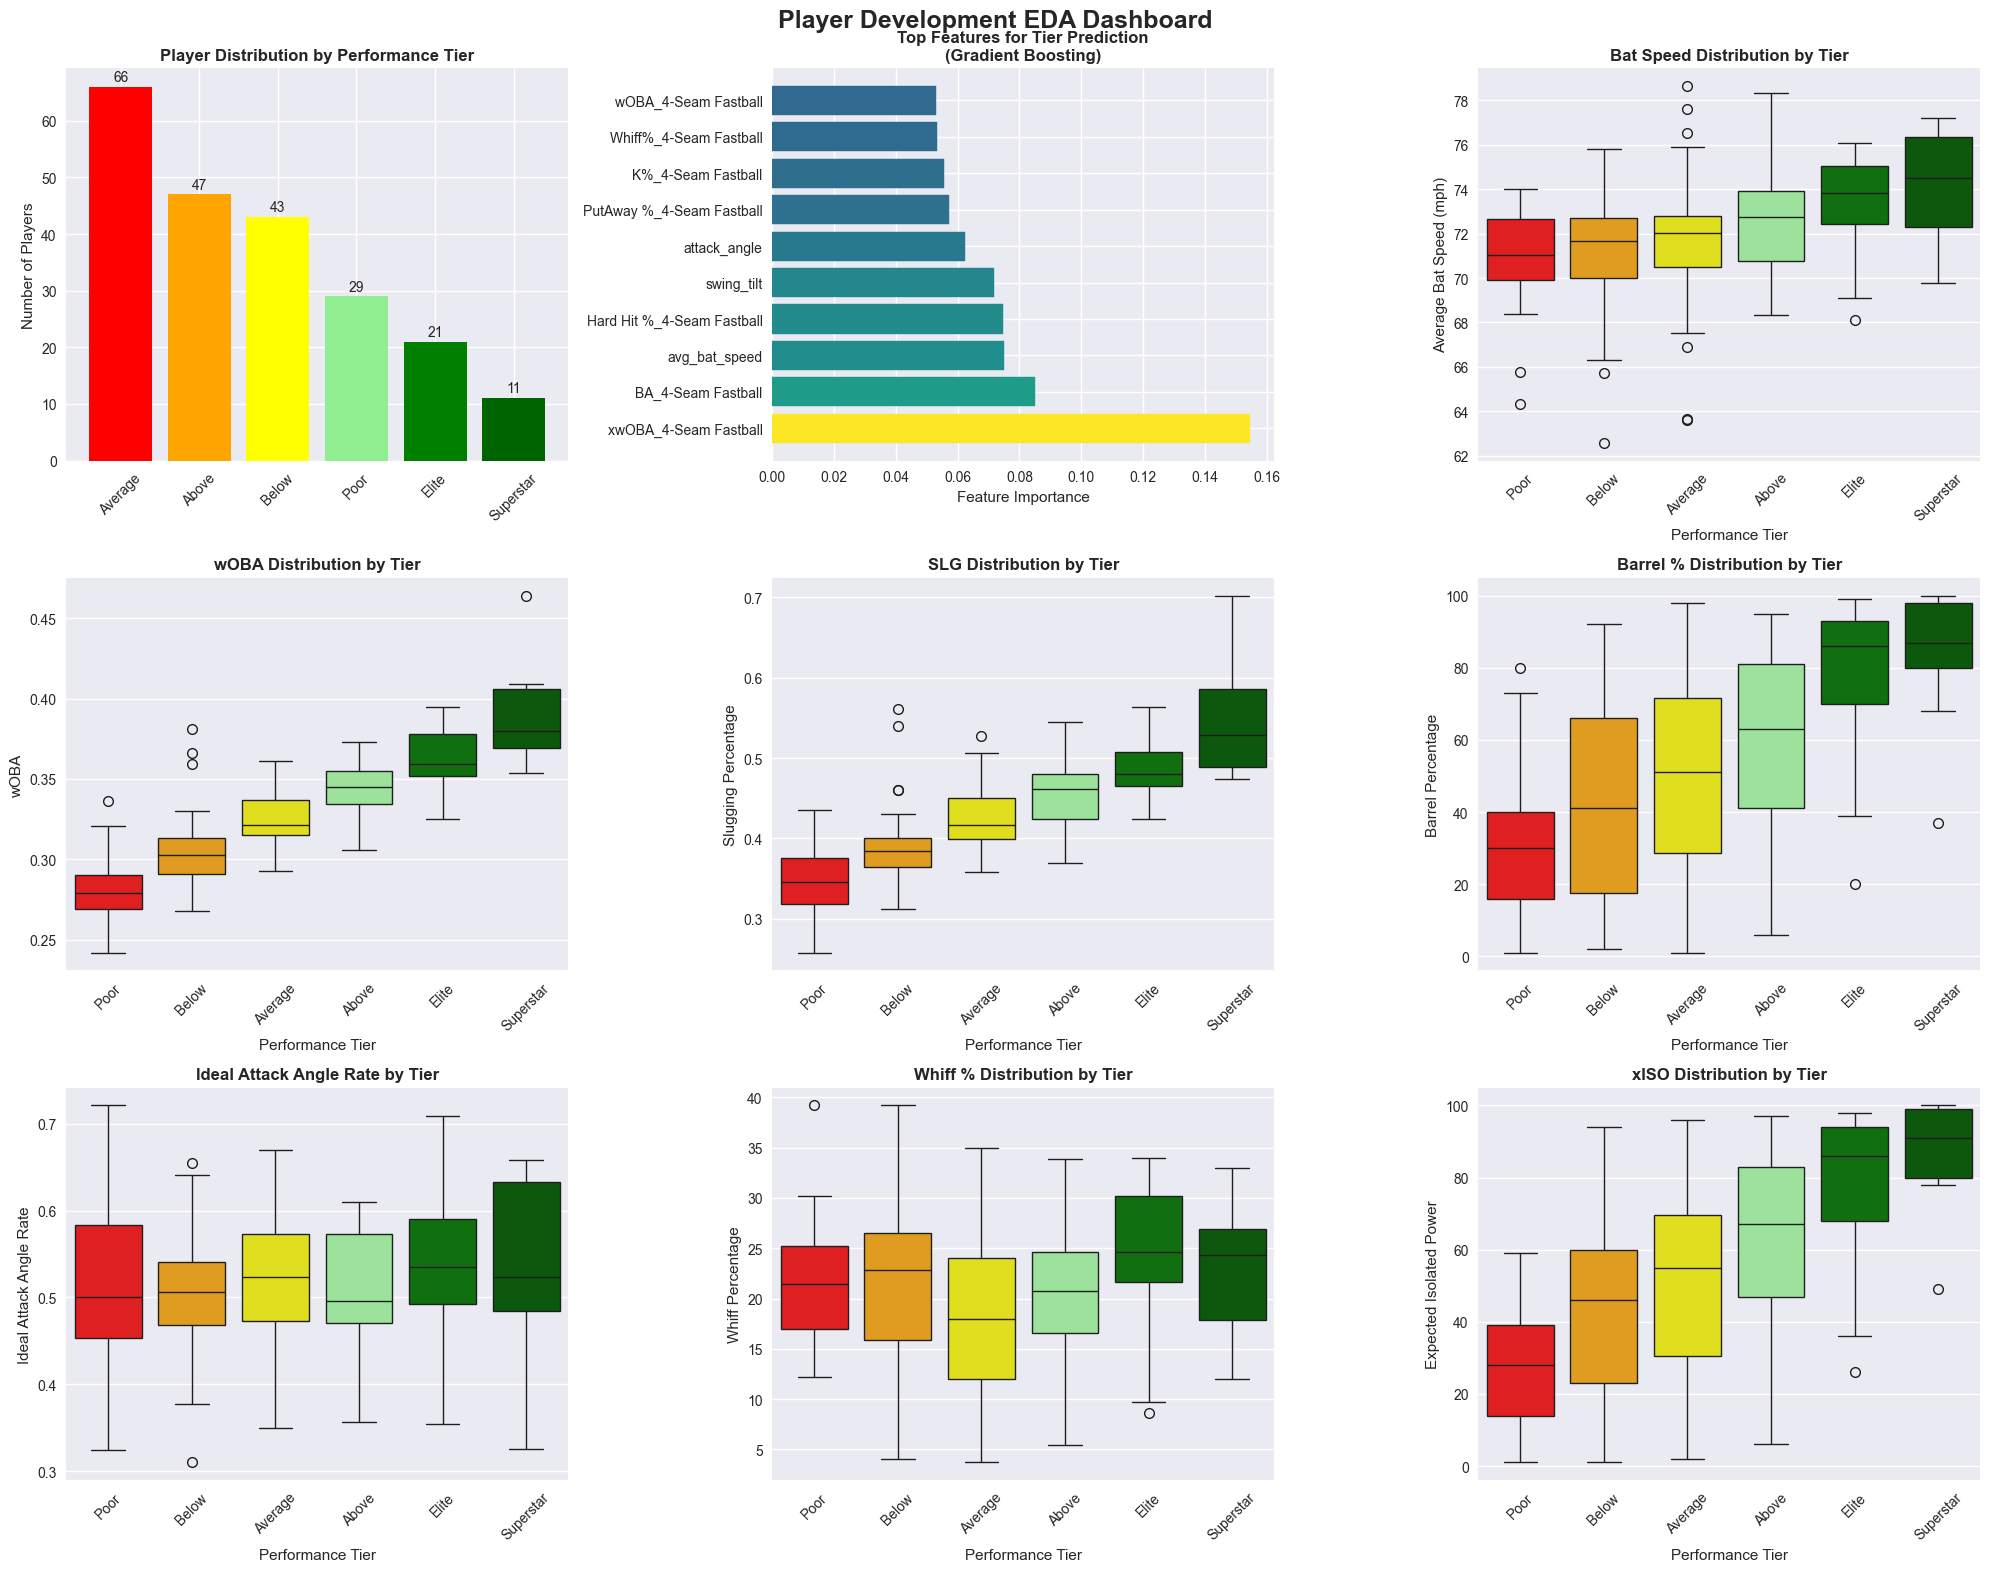

Creating correlation heatmap...


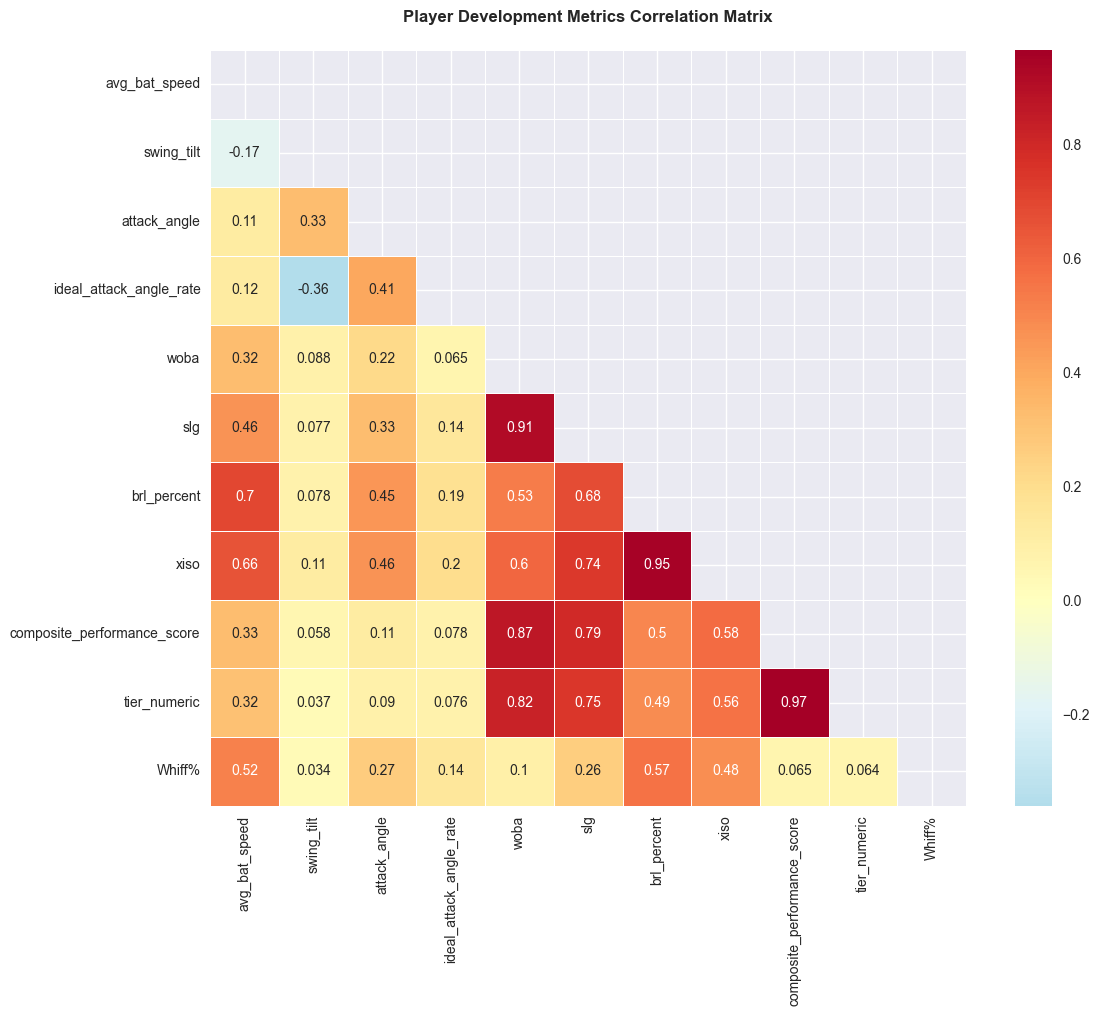


ANALYSIS COMPLETE!

MODEL PERFORMANCE SUMMARY:
------------------------------
Random Forest:
  Accuracy: 0.364
  CV Score: 0.353 (±0.071)

Gradient Boosting:
  Accuracy: 0.432
  CV Score: 0.341 (±0.060)

Logistic Regression:
  Accuracy: 0.318
  CV Score: 0.335 (±0.049)



In [97]:
# Initialize the model
model = PlayerTierProgressionModel(combined_arsenal_df, final_df)

# Run complete analysis
results = model.run_full_analysis()

##### Get Recs

In [98]:
## Fuzzy Matching Names to get ID ##
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def get_player_id_fuzzy(player_name_input, players_df, score_threshold=75):
    """
    Finds the player ID based on a fuzzy match of the input name.

    Args:
        player_name_input (str): The name entered by the user (e.g., 'adam chow', 'ronald acuna jr').
        players_df (pd.DataFrame): The DataFrame containing player 'id' and 'name' columns.
        score_threshold (int): The minimum fuzzy matching score (0-100) required to consider a match valid.

    Returns:
        int or None: The player ID of the best match if above the threshold, otherwise None.
    """
    
    # Extract all player names from your DataFrame for comparison
    player_names_in_data = players_df['name'].tolist()

    # Use process.extractOne to find the best match and its score
    # fuzz.token_set_ratio is robust for partial matches and different word orders
    # (e.g., 'Adam Chow' vs 'Chow, Adam')
    best_match = process.extractOne(player_name_input, player_names_in_data, scorer=fuzz.token_set_ratio)

    if best_match:
        matched_name, score = best_match[0], best_match[1]
        
        print(f"Input: '{player_name_input}' | Best Matched Name: '{matched_name}' | Score: {score}")

        if score >= score_threshold:
            # Find the ID for the matched name
            player_id = players_df[players_df['name'] == matched_name]['id'].iloc[0]
            print(f"{matched_name} Player ID: {player_id}")
            return player_id
        else:
            print(f"No strong match found for '{player_name_input}'. Score ({score}) below threshold ({score_threshold}).")
            return None
    else:
        print(f"Could not find any match for '{player_name_input}'.")
        return None

In [99]:
# Usage
name_to_match_1 = "jaxon holiday"

player = get_player_id_fuzzy(name_to_match_1, final_df)

Input: 'jaxon holiday' | Best Matched Name: 'Holliday, Jackson' | Score: 83
Holliday, Jackson Player ID: 702616


In [100]:
# Generate recommendations for a specific player
# recommendations = model.generate_player_recommendations(player_name="")

# Or by ID
recommendations = model.generate_player_recommendations(player_id=702616)


=== PLAYER DEVELOPMENT RECOMMENDATIONS ===
Player: Holliday, Jackson
Current Tier: Below
Target Tier: Average

=== CURRENT PLAYER METRICS ===
-----------------------------------
Bat Speed (mph): 70.59
Swing Tilt (degrees): 32.26
Attack Angle (degrees): 8.31
Attack Direction: 7.03
Contact Point vs Batter (inches): 25.71

Performance Metrics:
wOBA: 0.305
SLG: 0.397
Expected SLG: 0.437
xISO: 51.000
xOBP: 20.000
Barrel %: 55.000
Hard Hit %: 53.900
Whiff %: 21.700

Zone Performance (Run Values):
Heart Zone Runs: -4.187
Shadow Zone Runs: -17.757
Chase Zone Runs: 7.966
Waste Zone Runs: 8.224

=== TIER PROGRESSION ANALYSIS ===
Current Tier: Below → Target Tier: Average
---------------------------------------------
PERFORMANCE GAPS TO ADDRESS:
-----------------------------------
1. xOBP [High Priority]
   Current: 20.000
   Average Avg: 52.409
   Need to increase: 32.409

2. Shadow Zone Runs [High Priority]
   Current: -17.757
   Average Avg: -7.876
   Need to increase: 9.881
   Impact: Shadow

#### Stance Type Performance

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# First, let's combine the two dataframes
full_df = pd.merge(combined_arsenal_df, final_df, 
                  on=['id', 'name', 'stance_archetype', 'swing_archetype', 'performance_tier'], 
                  how='left')


# Create a summary dataframe for stance vs pitch type performance
stance_pitch_performance = full_df.groupby(['stance_archetype', 'Pitch Type']).agg({
    'BA': ['mean', 'std', 'count'],
    'SLG': ['mean', 'std'],
    'wOBA': ['mean', 'std'],
    'xBA': ['mean', 'std'],
    'xSLG': ['mean', 'std'],
    'xwOBA': ['mean', 'std'],
    'Whiff%': ['mean', 'std'],
    'Hard Hit %': ['mean', 'std']
}).reset_index()

# Flatten multi-index columns
stance_pitch_performance.columns = [' '.join(col).strip() for col in stance_pitch_performance.columns.values]

# Filter out rows with BA count < 20
filtered_performance = stance_pitch_performance[stance_pitch_performance['BA count'] >= 20].round(3).copy()

# Rename 'BA count' to 'Count' and move it to position 2
filtered_performance = filtered_performance.rename(columns={'BA count': 'Count'})

# Get the column list and reorder
cols = filtered_performance.columns.tolist()
cols.remove('Count')
cols.insert(1, 'Count')  # Insert 'Count' as the second column

# Apply the new column order
filtered_performance = filtered_performance[cols]

# Display the raw numbers
print("Performance Metrics by Stance Type and Pitch Type:")
display(filtered_performance)

Performance Metrics by Stance Type and Pitch Type:


stance_archetype  Count       Pitch Type  BA mean  BA std  SLG mean  \
0                0.0     37  4-Seam Fastball    0.250   0.043     0.408   
1                0.0     37         Changeup    0.248   0.062     0.398   
2                0.0     37        Curveball    0.250   0.092     0.405   
3                0.0     37           Cutter    0.308   0.111     0.490   
5                0.0     37           Sinker    0.278   0.041     0.435   
6                0.0     37           Slider    0.240   0.063     0.422   
7                0.0     27           Slurve    0.173   0.256     0.263   
8                0.0     37     Split-Finger    0.231   0.124     0.351   
9                0.0     37          Sweeper    0.189   0.091     0.329   
10               1.0     43  4-Seam Fastball    0.264   0.034     0.450   
11               1.0     43         Changeup    0.264   0.080     0.439   
12               1.0     43        Curveball    0.217   0.058     0.331   
13               1.0     43           Cutter    0.274   0.081     0.488   
15               1.0     43           Sinker    0.281   0.052     0.412   
16               1.0     43           Slider    0.258   0.052     0.407   
17               1.0     34           Slurve    0.363   0.444     0.517   
18               1.0     43     Split-Finger    0.235   0.114     0.394   
19               1.0     43          Sweeper    0.229   0.101     0.344   
20               2.0     65  4-Seam Fastball    0.272   0.048     0.460   
21               2.0     65         Changeup    0.242   0.064     0.382   
22               2.0     65        Curveball    0.214   0.089     0.360   
23               2.0     65           Cutter    0.282   0.080     0.467   
26               2.0     65           Sinker    0.292   0.079     0.422   
27               2.0     65           Slider    0.233   0.057     0.405   
28               2.0     34           Slurve    0.285   0.313     0.690   
29               2.0     65     Split-Finger    0.220   0.094     0.310   
30               2.0     65          Sweeper    0.218   0.078     0.372   
31               3.0    101  4-Seam Fastball    0.249   0.054     0.433   
32               3.0    101         Changeup    0.223   0.062     0.354   
33               3.0    101        Curveball    0.259   0.067     0.429   
34               3.0    101           Cutter    0.318   0.137     0.558   
35               3.0    101           Sinker    0.285   0.074     0.519   
36               3.0    101           Slider    0.226   0.044     0.396   
37               3.0     58           Slurve    0.236   0.227     0.293   
38               3.0    101     Split-Finger    0.266   0.120     0.406   
39               3.0    101          Sweeper    0.225   0.085     0.413   
49               5.0    105  4-Seam Fastball    0.257   0.047     0.442   
50               5.0    105         Changeup    0.244   0.060     0.381   
51               5.0    105        Curveball    0.233   0.075     0.393   
52               5.0    105           Cutter    0.333   0.122     0.604   
54               5.0    105           Sinker    0.306   0.057     0.458   
55               5.0    105           Slider    0.227   0.079     0.372   
56               5.0     78           Slurve    0.188   0.225     0.365   
57               5.0    105     Split-Finger    0.187   0.137     0.282   
58               5.0    105          Sweeper    0.223   0.127     0.363   

    SLG std  wOBA mean  wOBA std  xBA mean  xBA std  xSLG mean  xSLG std  \
0     0.125      0.332     0.065     0.261    0.038      0.451     0.133   
1     0.133      0.305     0.076     0.238    0.038      0.398     0.094   
2     0.177      0.315     0.106     0.229    0.069      0.377     0.143   
3     0.224      0.403     0.145     0.271    0.062      0.419     0.152   
5     0.101      0.350     0.042     0.272    0.042      0.435     0.092   
6     0.111      0.316     0.076     0.245    0.046      0.414     0.095   
7     0.395      0.18

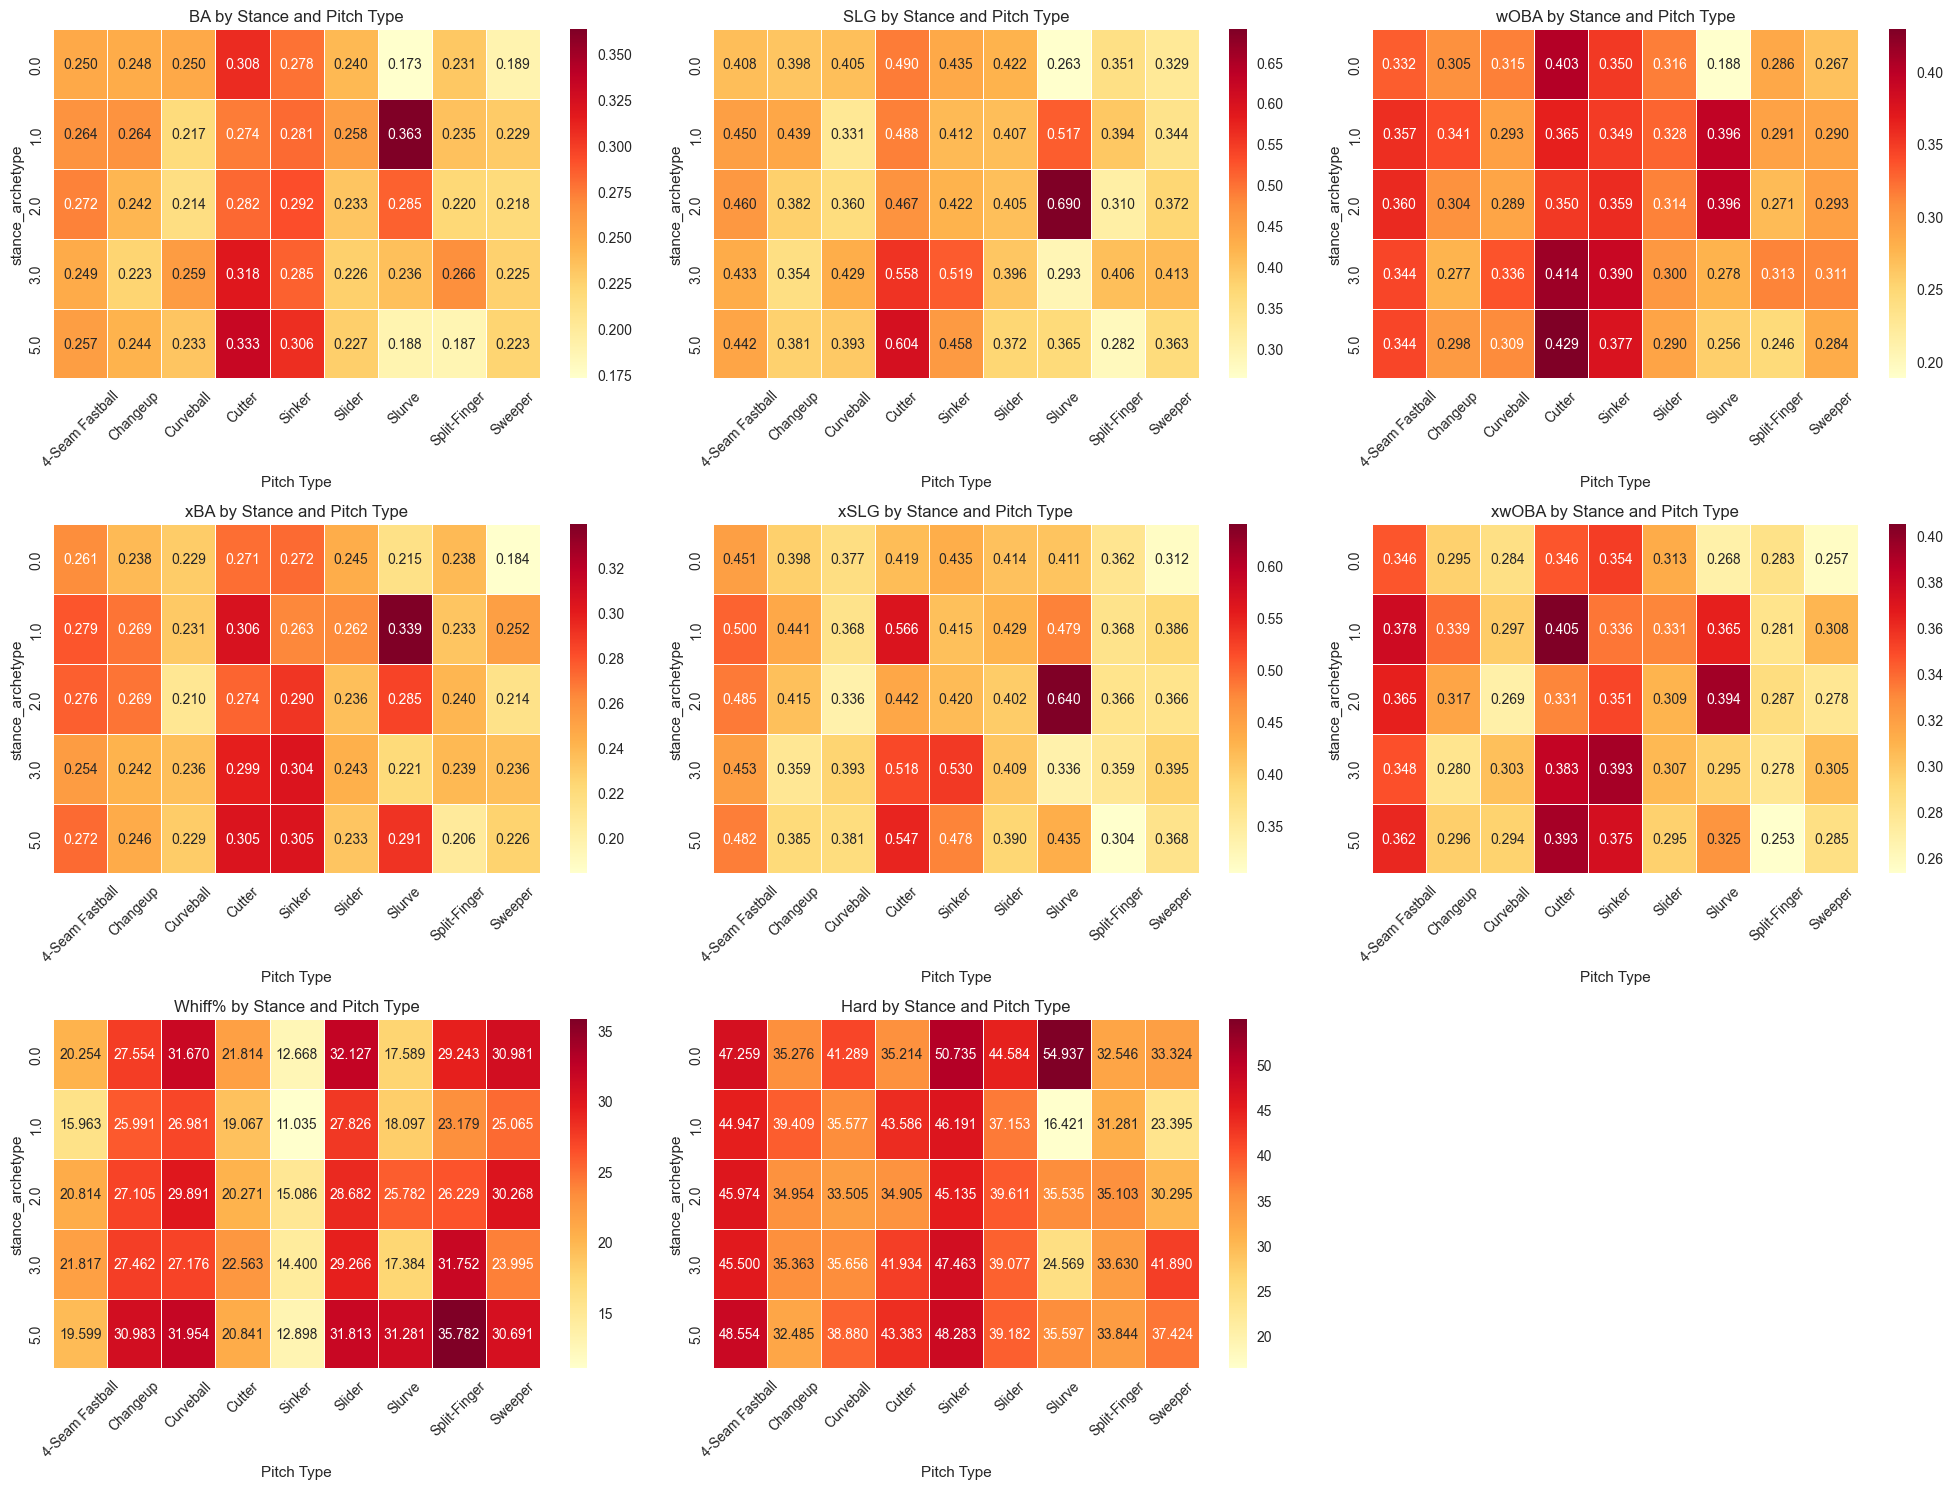

In [102]:
# Pivot tables for each metric
metrics = ['BA mean', 'SLG mean', 'wOBA mean', 'xBA mean', 'xSLG mean', 'xwOBA mean', 'Whiff% mean', 'Hard Hit % mean']

plt.figure(figsize=(20, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    pivot_df = filtered_performance.pivot(index='stance_archetype', columns='Pitch Type', values=metric)
    sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="YlOrRd", linewidths=.5)
    plt.title(f'{metric.split()[0]} by Stance and Pitch Type')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()